In [8]:
import pennylane as qml
import os
import pickle
import re
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
from qiskit import *

from jax import numpy as jnp
import sympy
import matplotlib.pyplot as plt
import base64
import pickle
from qutip import *

 # Using pennylane's wrapped numpy
from sympy import symbols, MatrixSymbol, lambdify, Matrix, pprint
import jax
import numpy as np
from jax import random
import scipy
import pickle
import base64
import time
import os
import ast
import pandas as pd
from pathlib import Path
from qiskit.circuit.library import *
from qiskit import *
from qiskit.quantum_info import *
import autograd
from pennylane.wires import Wires
import matplotlib.cm as cm
from functools import partial
from pennylane import numpy as pnp
from jax import config
import optax
from pennylane.transforms import transform
from typing import Sequence, Callable, Union, List
from itertools import chain
from functools import partial, singledispatch


from jax import jit
import pennylane as qml
import time
#from pennylane.pulse import ParametrizedEvolution, ParametrizedHamiltonian,HardwareHamiltonian
from jax.experimental.ode import odeint

has_jax = True
diable_jit = False
config.update('jax_disable_jit', diable_jit)
#config.parse_flags_with_absl()
config.update("jax_enable_x64", True)
os.environ['JAX_TRACEBACK_FILTERING'] = 'off'
global_cache_data = None
global_processed_files = None

global_cache_data_digital = None
global_processed_files_digital = None


In [7]:
import os
import pickle
import re
import numpy as np
from pathlib import Path


def extract_trotter_step(data_file):
    """Helper to extract trotter step from file path."""
    return int(data_file.parent.name.split('_')[-1])

def extract_Nr(data_file):
    """Helper to extract N_reserv from file path."""
    return int(data_file.parent.parent.name.split('_')[-1])
def is_valid_pickle_file(file_path):
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                # Attempt to load the pickle file
                df = pickle.load(f)
                
            return True
        else:
            return False
    except EOFError:
        return False
def extract_last_number(text):
    numbers = re.findall(r'\d+', text)
    return int(numbers[-1]) if numbers else 0
def read_jax_file(file_path, gate_name):
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
        df = clean_array(df)
        costs = np.asarray([float(i) for i in df['costs'][0]], dtype=np.float64)
        grads_per_epoch = [np.asarray(i, dtype=np.float64) for i in df['grads_per_epoch'][0]]

        fidelity =df['avg_fidelity'][0]
        num_params = 3 + int(df['controls'][0]) * int(df['reservoirs'][0]) * int(df['trotter_step'][0])
        try:
            test_results =  np.asarray(df['fidelities'][0], dtype=np.float64)
        except KeyError:
            
            test_results =  np.asarray(df['testing_results'][0], dtype=np.float64)
        num_epochs = df['epochs'][0]
        return costs, fidelity, num_params, test_results,grads_per_epoch
def load_and_clean_pickle(data_file):
    """Helper function to load and clean a pickle file."""
    with open(data_file, 'rb') as f:
        df = pickle.load(f)
        cleaned_df = clean_array(df)  # Apply cleaning
        return cleaned_df
def clean_array(data):
    """Helper function to clean any deprecated JAX arrays."""
    if isinstance(data, np.ndarray):
        return np.array(data)  # Ensure the array doesn't have deprecated attributes
    elif isinstance(data, dict):
        return {k: clean_array(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [clean_array(v) for v in data]
    else:
        return data
    

# def get_cached_data(base_path):
#     """Load cached data and list of processed files from cache stored in the base_path."""
#     cache_file = os.path.join(base_path, 'cached_results.pkl')
#     if os.path.exists(cache_file):
#         with open(cache_file, 'rb') as f:
#             cached_data, processed_files = pickle.load(f)
#         print(f"Loaded {len(processed_files)} processed files.")
#         return cached_data, processed_files
#     else:
#         return {}, set()

def get_cached_data(base_path):
    """Load cached data and list of processed files from a specified cache path."""
    start_time = time.time()
    cache_file = os.path.join(base_path, 'cached_results.pkl')
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            cached_data, processed_files = pickle.load(f)
            # Clean arrays to ensure compatibility
            cached_data = clean_array(cached_data)
        load_time = time.time() - start_time
        print(f"Loaded {len(processed_files)} processed files from cache. Took {load_time:.2f}s.")
        return cached_data, processed_files
    else:
        print(f"Cache file not found: {cache_file}")
        return {}, set()
def get_cached_data_once_digital(base_path, N_ctrl, K_0):
    """Load cached data only once and keep it in memory for future runs for the digital model."""
    global global_cache_data_digital, global_processed_files_digital
    cache_file = os.path.join(base_path, f'digital_results_QFIM_Nc_{N_ctrl}_{K_0}K.pkl')
    
    print(cache_file)
    if global_cache_data_digital and global_processed_files_digital:
        print(f"Using cached data from memory for N_ctrl={N_ctrl}.")
        return global_cache_data_digital, global_processed_files_digital
    

    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            global_cache_data_digital, global_processed_files_digital = pickle.load(f)
        print(f"Loaded cache for N_ctrl={N_ctrl} from disk.")
        global_cache_data_digital = clean_array(global_cache_data_digital)
        # Filter the cache to only include files from the correct base path
        global_processed_files_digital = set(
            file for file in global_processed_files_digital if file.startswith(base_path)
        )
        with open(cache_file, 'wb') as f:
            pickle.dump((global_cache_data_digital, global_processed_files_digital), f)
        print(f"Cleaned and re-saved cache file: {cache_file}")

        return global_cache_data_digital, global_processed_files_digital
    else:
        global_cache_data_digital = {}
        global_processed_files_digital = set()
        return global_cache_data_digital, global_processed_files_digital
    

    
def save_cached_data(base_path, cached_data, processed_files):
    """Save cached data and list of processed files to cache stored in the base_path."""
    cache_file = os.path.join(base_path, f'cached_results.pkl')
    with open(cache_file, 'wb') as f:
        pickle.dump((cached_data, processed_files), f)
def update_cache_with_new_data(base_path, gate_prefixes, reservoir_counts, trots, cached_data, processed_files, N_ctrl):
    """Update cache with new key/values without reprocessing already processed files."""
    print(f"Processing for N_ctrl = {N_ctrl}")
    for gate_prefix in gate_prefixes:
        for folder_name in sorted(os.listdir(base_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name

                for bath_status in ['bath_True', 'bath_False/']:
                    for subfolder in sorted(os.listdir(os.path.join(base_path, gate)), key=extract_last_number):
                        if 'reservoirs_' in subfolder:
                            reservoir_count = extract_last_number(subfolder)
                            if reservoir_count not in reservoir_counts:
                                continue

                            for trotter_folder in sorted(os.listdir(os.path.join(base_path, gate, subfolder)), key=extract_last_number):
                                if 'trotter_step_' in trotter_folder:
                                    trotter_step = extract_last_number(trotter_folder)
                                    if trotter_step not in trots:
                                        continue

                                    trotter_path = os.path.join(base_path, gate, subfolder, trotter_folder, bath_status)
                                    if not os.path.exists(trotter_path):
                                        continue

                                    files_in_folder = os.listdir(trotter_path)

                                    # Count data runs already in cache
                                    cached_trotter_data = cached_data.get(N_ctrl, {}).get(gate, {}).get(reservoir_count, {}).get(trotter_step, [])
                                    num_data_runs = len(cached_trotter_data)

                                    for file in files_in_folder:
                                        if not file.startswith('.'):
                                            pickle_file = os.path.join(trotter_path, file)
                                            
                                            # Normalize the file path to ensure consistency in checking
                                            pickle_file = os.path.normpath(pickle_file)

                                            # Extract just the data_run_<i> part from the file name
                                            run = os.path.basename(pickle_file).replace('.pickle', '')

                                            # Check if the file has already been processed
                                            if pickle_file in processed_files:
                                                # Update the run field in cached data if missing
                                                for cached_result in cached_trotter_data:
                                                    if 'run' not in cached_result or 'gate' not in cached_result or cached_result['run'] != run:
                                                        cached_result['run'] = run
                                                        cached_result['gate'] = gate
                                                # print(f"Data missing from")
                                                continue

                                            # Process new file
                                            if is_valid_pickle_file(Path(pickle_file)):
                                                costs, fidelity, num_params, test_results, grads_per_epoch = read_jax_file(pickle_file, gate)
                                                
                                                

                                                # Store the new data point
                                                if gate not in cached_data[N_ctrl]:
                                                    cached_data[N_ctrl][gate] = {}
                                                if reservoir_count not in cached_data[N_ctrl][gate]:
                                                    cached_data[N_ctrl][gate][reservoir_count] = {}
                                                if trotter_step not in cached_data[N_ctrl][gate][reservoir_count]:
                                                    cached_data[N_ctrl][gate][reservoir_count][trotter_step] = []

                                     
                                                
                                                num_data_runs += 1  # Increment the number of data runs
                                                # Extract just the data_run_<i> part from the file name
                                                run = os.path.basename(pickle_file).replace('.pickle', '')

                                                # Prepare the new data point
                                                data_point = {
                                                    'costs': costs,
                                                    'gate': gate,
                                                    'fidelity': fidelity,
                                                    'test_results': test_results,
                                                    'param_count': num_params,
                                                    'run': run,  # Store the data_run_<i> value
                                                    'num_data_runs': num_data_runs,
                                                    'grads_per_epoch':grads_per_epoch,
                                                    # 'selected_indices':selected_indices
                                                }

                                      
                                                cached_data[N_ctrl][gate][reservoir_count][trotter_step].append(data_point)


                                                
                                                processed_files.add(pickle_file)  # Mark file as processed

    print(f"Cache updated for N_ctrl={N_ctrl}")
    return cached_data, processed_files
def process_new_files_digital(base_path, gate_prefixes, reservoir_counts, trots, cached_data, processed_files, N_ctrl):
    """Process new files that haven't been processed before, and update cache with the best fidelity."""
    print(f"Processing for N_ctrl = {N_ctrl}")
    for gate_prefix in gate_prefixes:
        for folder_name in sorted(os.listdir(base_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name

                # Ensure that N_ctrl is a top-level key in the cache
                if N_ctrl not in cached_data:
                    cached_data[N_ctrl] = {}

                for bath_status in ['bath_True', 'bath_False/']:
                    for subfolder in sorted(os.listdir(os.path.join(base_path, gate)), key=extract_last_number):
                        if 'reservoirs_' in subfolder:
                            reservoir_count = extract_last_number(subfolder)
                            if reservoir_count not in reservoir_counts:
                                continue

                            for trotter_folder in sorted(os.listdir(os.path.join(base_path, gate, subfolder)), key=extract_last_number):
                                if 'trotter_step_' in trotter_folder:
                                    trotter_step = extract_last_number(trotter_folder)
                                    if trotter_step not in trots:
                                        continue

                                    trotter_path = os.path.join(base_path, gate, subfolder, trotter_folder, bath_status)
                                    if not os.path.exists(trotter_path):
                                        continue

                                    files_in_folder = os.listdir(trotter_path)
                                    current_best_fidelity = float('-inf')  # Set initial best fidelity as lowest possible value
                                    current_best_data_point = None
                                    num_data_runs = 0

                                    # Check if there's already cached data for this trotter step
                                    cached_trotter_data = cached_data.get(N_ctrl, {}).get(gate, {}).get(reservoir_count, {}).get(trotter_step, [])
                                    if cached_trotter_data:
                                        current_best_data_point = cached_trotter_data[0]  # Assuming one best result per trotter step
                                        current_best_fidelity = np.mean(current_best_data_point['fidelity'])
                                        num_data_runs = current_best_data_point.get('num_data_runs', 0)

                                    # Now process the new files and compare with cached results
                                    for file in files_in_folder:
                                        if not file.startswith('.'):
                                            pickle_file = os.path.join(trotter_path, file)
                                            
                                            # Normalize the file path to ensure consistency in checking
                                            pickle_file = os.path.normpath(pickle_file)

                                            # Ensure the file belongs to the correct base path
                                            if not pickle_file.startswith(base_path):
                                                continue

                                            # Check if the file has been processed before
                                            if pickle_file not in processed_files and is_valid_pickle_file(Path(pickle_file)):
                                                # Process the file and find the fidelity
                                                costs, fidelity, num_params, test_results, grads_per_epoch = read_jax_file(pickle_file, gate)
                                                
                                                num_data_runs += 1  # Increment the number of data runs
                                                run = os.path.basename(pickle_file).replace('.pickle', '')

                                                # Check if this new file has a better fidelity
                                                if fidelity > current_best_fidelity:
                                                    current_best_fidelity = fidelity
                                                    current_best_data_point = {
                                                        'costs': costs,
                                                        'gate': gate,
                                                        'fidelity': fidelity,
                                                        'test_results': test_results,
                                                        'param_count': num_params,
                                                        'run': run,
                                                        'num_data_runs': num_data_runs,
                                                        'grads_per_epoch': grads_per_epoch,
                                                    }
                                                processed_files.add(pickle_file)

                                    # If we found a valid data point with better fidelity, cache it
                                    if current_best_data_point:
                                        if gate not in cached_data[N_ctrl]:
                                            cached_data[N_ctrl][gate] = {}
                                        if reservoir_count not in cached_data[N_ctrl][gate]:
                                            cached_data[N_ctrl][gate][reservoir_count] = {}
                                        if trotter_step not in cached_data[N_ctrl][gate][reservoir_count]:
                                            cached_data[N_ctrl][gate][reservoir_count][trotter_step] = []

                                        # Replace the cached data with the new best data point
                                        cached_data[N_ctrl][gate][reservoir_count][trotter_step] = [current_best_data_point]
                                        # processed_files.add(pickle_file)  # Mark file as processed

    return cached_data, processed_files

def process_and_cache_new_files(base_path,K_0, model_type, N_ctrls, threshold, by_test, check_for_new_data, cached_data, processed_files, range = 1):
    """Process new files, cache results, and return updated DataFrame."""
    all_data = []


    for N_ctrl in N_ctrls:
        model_path = base_path / model_type / f'Nc_{N_ctrl}' / 'GHZ_state/'

        for Nr in sorted(os.listdir(model_path)):
            Nr_path = model_path / Nr
            if not Nr_path.is_dir():
                print(f"Not a dir: {Nr_path}")
                continue

            for trotter_step in sorted(os.listdir(Nr_path)):
                trotter_step_path = Nr_path / trotter_step
                if not trotter_step_path.is_dir():
                    # print(f"Not a ÷dir: {trotter_step_path}")
                    continue
                data_file = trotter_step_path / f'{K_0}xK/param_range_{range}/data.pickle'
                # if N_ctrl == 3:
                #     data_file = trotter_step_path / f'1xK/param_range_{range}/data.pickle'
                
                file_id = str(data_file)

                if file_id in cached_data:
                    if check_for_new_data:
                        cached_data, processed_files = update_cached_data(data_file, cached_data, processed_files, N_ctrl)
                    all_data.append(cached_data[file_id]['processed_data'])
                    continue

                if is_valid_pickle_file(data_file):
                    # print(f"Reading d÷ata from: {data_file}")
                    df = load_and_clean_pickle(data_file)
                    trotter_step_num = extract_trotter_step(data_file)
                    reservoir_count = extract_Nr(data_file)
                    processed_data = process_data_combined(
                        df, threshold, by_test,N_ctrl, reservoir_count, trotter_step_num, False
                    )
                    processed_data.update({
                        'N_ctrl': N_ctrl,
                        'N_reserv': reservoir_count,
                        'Trotter_Step': trotter_step_num
                    })

                    cached_data[file_id] = {'processed_data': processed_data, 'raw_data': df}
                    processed_files.add(file_id)
                    all_data.append(processed_data)

        save_cached_data(base_path, cached_data, processed_files, N_ctrl,K_0)

    return cached_data, processed_files, pd.DataFrame(all_data)





# Initialization and execution
N_ctrls = [1,2,3]
threshold=1e-10
by_test = False
num_train = 20
reservoir_counts = [1,2,3]
processed_files_global_digital = set()
K_0=1
# base_path = f'/Users/so714f/Documents/offline/qrc/gate_results_trainable_global/trainsize_{num_train}/'
base_path = Path('/Users/sophieblock/QRCcapstone/parameter_analysis_directory/')
model_type = "gate"
for N_ctrl in N_ctrls:
    cached_data, processed_files = get_cached_data_once_digital(base_path, N_ctrl, K_0)
# Load cached data and processed files (cached only once for the digital model)
cached_data, processed_files, df_all = process_and_cache_new_files(
    base_path,K_0, model_type, N_ctrls, threshold, by_test, check_for_new_data=True, cached_data=cached_data, processed_files=processed_files, range = param_range
)
# Update the processed files set globally for digital
processed_files.update(processed_files_global_digital)
for N_ctrl in N_ctrls:
    
    gate_prefixes = [f'U{N_ctrl}']
    

    # Load cached data and processed files
    # cached_data, processed_files = get_cached_data(base_path)
    # cached_data, processed_files = inspect_current_cache(base_path)


    trots = np.arange(1, 54, 1)

    # Process files and update the cache
    cached_data, processed_files = process_new_files_digital(base_path, gate_prefixes, reservoir_counts, trots, cached_data, processed_files, N_ctrl)
    cached_data, processed_files = update_cache_with_new_data(
        base_path, gate_prefixes, reservoir_counts, trots, 
        cached_data, processed_files, N_ctrl
    )
    cached_data, processed_files = process_new_files_digital(
        base_path, gate_prefixes, reservoir_counts, trots, 
        cached_data, processed_files, N_ctrl
    )
    
    save_cached_data(base_path, cached_data, processed_files)
    processed_files_global_digital.update(processed_files)
#/Users/sophieblock/QRCCapstone/digital_results_trainable_global/trainsize_10_optimized_by_cost3/U1_5

/Users/sophieblock/QRCcapstone/parameter_analysis_directory/digital_results_QFIM_Nc_1_1K.pkl
/Users/sophieblock/QRCcapstone/parameter_analysis_directory/digital_results_QFIM_Nc_2_1K.pkl
Loaded cache for N_ctrl=2 from disk.


TypeError: startswith first arg must be str or a tuple of str, not PosixPath

In [12]:

N_ctrls = [1,2,3]
jitter_scale = 1e-6
min_error = 1e-9
rows = []  # List to hold rows temporarily
negative_fidelity_values = []

for N_ctrl in N_ctrls:
    data_i = cached_data[N_ctrl]

    for gate, gate_data in data_i.items():
        for reservoir_count, res_data in gate_data.items():
            for trotter_step, results_list in res_data.items():
                for results in results_list:
                    # Handle missing fidelity and other fields
                    avg_fidelity = float(results['fidelity']) if 'fidelity' in results else np.nan
                    log_infidelities = []
                    if 'test_results' in results:
                        test_results = results['test_results']
                        for fidelity in test_results:
                            if fidelity < 0:
                                negative_fidelity_values.append({
                                    'Gate': gate,
                                    'Reservoir Count': reservoir_count,
                                    'Trotter_Step': trotter_step,
                                    'Fidelity': fidelity
                                })
                            if fidelity >= 1.0:
                                fidelity = 1.0 - np.random.uniform(0, jitter_scale)
                                # print(f"applying jitter: {fidelity:.8f}")
                            infidelity = max(1.0 - fidelity, min_error)
                            log_infidelity = np.log10(infidelity)
                            log_infidelities.append(log_infidelity)
                    else:
                        test_results = []
                        log_infidelities = []

                    num_params = results.get('param_count', np.nan)
                    run = results.get('run', None)
                    # Check if avg_fidelity is NaN
                    if pd.isna(avg_fidelity):
                        print(f"NaN detected! Test: Gate: {gate}, Reservoir Count: {reservoir_count}, Trotter_Step: {trotter_step}, Run: {run}")
                    
                    # If avg_fidelity is valid, calculate log_infidelity
                    avg_log_infidelity = np.nan
                    if pd.notna(avg_fidelity) and avg_fidelity < 1.0:
                        avg_log_infidelity = np.log10(1.0 - avg_fidelity)
                    else:
                        avg_log_infidelity = np.log10(min_error)
                    # Prepare the row dictionary with all fields
                    # print(results.keys())
                    row = {
                        'N_C': N_ctrl,
                        'Trotter_Step': trotter_step,
                        'Gate': results['gate'],
                        'Reservoir Count': reservoir_count,
                        'Avg_Fidelity': avg_fidelity,
                        'Error Test Results': log_infidelities,
                        'Avg Error': avg_log_infidelity,
                        'Costs': results.get('costs', []),
                        'Test Results': test_results,
                        'N_params': num_params,
                        'run': run,
                    }
                   
                    rows.append(row)

# Create the DataFrame from the list of rows
all_data_df = pd.DataFrame(rows)

# data_df = all_data_df[(all_data_df['N_C'] == N_ctrl) & (all_data_df['Trotter_Step'].isin(trots))]

all_data_df

KeyError: 2

In [ ]:
averaged_data = all_data_df.groupby(['Trotter_Step', 'Reservoir Count', 'N_C']).agg(
    Average_Fidelity=('Avg_Fidelity', 'mean'),
    Std_Dev=('Avg_Fidelity', 'std'),
    Count=('Avg_Fidelity', 'count'),  # For calculating standard error
    Test_Results=('Test Results', lambda x: [np.array(lst) for lst in x])  # Keep Test Results as list of arrays
).reset_index()

# Add a new column for Standard Error
averaged_data['Standard_Error'] = averaged_data['Std_Dev'] / averaged_data['Count'].pow(0.5)

# Optional: Drop 'Count' if you no longer need it
averaged_data = averaged_data.drop(columns=['Count'])

# Preview the result
print(averaged_data.head())
reservoir_count = 1

trot = 1
N_ctrl = 1
# Filter the row based on your conditions
tes = averaged_data[
    (averaged_data['N_C'] == N_ctrl) & 
    (averaged_data['Reservoir Count'] == reservoir_count) & 
    (averaged_data['Trotter_Step'] == trot)
]

# Access the values of Average_Fidelity and Std_Dev as floats
average_fidelity = float(tes['Average_Fidelity'].values[0])
std_dev = float(tes['Std_Dev'].values[0])
# Access the Test_Results as a list of arrays
test_results = tes['Test_Results'].values[0]  # This will be a list of arrays

# Print the results
print("Average Fidelity:", average_fidelity)
print("Standard Deviation:", std_dev)
print("Test Results (List of Arrays):", np.mean(test_results))
# averaged_data.head()

In [ ]:
import os
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def is_valid_pickle_file(file_path):
    """Check if a pickle file is valid and re-save it after cleaning."""
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                try:
                    data = pickle.load(f)
                    # Clean the data to ensure compatibility
                    cleaned_data = clean_array(data)
                    
                    # Re-save the cleaned data to the same file
                    with open(file_path, 'wb') as fw:
                        pickle.dump(cleaned_data, fw)
                    
                    return True
                except EOFError:
                    print(f"File {file_path} is corrupted.")
                    return False
    except Exception as e:
        print(f"An error occurred: {e}")
        return False
def clean_array(data):
    """Helper function to clean deprecated JAX arrays."""
    if isinstance(data, np.ndarray):
        return np.array(data)  # Strip any unsupported attributes
    elif isinstance(data, dict):
        return {k: clean_array(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [clean_array(v) for v in data]
    elif hasattr(data, 'named_shape'):  # Specifically check for deprecated JAX atributes
        del data.named_shape
        return data
    else:
        return data  # Return as is if not an array or collection

#print("all_gradients shape:", all_gradients.shape)
def calculate_gradient_stats(gradients):
    mean_grad = jnp.mean(gradients, axis=0)
    mean_grad_squared = jnp.mean(gradients**2, axis=0)
    var_grad = mean_grad_squared - mean_grad**2
    return mean_grad, var_grad

def calculate_inv_qfim(eigen_vals, eigen_vecs, n_params):
    cutoff_eigvals=10**-12
    eigvals_inv=np.zeros(n_params)
    #invert eigenvalues if they are above threshold, else set to zero
    for i in range(n_params):
        if(eigen_vals[i]<cutoff_eigvals):
            eigvals_inv[i]=0 #inverted eigenvalues with cutoff of smallest eigenvalues set to zero
        else:
            eigvals_inv[i]=1/eigen_vals[i]
    qfi_inv_matrix=np.dot(eigen_vecs,np.dot(np.diag(eigvals_inv),np.transpose(np.conjugate(eigen_vecs))))
    return qfi_inv_matrix

def calculate_gradient_variance(gradients):
    grad_matrix = jnp.array(gradients)
    mean_grad = jnp.mean(grad_matrix, axis=0)
    var_grad = jnp.mean((grad_matrix - mean_grad) ** 2, axis=0)
    return var_grad
def get_cached_data_new(base_path, N_ctrl):
    """Load cached data specific to the new dataset (QFIM results) for given N_ctrl."""
    cache_file = os.path.join(base_path, f'digital_results_QFIM_Nc_{N_ctrl}.pkl')
    start_time = time.time()

    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            cached_data, processed_files = pickle.load(f)
        load_time = time.time() - start_time
        print(f"Loaded cache for N_ctrl={N_ctrl} with {len(processed_files)} processed files. Took {load_time:.2f}s.")
        return cached_data, processed_files
    else:
        print(f"Cache file for N_ctrl={N_ctrl} not found.")
        return {}, set()  # Return empty structures if no cache exists
    
def get_cached_data_new_once(base_path, N_ctrl,K_0):
    """Load cached data once and keep in memory."""
    global global_cache_data, global_processed_files
    cache_file = os.path.join(base_path, f'digital_results_QFIM_Nc_{N_ctrl}_{K_0}K.pkl')

    if global_cache_data and global_processed_files:
        print(f"Using cached data from memory for N_ctrl={N_ctrl}.")
        return global_cache_data, global_processed_files

    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            global_cache_data, global_processed_files = pickle.load(f)
        print(f"Loaded cache for N_ctrl={N_ctrl} from disk.")
        return global_cache_data, global_processed_files

    global_cache_data, global_processed_files = {}, set()
    return global_cache_data, global_processed_files

def save_updated_cache(base_path, cached_data, processed_files, N_ctrl,K_0):
    """Save the updated cache with processed files for given N_ctrl."""
    cache_file = os.path.join(base_path, f'digital_results_QFIM_Nc_{N_ctrl}_{K_0}K.pkl')
    with open(cache_file, 'wb') as f:
        pickle.dump((cached_data, processed_files), f)
    print(f"Cache saved for N_ctrl={N_ctrl} at {cache_file}.")

def save_cached_data_new(base_path, cached_data, processed_files, N_ctrl, K_0):
    """Save cached data for the new dataset (QFIM results) for a specific N_ctrl value."""
    cache_file = os.path.join(base_path, f'digital_results_QFIM_Nc_{N_ctrl}_{K_0}K.pkl')
    with open(cache_file, 'wb') as f:
        pickle.dump((cached_data, processed_files), f)
    print(f"Cache for new dataset, N_ctrl={N_ctrl}, saved to {cache_file}")


def load_and_clean_pickle(data_file):
    """Helper function to load and clean a pickle file."""
    with open(data_file, 'rb') as f:
        df = pickle.load(f)
        return clean_array(df)
    
def process_and_cache_new_files(base_path,K_0,sample_range, model_type, N_ctrls, threshold, by_test, check_for_new_data, cached_data, processed_files):
    """Process new files, cache results, and return updated DataFrame."""
    all_data = []

    for N_ctrl in N_ctrls:
        model_path = base_path / 'QFIM_results' / model_type / f'Nc_{N_ctrl}' / f'sample_{sample_range}/{K_0}xK'

        for Nr in sorted(os.listdir(model_path)):
            Nr_path = model_path / Nr
            if not Nr_path.is_dir():
                continue

            for trotter_step in sorted(os.listdir(Nr_path)):
                trotter_step_path = Nr_path / trotter_step
                if not trotter_step_path.is_dir():
                    continue

                data_file = trotter_step_path / 'data.pickle'
                # print(f"PICKLIE FILE: {data_file}")
                file_id = str(data_file)

                if file_id in cached_data:
                    if check_for_new_data:
                        print(f"Updating cached data.file_id: {file_id}")
                        cached_data, processed_files = update_cached_data(data_file, cached_data, processed_files, N_ctrl)
                    all_data.append(cached_data[file_id]['processed_data'])
                    continue

                if is_valid_pickle_file(data_file):
                    print(f"Reading in file: {data_file}")
                    df = load_and_clean_pickle(data_file)
                    trotter_step_num = extract_trotter_step(data_file)
                    reservoir_count = extract_Nr(data_file)
                    processed_data = process_data_combined(
                        df, threshold, by_test,Nc=N_ctrl, N_R=int(Nr.split('_')[-1]), trot=trotter_step_num, print_bool=False
                    )
                    processed_data.update({
                        'N_ctrl': N_ctrl,
                        'N_reserv': reservoir_count,
                        'Trotter_Step': trotter_step_num
                    })

                    cached_data[file_id] = {'processed_data': processed_data, 'raw_data': df}
                    processed_files.add(file_id)
                    all_data.append(processed_data)

        save_cached_data_new(base_path, cached_data, processed_files, N_ctrl,K_0)

    return cached_data, processed_files, pd.DataFrame(all_data)
threshold = 1e-8
#     return cached_data, processed_files,pd.DataFrame(all_data)
def update_cached_data(data_file, cached_data, processed_files, N_ctrl):
    """Update cache with new fixed_params, test keys, or missing 'cond_nums'."""
    file_id = str(data_file)
    
    if file_id in cached_data:
        df = load_and_clean_pickle(data_file)

        for fixed_param in df.keys():
            if fixed_param not in cached_data[file_id]['raw_data']:
                cached_data[file_id]['raw_data'][fixed_param] = df[fixed_param]
            else:
                cached_tests = set(cached_data[file_id]['raw_data'][fixed_param].keys())
                new_tests = set(df[fixed_param].keys()) - cached_tests
                for test in new_tests:
                    cached_data[file_id]['raw_data'][fixed_param][test] = df[fixed_param][test]
        
        # Check for missing 'cond_nums'
        if 'global_redundancies' not in cached_data[file_id]['processed_data']:
        # if True:
        # if N_ctrl == 2 and extract_Nr(data_file) >= 2 and extract_Nr(data_file) <= 5:
        
            # print(f"Adding var_var_eigenvals results for {file_id}.")
            trotter_step_num = extract_trotter_step(data_file)
            processed_data = process_data_combined(
                df, threshold=threshold, by_test=False, Nc = N_ctrl,
                N_R=extract_Nr(data_file), trot=trotter_step_num, print_bool=False
            )
            cached_data[file_id]['processed_data'].update(processed_data)
        # Check for missing 'cond_nums'
        if 'N_param' not in cached_data[file_id]['processed_data']:
            # print(f"Adding 'N_param' for {file_id}.")
            trotter_step_num = extract_trotter_step(data_file)
            processed_data = process_data_combined(
                df, threshold=threshold, by_test=False, Nc = N_ctrl,
                N_R=extract_Nr(data_file), trot=trotter_step_num, print_bool=False
            )
            cached_data[file_id]['processed_data'].update(processed_data)
    else:
        df = load_and_clean_pickle(data_file)
        processed_data = process_data_combined(
            df, threshold=threshold, by_test=False, Nc = N_ctrl,
            N_R=extract_Nr(data_file), trot=extract_trotter_step(data_file), print_bool=False
        )
        cached_data[file_id] = {'processed_data': processed_data, 'raw_data': df}
    
    processed_files.add(file_id)
    return cached_data, processed_files


def extract_trotter_step(data_file):
    """Helper to extract trotter step from file path."""
    return int(data_file.parent.name.split('_')[-1])

def extract_Nr(data_file):
    """Helper to extract N_reserv from file path."""
    return int(data_file.parent.parent.name.split('_')[-1])

def process_data_combined(df, threshold, by_test,Nc, N_R, trot, print_bool, weight_median=0.5, weight_iqr=0.5):
    """Load and process data from a pickle file."""
    global averaged_data
   
    max_eigvals = []
    trace_eigvals = []
    min_eigvals = []
    var_eigval = []
    ranks = []
    var_log_eigval, norm_trace_eigvals = [],[]
    ratios = []
    ranks = []
    counts = []
    entropies = []
    cond_nums = []
    qfim_eigval_list = []
    redundancies = []
    # max_param_dim = 0
    prev_K = None
    # if N_R > 1:
    #     print(f"N_R: {N_R}, trot: {trot} -- {len(df.keys())},  {len(df['fixed_params0'].keys())}")
    for i,fixed_params_dict in enumerate(df.keys()):
        # if i == 0 and N_R == 2:
        #     print(f"num tests: {len(df[fixed_params_dict].keys())}")
            
        for idx,test in enumerate(df[fixed_params_dict].keys()):
            
            
            qfim_eigvals = df[fixed_params_dict][test]['qfim_eigvals']
            qfim_eigval_list.append(qfim_eigvals)
            n_params = len(qfim_eigvals)
            nonzero_eigvals = qfim_eigvals[qfim_eigvals > threshold]
            num_nonzero_eigvals = len(nonzero_eigvals)
            ranks.append(num_nonzero_eigvals)
            counts.append(len(nonzero_eigvals))
            
            ratios.append(len(nonzero_eigvals) / n_params)
            redundancies.append((n_params-num_nonzero_eigvals)/n_params)
            var_eigval.append(np.var(nonzero_eigvals) if nonzero_eigvals.size > 0 else np.nan)
            var_log_eigval.append(np.var(np.log2(nonzero_eigvals)) if nonzero_eigvals.size > 0 else np.nan)
            qfim_condition = np.max(df[fixed_params_dict][test]['qfim_eigvals']) / np.min(df[fixed_params_dict][test]['qfim_eigvals'][df[fixed_params_dict][test]['qfim_eigvals'] > 1e-12])
            cond_nums.append(qfim_condition)
            trace_eigvals.append(np.sum(qfim_eigvals))
            max_eigvals.append(np.max(nonzero_eigvals) if nonzero_eigvals.size > 0 else np.nan)
            min_eigvals.append(np.min(nonzero_eigvals) if nonzero_eigvals.size > 0 else np.nan)
            entropies.append(df[fixed_params_dict][test]['entropy'])
            norm_trace_eigvals.append(np.sum(qfim_eigvals)/len(nonzero_eigvals))
            if N_R == 2 and trot in [20,22,24] and num_nonzero_eigvals >=20:
                print(f"Nr: {N_R} trot: {trot} test{idx} fp: {i} --- rank {num_nonzero_eigvals}")
            if N_R == 3 and trot in [14] and num_nonzero_eigvals >=19:
                print(f"Nr: {N_R} trot: {trot} test{idx} fp: {i} --- rank {num_nonzero_eigvals}")
            if N_R == 4 and trot in [18] and num_nonzero_eigvals >=20:
                print(f"Nr: {N_R} trot: {trot} test{idx} fp: {i} --- rank {num_nonzero_eigvals}")
    # print(ranks)
    max_param_dim = int(np.array(ranks).max())
    

    average_fidelity = np.nan
    std_dev = np.nan
    test_results = []
    
    mean_trace = np.mean(trace_eigvals)
    mean_var_eigval = np.mean(var_eigval)
    mean_var_log_eigval = np.mean(var_log_eigval)
    mean_norm_trace_eigvals = np.mean(norm_trace_eigvals)
    # Calculate the median and IQR
    median_trace = np.median(trace_eigvals)
    median_var_eigval = np.median(var_eigval)
    median_var_log_eigval = np.median(var_log_eigval)
    
    iqr_trace = np.percentile(trace_eigvals, 90) - np.percentile(trace_eigvals, 10)
    iqr_var_eigval = np.percentile(var_eigval, 75) - np.percentile(var_eigval, 25)
    iqr_var_log_eigval = np.percentile(var_log_eigval, 75) - np.percentile(var_log_eigval, 25)
    
    weighted_avg_trace = weight_median * median_trace + weight_iqr * iqr_trace
    weighted_avg_var_eigval = weight_median * median_var_eigval + weight_iqr * iqr_var_eigval
    weighted_avg_var_log_eigval = weight_median * median_var_log_eigval + weight_iqr * iqr_var_log_eigval

    mean_entropy = np.mean(entropies)
    return {
        'mean_trace_eigvals': np.mean(trace_eigvals),
        'all_trace_eigvals':trace_eigvals,
        'all_var_qigvals':var_eigval,
        'all_entropies':entropies,
        'mean_entropy':mean_entropy,
        'quantum_dim': np.mean(ranks),
        'D_C':max_param_dim,
        'mean_norm_trace_eigvals':mean_norm_trace_eigvals,
        'ratios':np.mean(ratios),
        'redundancies':np.mean(redundancies),
        'global_redundancies':(len(qfim_eigvals)-max_param_dim)/len(qfim_eigvals),
        'cond_nums':cond_nums,
        'mean(cond_nums)':np.mean(cond_nums),
        'median_trace_eigvals': median_trace,
        'iqr_trace_eigvals': iqr_trace,
        'weighted_avg_trace_eigvals': weighted_avg_trace,
        'mean_var_eigval': np.mean(var_eigval),
        'var_var_eigenvals': np.var(var_eigval),
        'median_var_eigval': median_var_eigval,
        'iqr_var_eigval': iqr_var_eigval,
        'weighted_avg_var_eigval': weighted_avg_var_eigval,
         'mean_var_log_eigval': np.mean(var_log_eigval),
        'median_var_log_eigval': median_var_log_eigval,
        'iqr_var_log_eigval': iqr_var_log_eigval,
        'weighted_avg_var_log_eigval': weighted_avg_var_log_eigval,
        'all_qfim_eigvals':qfim_eigval_list,
        'N_param': len(qfim_eigvals),
        'Avg_Fidelity': average_fidelity,
        'std': std_dev,
        'all_test_results':  test_results,  
    }



base_path = Path('/Users/sophieblock/QRCcapstone/parameter_analysis_directory/')
model_type = "gate"
# N_ctrls = [1, 2, 3]
N_ctrls = [2]
sample_range = 'pi'
by_test = False
K_str = '1'
for N_ctrl in N_ctrls:
    cached_data, processed_files = get_cached_data_new_once(base_path, N_ctrl,K_str)


#./Users/so714f/Documents/offline/qrc/gate_model_theorem23_eigval_decomp/Nc_2/GHZ_state/1xK/Nr_1/trotter_step_5/data.pickle




Using cached data from memory for N_ctrl=2.


In [21]:
def rebuild_df_from_existing_cache(base_path, N_ctrls, K_0):
    """
    Rebuild a single DataFrame from the cached_data dictionaries saved on disk.
    This does NOT require scanning the original QFIM_results directories.
    
    Parameters:
    -----------
    base_path : Path or str
        The base directory where cached pickles are stored.
    N_ctrls : list of int
        List of N_ctrl values you want to load from cache.
    K_0 : str or int
        The K string/index used in naming the cache files, e.g. '1', '2', etc.

    Returns:
    --------
    df_all : pd.DataFrame
        A DataFrame constructed by concatenating all 'processed_data'
        entries from each cached_data for all given N_ctrls.
    """
    all_data = []
    
    for N_ctrl in N_ctrls:
        # Load the existing cached_data & processed_files from disk
        cached_data, processed_files = get_cached_data_new_once(base_path, N_ctrl, K_0)

        # Each entry in cached_data[file_id] has 'processed_data' and 'raw_data'
        for file_id, file_data in cached_data.items():
            processed_dict = file_data.get('processed_data', {})
            # Accumulate each processed_data dict to build up the final DataFrame
            all_data.append(processed_dict)
    
    df_all = pd.DataFrame(all_data)
    return df_all

df_all = rebuild_df_from_existing_cache(base_path, N_ctrls, K_str)
# threshold = 1e-10
# cached_data, processed_files, df_all = process_and_cache_new_files(
#     base_path,K_str,sample_range, model_type, N_ctrls, threshold, by_test, check_for_new_data=False, cached_data=cached_data, processed_files=processed_files
# )

Using cached data from memory for N_ctrl=2.


In [22]:
df_all.head()

,mean_trace_eigvals,all_trace_eigvals,all_var_qigvals,all_entropies,mean_entropy,quantum_dim,D_C,mean_norm_trace_eigvals,ratios,redundancies,...,iqr_var_log_eigval,weighted_avg_var_log_eigval,all_qfim_eigvals,N_param,Avg_Fidelity,std,all_test_results,N_ctrl,N_reserv,Trotter_Step
0,0.887255,"[1.0485384297245648, 0.46257661998702093, 1.10...","[0.07522552723847012, 0.006812335367866909, 0....","[0.40727880829613583, 0.06786416983032353, 0.3...",0.276332,2.00,2,0.443627,0.500000,0.500000,...,1.312120,1.298486,"[[-1.1835388942892915e-16, 9.059831380955862e-...",4,NaN,NaN,[],1,1,1
1,15.498362,"[29.90997683119441, 8.07784462740541, 11.29557...","[181.0359681038011, 4.332096545709185, 15.1241...","[0.6216904431866523, 0.300643670523687, 0.1829...",0.340373,3.00,3,5.166121,0.230769,0.769231,...,2.786463,2.992766,"[[-2.2747166405300493e-15, -6.047807625716317e...",13,NaN,NaN,[],1,1,10
2,20.426413,"[25.435834160715675, 8.779745830173203, 10.212...","[117.93573612406645, 2.531326821377331, 12.553...","[0.2683315367533198, 0.1331514312037284, 0.204...",0.307659,3.00,3,6.808804,0.214286,0.785714,...,2.920319,3.195678,"[[-3.5505385431021054e-15, -1.452656202552731e...",14,NaN,NaN,[],1,1,11
3,20.397469,"[13.415672109582312, 10.120503823788976, 23.74...","[12.159041574381929, 9.800017059462158, 68.259...","[0.42911283236040376, 0.4365762230214003, 0.31...",0.301283,3.00,3,6.799156,0.200000,0.800000,...,2.683447,3.169132,"[[-5.42686066755337e-16, -2.7122154569557615e-...",15,NaN,NaN,[],1,1,12
4,26.516238,"[18.307595817700065, 48.02607850637119, 9.0007...","[46.25794394323219, 371.64159818615383, 11.376...","[0.3633117919953423, 0.0020912586668060855, 0....",0.292575,3.02,4,8.743941,0.188750,0.811250,...,2.518683,3.153522,"[[-4.472908649156518e-16, -2.1682319945471305e...",16,NaN,NaN,[],1,1,13


In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
##########################
# 1) Define a helper function
##########################
def compute_ipr_dimension(eigenvalues, threshold=1e-10):
    """
    Compute the inverse-participation-ratio-based dimension for a
    single list of eigenvalues, following eq. (32):
        d_eff = (sum(eigvals)^2) / sum(eigvals^2)
    Eigenvalues below 'threshold' are treated as negligible.
    """
    # Filter out very small eigenvalues
    valid_eigs = [val for val in eigenvalues if val > threshold]
    
    if not valid_eigs:
        # If all eigenvalues are below threshold, return 0
        return 0.0
    
    sum_eigs = sum(valid_eigs)
    sum_eigs_sq = sum(val**2 for val in valid_eigs)
    
    # If sum_eigs_sq == 0 (which is extremely unlikely if valid_eigs is non-empty),
    # set dimension to 0 to avoid divide-by-zero
    if sum_eigs_sq == 0:
        return 0.0
    
    return (sum_eigs ** 2) / sum_eigs_sq

df_all['IPR_dims'] = df_all['all_qfim_eigvals'].apply(
    lambda list_of_arrays: [
        compute_ipr_dimension(eigvals, threshold=1e-10) 
        for eigvals in list_of_arrays
    ]
)

grouped = df_all.groupby(['Trotter_Step', 'N_reserv', 'N_ctrl'])

# We define a helper to get max and mean IPR across all tests in a group:
def summarize_ipr(series_of_lists):
    """
    'series_of_lists' is a pd.Series whose each entry
    is a *list of IPR dims* for that row.
    We'll flatten these lists to compute stats.
    """
    # Flatten: from a Series of lists -> single list of values
    all_ipr_vals = [val for single_row in series_of_lists for val in single_row]
    return pd.Series({
        'max_IPR_dim': np.max(all_ipr_vals) if len(all_ipr_vals) else np.nan,
        'mean_IPR_dim': np.mean(all_ipr_vals) if len(all_ipr_vals) else np.nan
    })

results_ipr = grouped['IPR_dims'].apply(summarize_ipr).reset_index()
print(results_ipr)
# Define a threshold for eigenvalues
threshold = 1e-10

# Function to compute ranks based on eigenvalues above the threshold
def compute_rank(eigval_list, threshold):
    return [len([val for val in eigvals if val > threshold]) for eigvals in eigval_list]

# Add a column for ranks (list of ranks per test for each row)
df_all['ranks'] = df_all['all_qfim_eigvals'].apply(lambda eigval_list: compute_rank(eigval_list, threshold))

# Group by Trotter_Step, N_reserv, and N_ctrl
grouped = df_all.groupby(['Trotter_Step', 'N_reserv', 'N_ctrl'])

# Compute max and mean rank for each group
results = grouped['ranks'].apply(lambda x: {
    'max_rank': max([max(r) for r in x]),  # Maximum rank across all tests
    'mean_rank': np.mean([np.mean(r) for r in x])  # Average rank across all tests
}).apply(pd.Series).reset_index()

# Fix the column names (if necessary)
results = results.rename(columns={0: 'value', 'level_3': 'metric'})

# Pivot to flatten the structure
results = results.pivot(index=['Trotter_Step', 'N_reserv', 'N_ctrl'], columns='metric', values='value').reset_index()


     Trotter_Step  N_reserv  N_ctrl       level_3  IPR_dims
0               1         1       1   max_IPR_dim  1.981098
1               1         1       1  mean_IPR_dim  1.449867
2               1         1       2   max_IPR_dim  3.843656
3               1         1       2  mean_IPR_dim  2.506845
4               1         2       1   max_IPR_dim  2.331190
..            ...       ...     ...           ...       ...
405            30         1       3  mean_IPR_dim  3.126059
406            35         1       3   max_IPR_dim  4.620684
407            35         1       3  mean_IPR_dim  2.998068
408            40         1       3   max_IPR_dim  7.314303
409            40         1       3  mean_IPR_dim  3.487277

[410 rows x 5 columns]


In [ ]:
# Choose a single threshold
threshold = 1e-10

# Create 'ranks' column for this threshold
df_all['ranks'] = df_all['all_qfim_eigvals'].apply(
    lambda eigval_list: [sum(val > threshold for val in eigvals) for eigvals in eigval_list]
)


In [57]:
def get_num_params(N_r,N_c,T):
    return N_r*N_c*T + 3 
results['num_params'] = results.apply(
    lambda row: get_num_params(
        row['N_reserv'], 
        row['N_ctrl'], 
        row['Trotter_Step']
    ), 
    axis=1
)
results

metric,Trotter_Step,N_reserv,N_ctrl,max_rank,mean_rank,num_params
0,1,1,1,2.0,2.0,5.0
1,1,1,2,5.0,5.0,6.0
2,1,2,1,3.0,3.0,6.0
3,1,2,2,6.0,6.0,8.0
4,1,3,1,3.0,3.0,7.0
...,...,...,...,...,...,...
200,24,4,2,15.0,15.0,219.0
201,25,1,3,63.0,63.0,103.0
202,30,1,3,63.0,63.0,123.0
203,35,1,3,63.0,63.0,143.0


param_list: [5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 47, 51]
mean_ranks: (5, 7, 9, 11, 13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15)
Detected critical T_C = 6, corresponding M_C = 15


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_54665/2253014555.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("Set2")


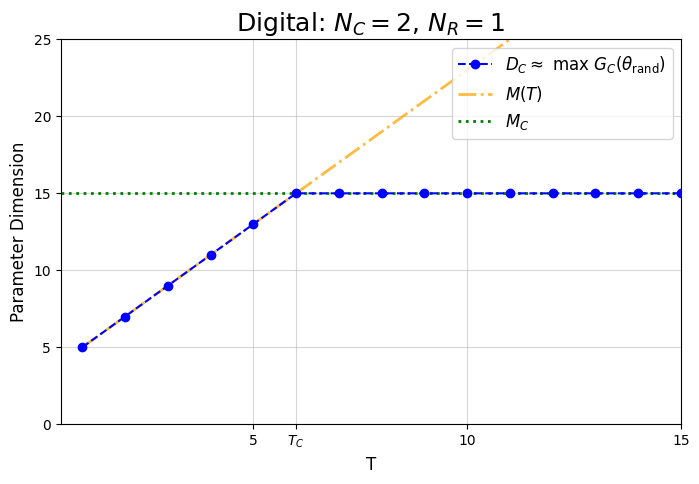

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Single threshold, single color
threshold = 1e-10
cmap = get_cmap("Set2")
color = cmap(0)

chosen_n_ctrl = 2
chosen_n_reserv = 1

def get_num_params(N_r, N_c, T):
    # Example: N_r*N_c*T + 3 + T, 
    # but you said you prefer N_r*N_c*T + 3 for now:
    return N_r * N_c * T + 3

# Suppose your DataFrame df_all has columns: 
#   'Trotter_Step', 'N_ctrl', 'N_reserv', 'ranks', etc.
# Filter for chosen N_ctrl and N_reserv
subset = df_all[(df_all['N_ctrl'] == chosen_n_ctrl) &
                (df_all['N_reserv'] == chosen_n_reserv)]

trotter_steps = []
max_ranks = []

for T_step, grp in subset.groupby('Trotter_Step'):
    all_ranks = []
    for _, row in grp.iterrows():
        # each row['ranks'] is a list of rank values
        all_ranks.extend(row['ranks'])
    
    # Use np.max instead of np.mean
    max_rank = np.max(all_ranks) if len(all_ranks) > 0 else 0
    trotter_steps.append(T_step)
    max_ranks.append(max_rank)

# Sort by Trotter step for a clean line plot
trotter_steps, max_ranks = zip(*sorted(zip(trotter_steps, max_ranks)))

# Also build arrays for M(T)
param_list = [get_num_params(chosen_n_reserv, chosen_n_ctrl, t) for t in trotter_steps]

###############################################################################
# Detect the "critical" T_C
###############################################################################
# For example, define T_C as the Trotter step where mean_rank is largest:
idx_C = int(np.argmax(max_ranks))
T_C = trotter_steps[idx_C]      # Trotter step at maximum rank
M_C = param_list[idx_C]         # number of parameters at that T step
print(f"param_list: {param_list}")
print(f"mean_ranks: {max_ranks}")
Dmax = max_ranks[idx_C]
print(f"Detected critical T_C = {T_C}, corresponding M_C = {M_C}")

###############################################################################
# Make the plot
###############################################################################
fig, ax = plt.subplots(figsize=(8, 5))

# 1) Plot D_C vs T
ax.plot(
    trotter_steps, max_ranks, marker='o', linestyle='--',
    color='b', label=r'$D_C \approx$ max $G_C(\theta_{\text{rand}})$',zorder=10,
)

# 2) Plot M(T)
ax.plot(
    trotter_steps, param_list, color="orange", linestyle='-.',
    alpha=0.75, linewidth=2, label='$M(T)$'
)

# 3) Plot a horizontal line at M_C
ax.axhline(y=M_C, color='green', linestyle=':', linewidth=2, label='$M_C$')

# 3) No vertical line. Instead, add an x‐tick labeled "T_C"
current_xticks = list(ax.get_xticks())  # existing ticks chosen by matplotlib
# Ensure T_C is added (if not already in the list)
if T_C not in current_xticks:
    current_xticks.append(T_C)

# Sort them for a nice ascending sequence
current_xticks = sorted(current_xticks)

# Convert ticks to strings, but replace T_C with "T_C"
xtick_labels = []
for tick in current_xticks:
    if tick == T_C:
        xtick_labels.append(r"$T_C$")  # label this tick specifically
    else:
        # If T is integer, show it as int; otherwise as float
        xtick_labels.append(str(int(tick)) if tick.is_integer() else f"{tick:.1f}")

ax.set_xticks(current_xticks)
ax.set_xticklabels(xtick_labels)
ax.set_xlabel('T', fontsize=12)
ax.set_ylabel('Parameter Dimension', fontsize=12)
ax.set_ylim(0, max(max(max_ranks), max(param_list)) * 1.1)  # pad top
ax.legend(fontsize=12,loc = 'upper right')
ax.grid(True, alpha=0.5)
ax.set_ylim(0,25)
ax.set_xlim(left=0.5, right=15)
# ax.set_xlim(left=0.5, right=max(trotter_steps)+1)
# ax.set_ylim(bottom=0, top=max(max(max_ranks), max(param_list)) * 1.1)
ax.set_title(f'Digital: $N_C = 2$, $N_R = 1$',fontsize=18)
plt.show()


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_54665/3995137560.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("Set2")


param_list: [9, 15, 21, 27, 33, 39, 45, 51, 57, 63, 69, 75, 81, 87, 93, 99, 105, 111, 117, 123, 135, 147]
mean_ranks: (8, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15)
Detected critical T_C = 2, corresponding M_C = 15


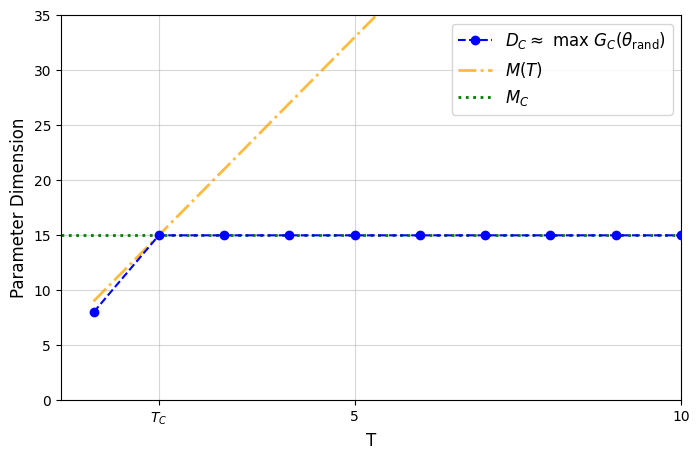

In [114]:
# Single threshold, single color
threshold = 1e-10
cmap = get_cmap("Set2")
color = cmap(0)

chosen_n_ctrl = 2
chosen_n_reserv = 3

def get_num_params(N_r, N_c, T):
    # Example: N_r*N_c*T + 3 + T, 
    # but you said you prefer N_r*N_c*T + 3 for now:
    return N_r * N_c * T + 3

# Suppose your DataFrame df_all has columns: 
#   'Trotter_Step', 'N_ctrl', 'N_reserv', 'ranks', etc.
# Filter for chosen N_ctrl and N_reserv
subset = df_all[(df_all['N_ctrl'] == chosen_n_ctrl) &
                (df_all['N_reserv'] == chosen_n_reserv)]

trotter_steps = []
max_ranks = []

for T_step, grp in subset.groupby('Trotter_Step'):
    all_ranks = []
    for _, row in grp.iterrows():
        # each row['ranks'] is a list of rank values
        all_ranks.extend(row['ranks'])
    
    # Use np.max instead of np.mean
    max_rank = np.max(all_ranks) if len(all_ranks) > 0 else 0
    trotter_steps.append(T_step)
    max_ranks.append(max_rank)

# Sort by Trotter step for a clean line plot
trotter_steps, max_ranks = zip(*sorted(zip(trotter_steps, max_ranks)))

# Also build arrays for M(T)
param_list = [get_num_params(chosen_n_reserv, chosen_n_ctrl, t) for t in trotter_steps]

###############################################################################
# Detect the "critical" T_C
###############################################################################
# For example, define T_C as the Trotter step where mean_rank is largest:
idx_C = int(np.argmax(max_ranks))
T_C = trotter_steps[idx_C]      # Trotter step at maximum rank
M_C = param_list[idx_C]         # number of parameters at that T step
print(f"param_list: {param_list}")
print(f"mean_ranks: {max_ranks}")
Dmax = max_ranks[idx_C]
print(f"Detected critical T_C = {T_C}, corresponding M_C = {M_C}")

###############################################################################
# Make the plot
###############################################################################
fig, ax = plt.subplots(figsize=(8, 5))

# 1) Plot D_C vs T
ax.plot(
    trotter_steps, max_ranks, marker='o', linestyle='--',
    color='b', label=r'$D_C \approx$ max $G_C(\theta_{\text{rand}})$',zorder=10,
)

# 2) Plot M(T)
ax.plot(
    trotter_steps, param_list, color="orange", linestyle='-.',
    alpha=0.75, linewidth=2, label='$M(T)$'
)

# 3) Plot a horizontal line at M_C
ax.axhline(y=M_C, color='green', linestyle=':', linewidth=2, label='$M_C$')

# 3) No vertical line. Instead, add an x‐tick labeled "T_C"
current_xticks = list(ax.get_xticks())  # existing ticks chosen by matplotlib
# Ensure T_C is added (if not already in the list)
if T_C not in current_xticks:
    current_xticks.append(T_C)

# Sort them for a nice ascending sequence
current_xticks = sorted(current_xticks)

# Convert ticks to strings, but replace T_C with "T_C"
xtick_labels = []
for tick in current_xticks:
    if tick == T_C:
        xtick_labels.append(r"$T_C$")  # label this tick specifically
    else:
        # If T is integer, show it as int; otherwise as float
        xtick_labels.append(str(int(tick)) if tick.is_integer() else f"{tick:.1f}")

ax.set_xticks(current_xticks)
ax.set_xticklabels(xtick_labels)
ax.set_xlabel('T', fontsize=12)
ax.set_ylabel('Parameter Dimension', fontsize=12)
ax.set_ylim(0, max(max(max_ranks), max(param_list)) * 1.1)  # pad top
ax.legend(fontsize=12,loc = 'upper right')
ax.grid(True, alpha=0.5)
ax.set_ylim(0,35)
ax.set_xlim(left=0.5, right=10)
# ax.set_ylim(bottom=0, top=max(max(max_ranks), max(param_list)) * 1.1)

plt.show()


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_54665/818915829.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("Set2")


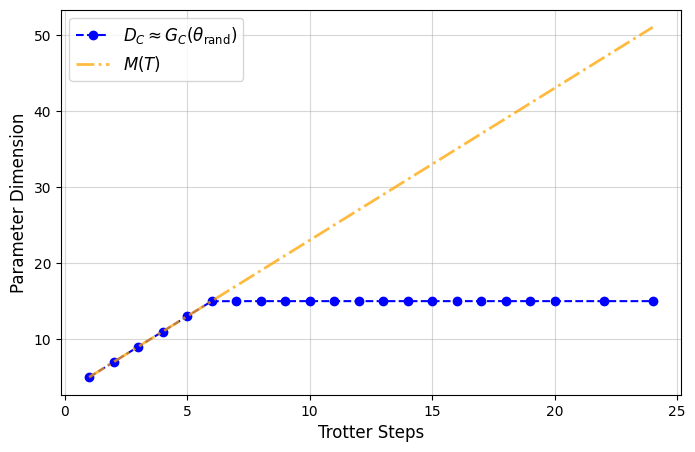

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap


# Define color map (we'll just use one color for our single threshold)
cmap = get_cmap("Set2")
color = cmap(0)

chosen_n_ctrl = 2   # e.g., pick your desired N_ctrl
chosen_n_reserv = 1 # e.g., pick your desired N_reserv

def get_num_params(N_r, N_c, T):
    return N_r * N_c * T + 3 

# Filter df_all for the chosen N_ctrl and N_reserv
subset = df_all[(df_all['N_ctrl'] == chosen_n_ctrl) & (df_all['N_reserv'] == chosen_n_reserv)]

###############################################################################
# PLOT 1: X-axis = Trotter Steps
###############################################################################
fig1, ax1 = plt.subplots(figsize=(8, 5))

trotter_steps = []
mean_ranks = []

# Group by Trotter step and compute mean rank
for T_step, grp in subset.groupby('Trotter_Step'):
    # Each row has a list of ranks in 'ranks'
    all_ranks = []
    for _, row in grp.iterrows():
        all_ranks.extend(row['ranks'])  # row['ranks'] is a list of ranks

    mean_rank = np.mean(all_ranks) if len(all_ranks) > 0 else 0

    trotter_steps.append(T_step)
    mean_ranks.append(mean_rank)

# Sort by trotter step for a clean line plot
trotter_steps, mean_ranks = (list(t) for t in zip(*sorted(zip(trotter_steps, mean_ranks))))

ax1.plot(
    trotter_steps, mean_ranks, marker='o', linestyle='--',
    color='b', label=r'$D_C \approx G_C(\theta_{\text{rand}})$'
)
trotter_list = []
param_list = []
for T_step in sorted(subset['Trotter_Step'].unique()):
    M_val = get_num_params(chosen_n_reserv, chosen_n_ctrl, T_step)
    trotter_list.append(T_step)
    param_list.append(M_val)
    

ax1.plot(trotter_list, param_list, color = "orange",linestyle='-.', alpha = 0.75,linewidth=2, zorder=10, label='$M(T)$')
ax1.set_xlabel('Trotter Steps', fontsize=12)
ax1.set_ylabel('Parameter Dimension', fontsize=12)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.5)
plt.show()

# ###############################################################################
# # PLOT 2: X-axis = Number of Parameters
# ###############################################################################
# fig2, ax2 = plt.subplots(figsize=(8, 5))

# param_counts = []
# mean_ranks = []

# for T_step, grp in subset.groupby('Trotter_Step'):
#     # Compute total number of parameters for this T_step
#     M = get_num_params(chosen_n_reserv, chosen_n_ctrl, T_step)
    
#     # Combine all ranks for this group
#     all_ranks = []
#     for _, row in grp.iterrows():
#         all_ranks.extend(row['ranks'])

#     mean_rank = np.mean(all_ranks) if len(all_ranks) > 0 else 0

#     param_counts.append(M)
#     mean_ranks.append(mean_rank)

# # Sort by M for a clean line plot
# param_counts, mean_ranks = (list(t) for t in zip(*sorted(zip(param_counts, mean_ranks))))

# ax2.plot(
#     param_counts, mean_ranks, marker='o', linestyle='--',
#     color='b', label=r'$D_C \approx G_C(\theta_{\text{rand}})$'
# )
# combined = sorted(zip(param_list, trotter_list))  # (M, T) pairs
# Mvals, Tvals = zip(*combined)

# ax2.plot(Mvals, Tvals, color = "orange",linestyle='-.', alpha = 0.75,linewidth=2, zorder=10, label='$T(M)$')
# ax2.set_xlabel('Number of Parameters $M$', fontsize=12)
# ax2.set_ylabel('Parameter Dimension', fontsize=12)
# ax2.legend(fontsize=12)
# ax2.grid(True, alpha=0.5)
# plt.show()



In [30]:
# Define thresholds
thresholds = [1e-10]

# Initialize empty columns in the DataFrame for each threshold
for threshold in thresholds:
    df_all[f'ranks_threshold_{threshold}'] = df_all['all_qfim_eigvals'].apply(
        lambda eigval_list: [len([val for val in eigvals if val > threshold]) for eigvals in eigval_list]
    )


In [33]:
df_all.keys()

Index(['mean_trace_eigvals', 'all_trace_eigvals', 'all_var_qigvals',
       'all_entropies', 'mean_entropy', 'quantum_dim', 'D_C',
       'mean_norm_trace_eigvals', 'ratios', 'redundancies',
       'global_redundancies', 'cond_nums', 'mean(cond_nums)',
       'median_trace_eigvals', 'iqr_trace_eigvals',
       'weighted_avg_trace_eigvals', 'mean_var_eigval', 'var_var_eigenvals',
       'median_var_eigval', 'iqr_var_eigval', 'weighted_avg_var_eigval',
       'mean_var_log_eigval', 'median_var_log_eigval', 'iqr_var_log_eigval',
       'weighted_avg_var_log_eigval', 'all_qfim_eigvals', 'N_param',
       'Avg_Fidelity', 'std', 'all_test_results', 'N_ctrl', 'N_reserv',
       'Trotter_Step', 'ranks', 'ranks_threshold_1e-10'],
      dtype='object')

15 previous rank: 15
6 48 15
trots to plot: range(1, 15)


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_54665/469929181.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("Set2")


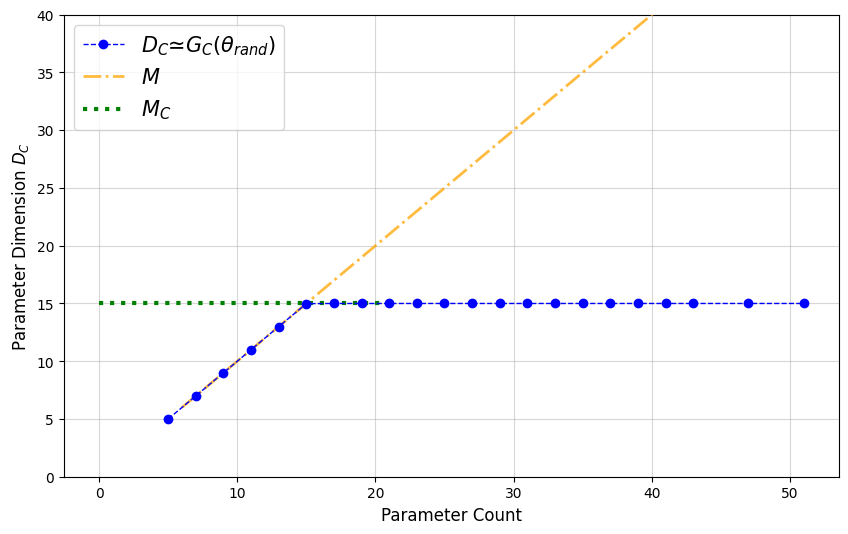

In [55]:
from matplotlib.cm import get_cmap
cmap = get_cmap("Set2")
plot_data = []
thresholds = [1e-10]
colors = [cmap(i) for i in range(len(thresholds))]
chosen_n_ctrl = 2  # Replace with your desired N_ctrl value
chosen_n_reserv = 1  # Replace with your desired N_reserv value
xaxis_scale = 'N_param'
# Filter results for the chosen N_ctrl and N_reserv
subset = df_all[(df_all['N_ctrl'] == chosen_n_ctrl) & (df_all['N_reserv'] == chosen_n_reserv)]
def get_num_params(N_r,N_c,T):
    return N_r*N_c*T + 3 + T

reached_overparam = False
for threshold in thresholds:
    column = f'ranks'
    for _, group in subset.groupby(xaxis_scale):
        max_rank = group[column].apply(lambda x: max(x) if x else 0).max()
        mean_rank = group[column].apply(lambda x: sum(x) / len(x) if x else 0).mean()
        plot_data.append((threshold, group[xaxis_scale].iloc[0], max_rank, mean_rank))


# Create a plot
fig, ax = plt.subplots(figsize=(10, 6))
for i, threshold in enumerate(thresholds):
    threshold_data = [(t, max_r, mean_r) for thr, t, max_r, mean_r in plot_data if thr == threshold]
    trotter_steps = [x[0] for x in threshold_data]
    max_ranks = [x[1] for x in threshold_data]
    for idx,r in enumerate(max_ranks):
       if r == max_ranks[idx-1] and not reached_overparam:
            print(r, f"previous rank: { max_ranks[idx-1]}")
            reached_overparam = True
            T_C = trotter_steps[idx-1]
            M_C = get_num_params(chosen_n_reserv,chosen_n_ctrl,T_C)
            idx_C = idx
            # T_C = 
    mean_ranks = [x[2] for x in threshold_data]

    # ax.plot(trotter_steps, max_ranks, label=f'G_C (threshold={threshold})', linestyle='-.', linewidth=2,color=colors[i])
    ax.plot(trotter_steps, mean_ranks, label=f'$D_C ≃ G_C(\\theta_{{rand}})$',marker='o',  linestyle='--', linewidth=1,color='b', zorder=12)
print(idx_C,M_C, T_C)
trots_to_plot = range(1,T_C)
print(f"trots to plot: {trots_to_plot}")
param_counts = [get_num_params(chosen_n_reserv,chosen_n_ctrl,T) for T in trots_to_plot]
# ax.plot(trots_to_plot, param_counts, color = "orange")
ax.plot(param_counts, param_counts, color = "orange",linestyle='-.', alpha = 0.75,linewidth=2, zorder=10, label='$M$')
M_plot = range(0,len(trotter_steps))
ax.plot(M_plot, [T_C]*len(M_plot), color='green',linestyle='dotted',linewidth=3,zorder=10, label='$M_C$')
# Customize plot
ax.set_xlabel('Parameter Count', fontsize=12)
ax.set_ylabel('Parameter Dimension $D_C$', fontsize=12)
# ax.set_title('Comparison of Max and Mean G_C for Different Thresholds', fontsize=14)
ax.legend(fontsize=15)
ax.set_ylim(0,40)
ax.set_xlim(0,40)
ax.grid(True,zorder=0, alpha=0.5)
plt.show()



15 previous rank: 15
3 78 15
trots to plot: range(1, 15)


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_54665/3615871947.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("Set2")


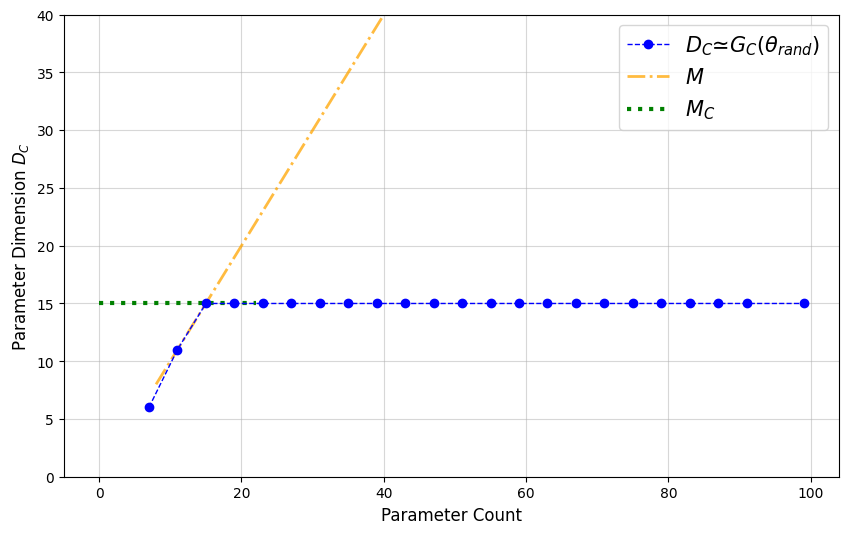

In [54]:
cmap = get_cmap("Set2")
plot_data = []
thresholds = [1e-10]
colors = [cmap(i) for i in range(len(thresholds))]
chosen_n_ctrl = 2  # Replace with your desired N_ctrl value
chosen_n_reserv = 2  # Replace with your desired N_reserv value
xaxis_scale = 'N_param'
# Filter results for the chosen N_ctrl and N_reserv
subset = df_all[(df_all['N_ctrl'] == chosen_n_ctrl) & (df_all['N_reserv'] == chosen_n_reserv)]
def get_num_params(N_r,N_c,T):
    return N_r*N_c*T + 3 + T

reached_overparam = False
for threshold in thresholds:
    column = f'ranks'
    for _, group in subset.groupby(xaxis_scale):
        max_rank = group[column].apply(lambda x: max(x) if x else 0).max()
        mean_rank = group[column].apply(lambda x: sum(x) / len(x) if x else 0).mean()
        plot_data.append((threshold, group[xaxis_scale].iloc[0], max_rank, mean_rank))


# Create a plot
fig, ax = plt.subplots(figsize=(10, 6))
for i, threshold in enumerate(thresholds):
    threshold_data = [(t, max_r, mean_r) for thr, t, max_r, mean_r in plot_data if thr == threshold]
    trotter_steps = [x[0] for x in threshold_data]
    max_ranks = [x[1] for x in threshold_data]
    for idx,r in enumerate(max_ranks):
       if r == max_ranks[idx-1] and not reached_overparam:
            print(r, f"previous rank: { max_ranks[idx-1]}")
            reached_overparam = True
            T_C = trotter_steps[idx-1]
            M_C = get_num_params(chosen_n_reserv,chosen_n_ctrl,T_C)
            idx_C = idx
            # T_C = 
    mean_ranks = [x[2] for x in threshold_data]

    # ax.plot(trotter_steps, max_ranks, label=f'G_C (threshold={threshold})', linestyle='-.', linewidth=2,color=colors[i])
    ax.plot(trotter_steps, mean_ranks, label=f'$D_C ≃ G_C(\\theta_{{rand}})$',marker='o',  linestyle='--', linewidth=1,color='b', zorder=12)
print(idx_C,M_C, T_C)
trots_to_plot = range(1,T_C)
print(f"trots to plot: {trots_to_plot}")
param_counts = [get_num_params(chosen_n_reserv,chosen_n_ctrl,T) for T in trots_to_plot]
# ax.plot(trots_to_plot, param_counts, color = "orange")
ax.plot(param_counts, param_counts, color = "orange",linestyle='-.', alpha = 0.75,linewidth=2, zorder=10, label='$M$')
M_plot = range(0,len(trotter_steps))
ax.plot(M_plot, [T_C]*len(M_plot), color='green',linestyle='dotted',linewidth=3,zorder=10, label='$M_C$')
# Customize plot
ax.set_xlabel('Parameter Count', fontsize=12)
ax.set_ylabel('Parameter Dimension $D_C$', fontsize=12)
# ax.set_title('Comparison of Max and Mean G_C for Different Thresholds', fontsize=14)
ax.legend(fontsize=15)
ax.grid(True,zorder=0, alpha=0.5)
ax.set_ylim(0,40)
plt.show()


In [10]:
data_df = df_all[df_all['N_ctrl'] == 2]
filt_df = data_df[data_df['Trotter_Step'] == 5]
# filt_df = data_df[(data_df['Trotter_Step'] == 2) & (data_df['Reservoir Count'] == 2)]

filt_df.head()

,mean_trace_eigvals,all_trace_eigvals,all_var_qigvals,all_entropies,mean_entropy,quantum_dim,D_C,mean_norm_trace_eigvals,ratios,redundancies,...,all_test_results,N_ctrl,N_reserv,Trotter_Step,ranks,ranks_threshold_1e-10,ranks_threshold_1e-11,ranks_threshold_1e-12,ranks_threshold_1e-13,ranks_threshold_1e-14


In [120]:
threshold = 1e-10


# Step 0: calculate effective quantum dimension max rank(QFIM)


# Create 'ranks' column for this threshold
df_all['QFIM_ranks'] = df_all['all_qfim_eigvals'].apply(
    lambda eigval_list: [sum(val > threshold for val in eigvals) for eigvals in eigval_list]
)

df_all['D_C'] = df_all['QFIM_ranks'].apply(
    lambda ranks: np.max(ranks) 
)

# Step 1: Calculate variance of QFIM eigenvalues per test before averaging


df_all['test_var_qfim_eigvals'] = df_all['all_qfim_eigvals'].apply(
    lambda eigval_list: [np.var(np.where(np.array(eigvals) < threshold, 0, eigvals)) for eigvals in eigval_list]
)
df_all['test_var_qfim_eigvals_nonzero'] = df_all['all_qfim_eigvals'].apply(
    lambda eigval_list: [np.var(np.array([val for val in eigvals if val > threshold]))  for eigvals in eigval_list]
)
df_all['test_tr_qfim_eigvals'] = df_all['all_qfim_eigvals'].apply(
    lambda eigval_list: [sum(np.where(np.array(eigvals) < threshold, 0, eigvals)) for eigvals in eigval_list]
)

# print(len(df_all['test_var_qfim_eigvals'][0]))
# Step 2: Calculate the average of these variances across all tests (average variance per test)
df_all['avg_test_var_qfim_eigvals'] = df_all['test_var_qfim_eigvals'].apply(
    lambda test_variances: np.mean(test_variances)  # Average over test variances
)

df_all['avg_test_var_qfim_eigvals_nonzero'] = df_all['test_var_qfim_eigvals_nonzero'].apply(
    lambda test_variances: np.mean(test_variances)  # Average over test variances
)


df_all['avg_test_tr_qfim_eigvals'] = df_all['test_tr_qfim_eigvals'].apply(
    lambda test_traces: np.mean(test_traces)  # Average over test variances
)

# Optionally, calculate the variance of the test variances as well
df_all['var_test_var_qfim_eigvals'] = df_all['test_var_qfim_eigvals'].apply(
    lambda test_variances: np.var(test_variances)  # Variance over test variances
)
df_all['var_test_var_qfim_eigvals_log'] = df_all['test_var_qfim_eigvals'].apply(
    lambda test_variances: np.log(np.var(test_variances))  # Variance over test variances
)
# Optionally, calculate the variance of the test variances as well
df_all['var_test_var_qfim_eigvals_nonzero'] = df_all['test_var_qfim_eigvals_nonzero'].apply(
    lambda test_variances: np.var(test_variances)  # Variance over test variances
)
# Apply the condition where values below the threshold are set to 0, and then calculate the mean
df_all['avg_qfim_eigvals'] = df_all['all_qfim_eigvals'].apply(
    lambda x: np.mean(np.where(np.array(x) < threshold, 0, np.array(x)), axis=0))

df_all['avg_qfim_eigvals_nonzero'] = df_all['avg_qfim_eigvals'].apply(
    lambda x: [val for val in x if val > threshold]
)

# df_all[['N_ctrl', 'var_test_var_qfim_eigvals_normalized', 'var_test_var_qfim_eigvals','mean_trace_eigvals','avg_test_tr_qfim_eigvals','Trotter_Step', 'N_reserv']].head()
df_all['test_var_qfim_eigvals_normalized_by_rank'] = df_all['all_qfim_eigvals'].apply(
    lambda eigval_list: [np.var(np.where(np.array(eigvals) < threshold, 0, eigvals))/max(1, np.sum(np.array(eigvals) > threshold)) for eigvals in eigval_list
                                ]
)


df_all['avg_test_var_qfim_eigvals_nonzero_normalized_by_rank'] = df_all['test_var_qfim_eigvals_normalized_by_rank'].apply(
    lambda test_variances: np.mean(test_variances)  # Average over test variances
)



df_all['test_var_qfim_eigvals_nonzero_normalized_by_rank'] = df_all['all_qfim_eigvals'].apply(
    lambda eigval_list: [np.var(np.array([val for val in eigvals if val > threshold]))/max(1, np.sum(np.array(eigvals) > threshold)) for eigvals in eigval_list
                                ]
)
df_all['avg_test_var_qfim_eigvals_normalized_by_rank'] = df_all['test_var_qfim_eigvals_normalized_by_rank'].apply(
    lambda test_variances: np.mean(test_variances)  # Average over test variances
)

df_all['test_var_qfim_eigvals_normalized'] = df_all['all_qfim_eigvals'].apply(
    lambda eigval_list: [np.var(np.where(np.array(eigvals) < threshold, 0, eigvals))/len(eigvals) for eigvals in eigval_list]
)

df_all['avg_test_var_qfim_eigvals_normalized'] = df_all['test_var_qfim_eigvals_normalized'].apply(
    lambda test_variances: np.mean(test_variances)  # Average over test variances
)


df_all['test_tr_qfim_eigvals'] = df_all['all_qfim_eigvals'].apply(
    lambda eigval_list: [sum(np.where(np.array(eigvals) < threshold, 0, eigvals)) for eigvals in eigval_list]
)

df_all['test_tr_qfim_eigvals_norm'] = df_all['all_qfim_eigvals'].apply(
    lambda eigval_list: [sum(np.where(np.array(eigvals) < threshold, 0, eigvals))/ len(eigvals) for eigvals in eigval_list]
)

df_all['test_tr_qfim_eigvals_norm_by_rank'] = df_all['all_qfim_eigvals'].apply(
    lambda eigval_list: [sum(np.where(np.array(eigvals) < threshold, 0, eigvals))/ max(1, np.sum(np.array(eigvals) > threshold)) for eigvals in eigval_list]
)

df_all['avg_test_tr_qfim_eigvals'] = df_all['test_tr_qfim_eigvals'].apply(
    lambda test_traces: np.mean(test_traces)  # Average over test variances
)

df_all['avg_test_tr_qfim_eigvals_norm'] = df_all['test_tr_qfim_eigvals_norm'].apply(
    lambda test_traces: np.mean(test_traces)  # Average over test variances
)

df_all['avg_test_tr_qfim_eigvals_norm_by_rank'] = df_all['test_tr_qfim_eigvals_norm_by_rank'].apply(
    lambda test_traces: np.mean(test_traces)  # Average over test variances
)

df_all['log_qfim_eigvals_nonzero'] = df_all['avg_qfim_eigvals_nonzero'].apply(
    lambda x: np.log(np.maximum(np.array(x), threshold))
)
df_all[['N_ctrl', 'log_qfim_eigvals_nonzero', 'Trotter_Step', 'N_reserv']].head()

min_val = df_all['mean_var_eigval'].min()
max_val = df_all['mean_var_eigval'].max()

# Apply normalization using the fixed min and max
df_all['normalized_var_qfim_eigvals'] = df_all['mean_var_eigval'].apply(
    lambda x: (x - min_val) / (max_val - min_val)
)
# Calculate variance of the log-transformed non-zero QFIM eigenvalues
df_all['var_log_qfim_eigvals_nonzero'] = df_all['log_qfim_eigvals_nonzero'].apply(
    lambda log_vals: np.var(log_vals)
)


In [121]:
def compute_ipr_dimension(eigvals, threshold=1e-10):
    """
    Compute the IPR-based dimension for a single array of eigenvalues:
       d_eff = (sum(eigvals)^2) / sum(eigvals^2)
    Only eigenvalues above 'threshold' are retained.
    """
    # Filter out small or zero eigenvalues
    filtered_vals = [val for val in eigvals if val > threshold]
    
    if len(filtered_vals) == 0:
        # If no eigenvalues are above threshold, dimension is effectively 0
        return 0.0
    
    sum_eigs = np.sum(filtered_vals)
    sum_eigs_sq = np.sum(np.square(filtered_vals))
    
    # Avoid division by zero if sum_eigs_sq happens to be extremely small
    if sum_eigs_sq == 0:
        return 0.0
    
    return (sum_eigs ** 2) / sum_eigs_sq

# Create a column test_ipr_dims, containing [ipr_dim_test_1, ipr_dim_test_2, ...] for each row
threshold = 1e-10

df_all['test_ipr_dims'] = df_all['all_qfim_eigvals'].apply(
    lambda list_of_eigval_arrays: [
        compute_ipr_dimension(eigvals, threshold=threshold)
        for eigvals in list_of_eigval_arrays
    ]
)

# Average IPR dimension across all tests in each row
df_all['avg_test_ipr_dim'] = df_all['test_ipr_dims'].apply(np.mean)

# Optionally compute the variance of test-wise IPR dims in each row
df_all['var_test_ipr_dim'] = df_all['test_ipr_dims'].apply(np.var)




   Trotter_Step  N_reserv  N_ctrl  mean_ipr_across_rows
0             1         1       1              1.449867
1             1         1       2              2.506845
2             1         2       1              1.631502
3             1         2       2              3.213423
4             1         3       1              1.392649


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_54665/1963806748.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotations = annotations.applymap(lambda val: f"{val:.2f}" if pd.notnull(val) else "")


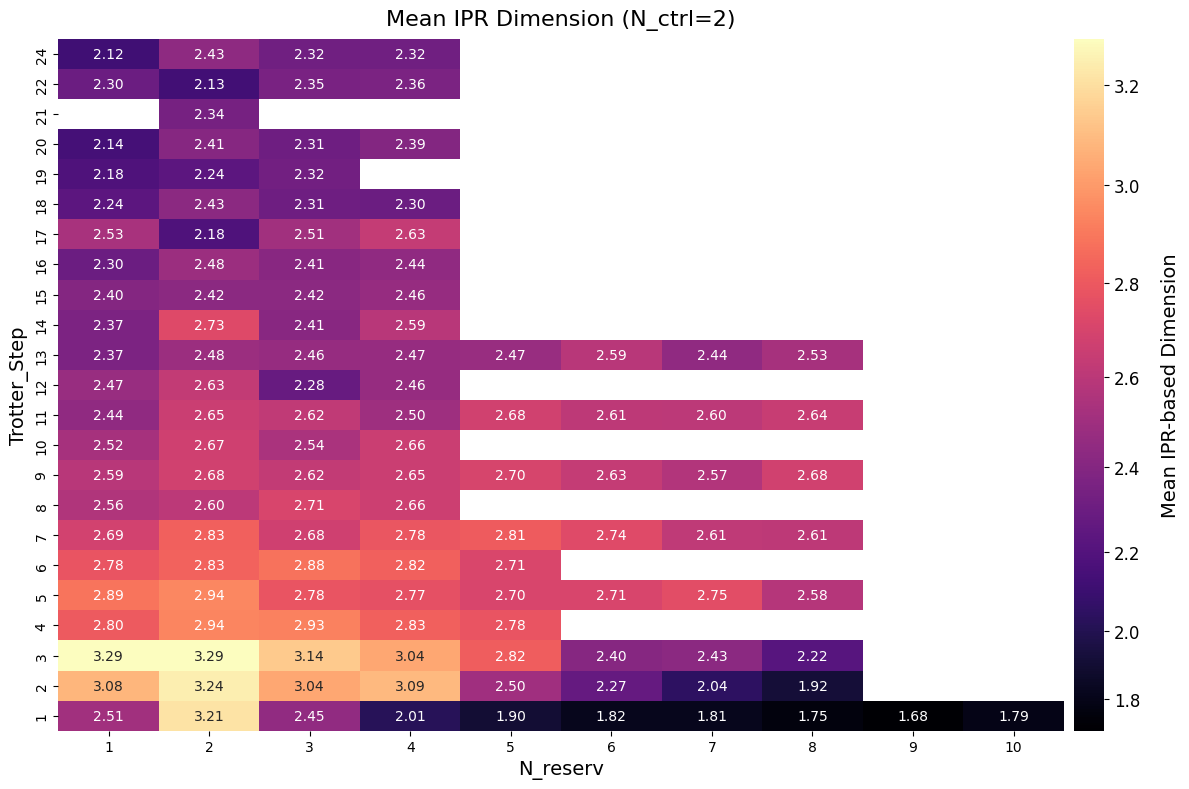

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import PowerNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

grouped = df_all.groupby(['Trotter_Step', 'N_reserv', 'N_ctrl'])
# grouped = df_all.groupby(group_cols)
summary_ipr = grouped['avg_test_ipr_dim'].mean().reset_index()
summary_ipr.rename(columns={'avg_test_ipr_dim': 'mean_ipr_across_rows'}, inplace=True)


print(summary_ipr.head())

N_ctrl_to_plot = 2
df_heatmap = summary_ipr[summary_ipr['N_ctrl'] == N_ctrl_to_plot].copy()

# Pivot so that Trotter_Step is rows, N_reserv is columns, and the values are mean_ipr_across_rows
heatmap_data = df_heatmap.pivot(index='Trotter_Step', columns='N_reserv', values='mean_ipr_across_rows')

#######################
# 6) Plot the Heatmap
#######################
fig, ax = plt.subplots(figsize=(12, 8))

# We'll use a 'magma' colormap with a PowerNorm to highlight differences
norm = PowerNorm(gamma=1.2, vmin=heatmap_data.min().min(), vmax=heatmap_data.max().max())

# For labeling each cell, create the string annotations
annotations = heatmap_data.copy()
annotations = annotations.applymap(lambda val: f"{val:.2f}" if pd.notnull(val) else "")

# Create a colorbar on the right
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

# Plot with seaborn
sns.heatmap(
    heatmap_data,
    cmap='magma',
    norm=norm,
    annot=annotations,  # annotation matrix
    fmt='s',            # interpret annotations as strings
    ax=ax,
    cbar_ax=cax
)

ax.invert_yaxis()
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Mean IPR-based Dimension", rotation=90, labelpad=15, fontsize=14)

ax.set_title(f"Mean IPR Dimension (N_ctrl={N_ctrl_to_plot})", fontsize=16, pad=10)
ax.set_ylabel("Trotter_Step", fontsize=14)
ax.set_xlabel("N_reserv", fontsize=14)

plt.tight_layout()
plt.show()


In [25]:
# df_all['normalized_var_power_scaled_avg_qfim_eigvals'] = df_all['var_power_scaled_avg_qfim_eigvals'].apply(
#     lambda x: (x - df_all['var_power_scaled_avg_qfim_eigvals'].min()) / 
#               (df_all['var_power_scaled_avg_qfim_eigvals'].max() - df_all['var_power_scaled_avg_qfim_eigvals'].min())
# )
# Normalize the raw variance of QFIM eigenvalues
# df_all['normalized_var_qfim_eigvals'] = df_all['mean_var_eigval'].apply(
#     lambda x: (x - df_all['mean_var_eigval'].min()) / 
#               (df_all['mean_var_eigval'].max() - df_all['mean_var_eigval'].min())
# )
# Precompute the global min and max for normalization

# Choose a scaling factor alpha
alpha = 0.75  # sqrt, adjust this between 0 and 1 depending on how much scaling you want

# Apply the power law transformation
df_all['power_scaled_avg_qfim_eigvals'] = df_all['avg_qfim_eigvals'].apply(
    lambda avg_vals: np.array(avg_vals) ** alpha
)
df_all['power_scaled_avg_qfim_eigvals_nonzero'] = df_all['avg_qfim_eigvals'].apply(
    lambda avg_vals: np.array([val for val in avg_vals if val > threshold]) ** alpha
)
# # Now calculate the variance of the power-scaled values and store it in a new column
df_all['var_power_scaled_avg_qfim_eigvals'] = df_all['power_scaled_avg_qfim_eigvals'].apply(
    lambda scaled_vals: np.var(scaled_vals)
)
df_all['var_power_scaled_avg_qfim_eigvals_nonzero'] = df_all['power_scaled_avg_qfim_eigvals_nonzero'].apply(
    lambda scaled_vals: np.var(scaled_vals)
)
# Multiply global_redundancies by N_params to calculate effective params
df_all['effective params'] = df_all.apply(
    lambda row: (1-row['global_redundancies'])* row['N_param'], axis=1
)

# df_all.head()


global_min: 5.0, global_max: 15.0


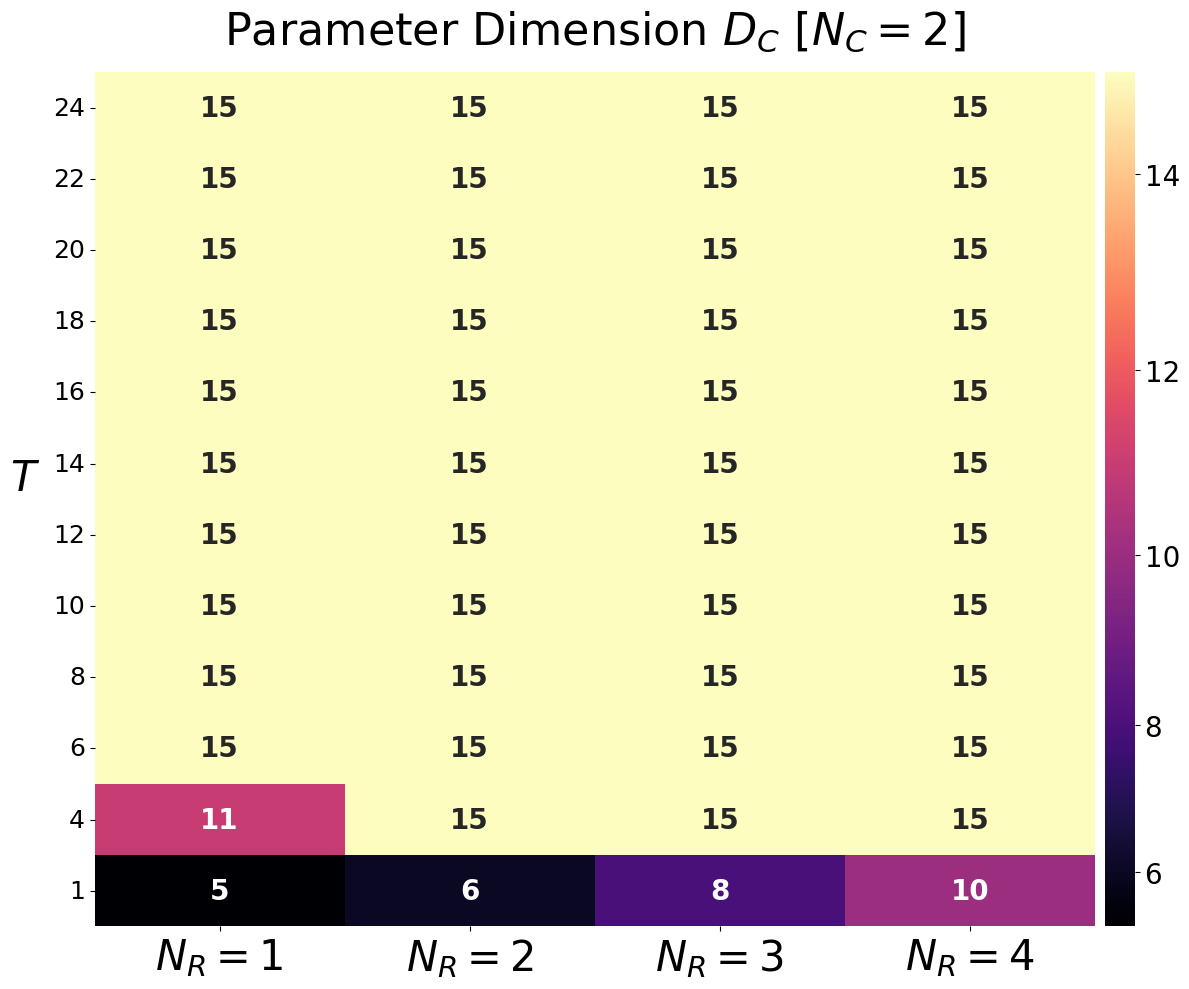

global_min: 2.014124092186688, global_max: 3.2134234818760894


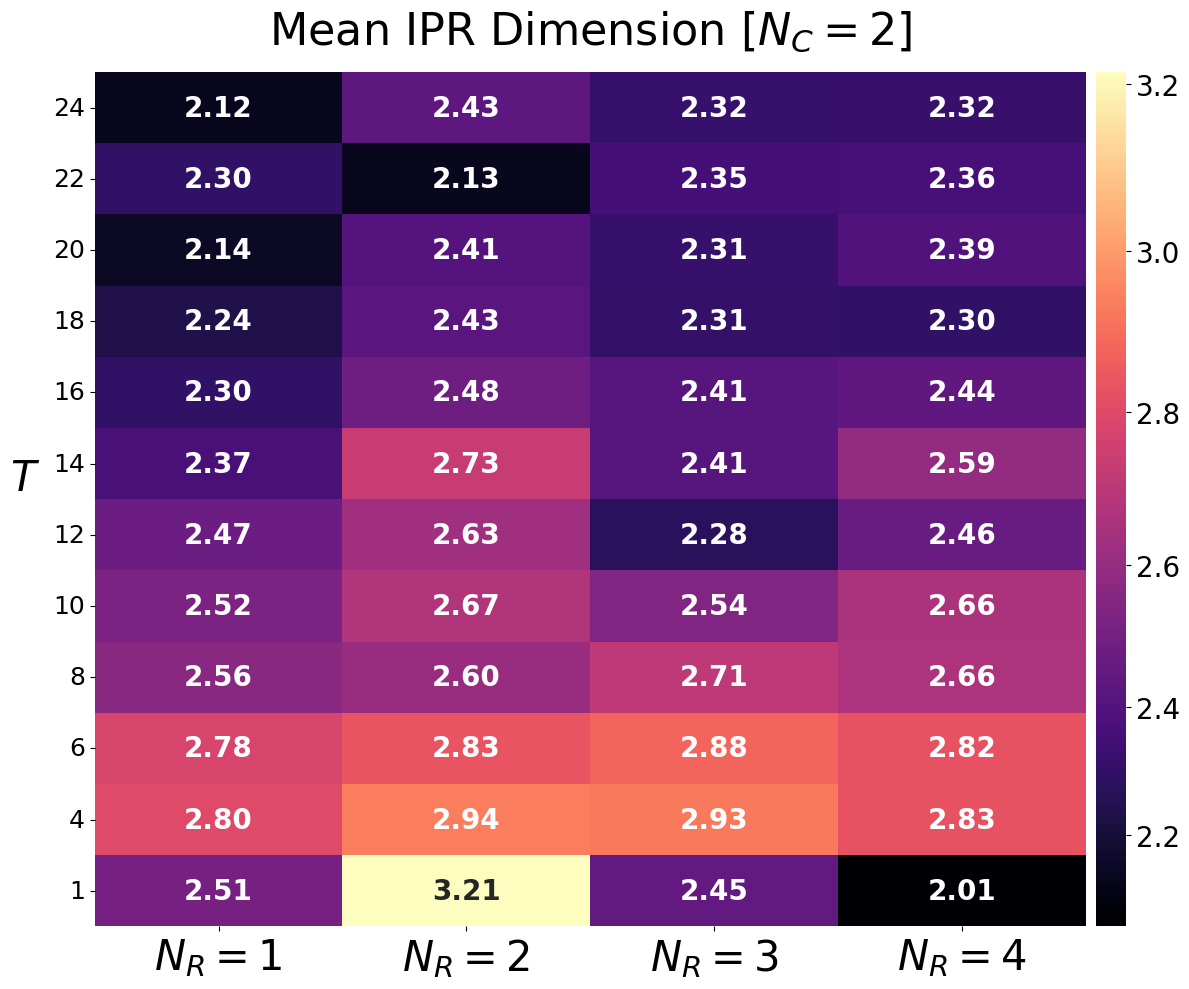

global_min: 0.42314677079008806, global_max: 7.9316174235930275


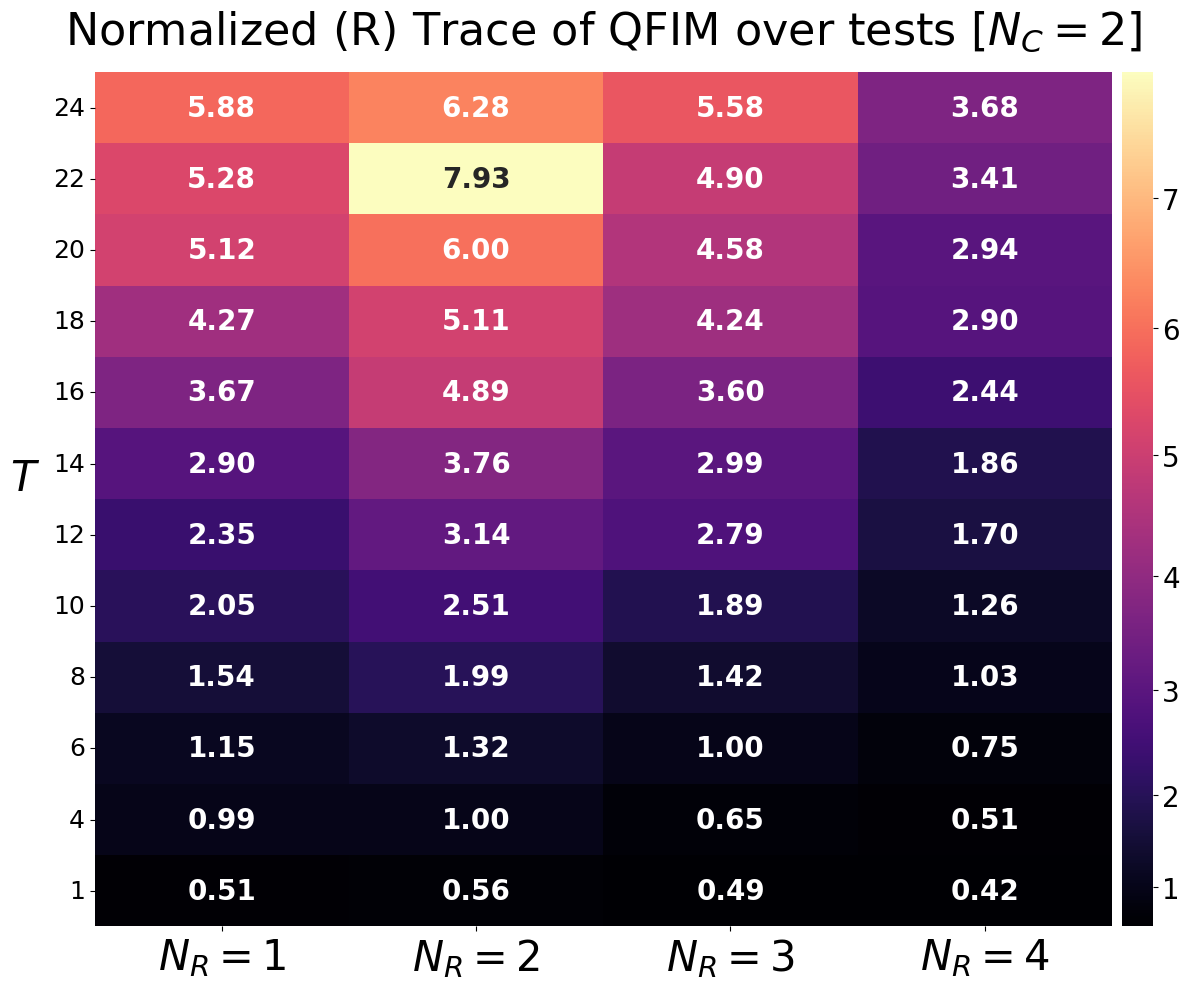

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import PowerNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

N_ctrl = 2
metric_keys = ['quantum_dim', 'D_C','var_power_scaled_avg_qfim_eigvals', 'avg_test_var_qfim_eigvals_normalized','var_test_var_qfim_eigvals_normalized']
metric_keys = ['avg_test_var_qfim_eigvals_normalized','var_test_var_qfim_eigvals_normalized','mean_norm_trace_eigvals','weighted_avg_trace_eigvals','avg_test_tr_qfim_eigvals']
# metric_keys = ['quantum_dim','redundancies','avg_test_var_qfim_eigvals_normalized','var_test_var_qfim_eigvals_normalized','weighted_avg_trace_eigvals']
# metric_keys = ['iqr_trace_eigvals','mean_norm_trace_eigvals','avg_test_tr_qfim_eigvals_norm_by_rank','quantum_dim']
metric_keys = ['D_C','quantum_dim','avg_test_tr_qfim_eigvals_norm_by_rank','avg_test_var_qfim_eigvals_nonzero','avg_test_var_qfim_eigvals_nonzero_normalized_by_rank', 'var_power_scaled_avg_qfim_eigvals','var_power_scaled_avg_qfim_eigvals_nonzero']
metric_keys = ['D_C', 'avg_test_ipr_dim','avg_test_tr_qfim_eigvals_norm_by_rank']
# metric_keys = ['quantum_dim','avg_test_var_qfim_eigvals', 'var_power_scaled_avg_qfim_eigvals','var_power_scaled_avg_qfim_eigvals_nonzero','var_test_var_qfim_eigvals','var_test_var_qfim_eigvals_log', 'avg_test_tr_qfim_eigvals']

# metric_titles = [
#     f'Trace(QFIM) ($N_C = {N_ctrl}$)',
#     f'Trace(QFIM) IQR ($N_C = {N_ctrl}$)',
#     f'VN Entropy ($N_C = {N_ctrl}$)',
#     f'Variance Non-Zero $\mathcal{{Q}}$ Eigenvalues IQR ($N_C = {N_ctrl}$)',

# ]
# metric_cbars = [
#     f'Tr($\mathcal{{Q}}$)',
#      f'Tr($\mathcal{{Q}}$)',
#     r'$S_{VN}$',
#     f'Var($\lambda_\mathcal{{Q}}$)',
# ]
resies = [1,2, 3]
metrics_info = {
    # Trace Metrics
    'mean_trace_eigvals': {
        'title': f'Mean Trace of QFIM [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_ipr_dim': {
        'title': f'Mean IPR Dimension [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_tr_qfim_eigvals': {
        'title': f'Trace of QFIM over tests [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_tr_qfim_eigvals_norm': {
        'title': f'Normalized Trace of QFIM over tests [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_tr_qfim_eigvals_norm_by_rank': {
        'title': f'Normalized (R) Trace of QFIM over tests [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'median_trace_eigvals': {
        'title': f'Median Trace of QFIM [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'iqr_trace_eigvals': {
        'title': f'IQR of Trace(QFIM) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'weighted_avg_trace_eigvals': {
        'title': f'Weighted Average of Trace(QFIM) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Variance of Eigenvalues
    'mean_var_eigval': {
        'title': f'Mean Variance of QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
     'avg_test_var_qfim_eigvals_nonzero': {
        'title': f'Mean Variance of QFIM Eigenvalues (nonzero) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_var_qfim_eigvals_normalized': {
        'title': f'Mean Variance of QFIM Eigenvalues (normalized) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_var_qfim_eigvals_nonzero_normalized_by_rank': {
        'title': f'Mean Variance of QFIM Eigenvalues (normalized by rank) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_var_qfim_eigvals_normalized_by_rank': {
        'title': f'Mean Variance of QFIM Eigenvalues (normalized by R) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'var_test_var_qfim_eigvals_nonzero': {
        'title': f'log Var(Variance of QFIM) over tsts (nonzero) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'avg_test_var_qfim_eigvals': {
        'title': f'Avg(Variance of QFIM) over tsts [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'median_var_eigval': {
        'title': f'Median Variance of QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'iqr_var_eigval': {
        'title': f'IQR of Variance(QFIM Eigenvalues) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'weighted_avg_var_eigval': {
        'title': f'Weighted Average Variance of QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'normalized_var_qfim_eigvals': {
        'title': f'Normalized Variance of QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'var_test_var_qfim_eigvals': {
        'title': f'Var(Variance of QFIM) over tsts  [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'var_test_var_qfim_eigvals_log': {
        'title': f'log(Var(Variance of QFIM)) over tsts  [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    # Variance of Log-Scaled Eigenvalues
    'mean_var_log_eigval': {
        'title': f'Mean Variance of log(QFIM Eigenvalues) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'median_var_log_eigval': {
        'title': f'Median Variance of log(QFIM Eigenvalues) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'iqr_var_log_eigval': {
        'title': f'IQR of Variance(log(QFIM Eigenvalues)) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'weighted_avg_var_log_eigval': {
        'title': f'Weighted Average Variance of log(QFIM Eigenvalues) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Entropy
    'mean_entropy': {
        'title': f'Mean Von Neumann Entropy [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'entropy': {
        'title': f'Von Neumann Entropy Distribution [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Condition Numbers
    'mean(cond_nums)': {
        'title': f'Mean Condition Number of QFIM [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'cond_nums': {
        'title': f'Condition Numbers of QFIM [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Eigenvalue Metrics
    'max_eigvals': {
        'title': f'Maximum QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'min_eigvals': {
        'title': f'Minimum QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Ratios and Redundancies
    'ratios': {
        'title': f'Ratio of Non-Zero Eigenvalues to Parameters [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'redundancies': {
        'title': f'Redundancy ($G_C$)[$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'global_redundancies': {
        'title': f'Global Redundancy ($R$) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Quantum Dimension
    'quantum_dim': {
        'title': f'Quantum Dimension $G_C$ (Rank) [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'D_C': {
        'title': f'Parameter Dimension $D_C$ [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'effective params': {
        'title': f'Effective Parameters [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    # Normalized Trace
    'mean_norm_trace_eigvals': {
        'title': f'Mean Normalized Trace of QFIM [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Power-Scaled Metrics
    'var_power_scaled_avg_qfim_eigvals': {
        'title': f'Power-Scaled Variance of QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    'var_power_scaled_avg_qfim_eigvals_nonzero': {
        'title': f'Power-Scaled Variance of Non-Zero QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Variance of Log Scaled Metrics
    'var_log_qfim_eigvals_nonzero': {
        'title': f'Variance of log(QFIM Eigenvalues) Non-Zero [$N_C = {N_ctrl}$]',
        'cbar': ''
    },
    
    # Trace Values Direct
    'trace_eigvals': {
        'title': f'Trace of QFIM Eigenvalues [$N_C = {N_ctrl}$]',
        'cbar': ''
    }
}

# resies = [1]
resies = [1, 2 ,3,4]

for idx,metric_key in enumerate(metric_keys):
    # Retrieve title and color bar from the dictionary
    metric_title = metrics_info[metric_key]['title']
    metric_cbar = metrics_info[metric_key]['cbar']
    
    # Filter the data for the current N_ctrl
    df_filtered = df_all[df_all['N_ctrl'] == N_ctrl][['N_reserv', 'Trotter_Step', f'{metric_key}']]
    
    if N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6]
        resies = [1, 2 ,3,4,5,6]
    elif N_ctrl == 3:
        trots = np.arange(1,60,1)
        resies = [1, 2 ,3,4,5,6]
    else:
        # trots = [1,2,3,4,5,6,8,9,10,12,14,16,18,20]
        trots = [1,4,6,8,10,12,14,16,18,20,22,24]
    # trots = np.arange(1,100,1)
    df_filtered = df_filtered[df_filtered['Trotter_Step'].isin(trots)]
    df_filtered = df_filtered[df_filtered['N_reserv'].isin(resies)]
    
    # Aggregate the data by Trotter_Step and N_reserv
    df_heatmap = df_filtered.groupby(['Trotter_Step', 'N_reserv']).agg({metric_key: 'mean'}).reset_index()
    min_val = df_heatmap[metric_key].min()

    max_val = df_heatmap[metric_key].max()
    # print(df_heatmap.keys())
    print(f"global_min: {min_val}, global_max: {max_val}")
    # Pivot the data to create a heatmap
    heatmap_pivot = df_heatmap.pivot(index='Trotter_Step', columns='N_reserv', values=metric_key)
    if metric_key in ['D_C']:
        # k = 0
        annotation_matrix = heatmap_pivot.map("{:.0f}".format)  # Ensures integer formatting

    else:
        # k = 2
        annotation_matrix = heatmap_pivot.map("{:.2f}".format)  # Ensures integer formatting

    

    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(12, 10))

    # Create a divider for the existing axes instance
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    if metric_key.startswith('var_power_scaled'):
        sns.heatmap(heatmap_pivot,annot=annotation_matrix,fmt="s", ax=ax,cbar_ax=cax,  cmap='magma', annot_kws={"weight": "bold", "size": 20},norm=PowerNorm(gamma=0.8, vmin=min_val, vmax=max_val))
    elif metric_key.endswith('_redundancies'):
        sns.heatmap(heatmap_pivot,annot=annotation_matrix,fmt="s", ax=ax,cbar_ax=cax,  cmap='magma', annot_kws={"weight": "bold", "size": 20},norm=PowerNorm(gamma=0.6, vmin=min_val, vmax=max_val))
    
    else:
        sns.heatmap(heatmap_pivot,annot=annotation_matrix,fmt="s", ax=ax,cbar_ax=cax,  cmap='magma', annot_kws={"weight": "bold", "size": 20},norm=PowerNorm(gamma=1.2, vmin=min_val, vmax=max_val))
    
    ax.invert_yaxis()
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)  # Adjust the color bar tick label size
    cbar.set_label(metric_cbar, rotation=0, labelpad=30, fontsize=20)  # Rotate and set label size and weight

    ax.set_title(metric_title, fontsize=32, pad = 20)
    ax.set_ylabel('$T$', labelpad=20, fontsize=30, rotation=0)
    ax.set_xlabel('', fontsize=20)
    ax.tick_params(axis='y', labelrotation=0, labelsize=18)
    ax.tick_params(axis='x', labelsize=18)
    ax.set_xticklabels([f'$N_R = {rc+1}$' for rc in range(len(ax.get_xticklabels()))], fontweight='bold', fontsize=30, rotation=0)
    plt.tight_layout()
    plt.show()
# /Users/sophieblock/QRCCapstone/QFIM_traced_trainable_global/gate_model_theorem23_eigval_decomp/Nc_1/GHZ_state/1xK/Nr_1/trotter_step_1/data.pickle

global_min: 5.0, global_max: 15.343636363636364
[ 4.  6.  8. 10. 12. 14. 16.]


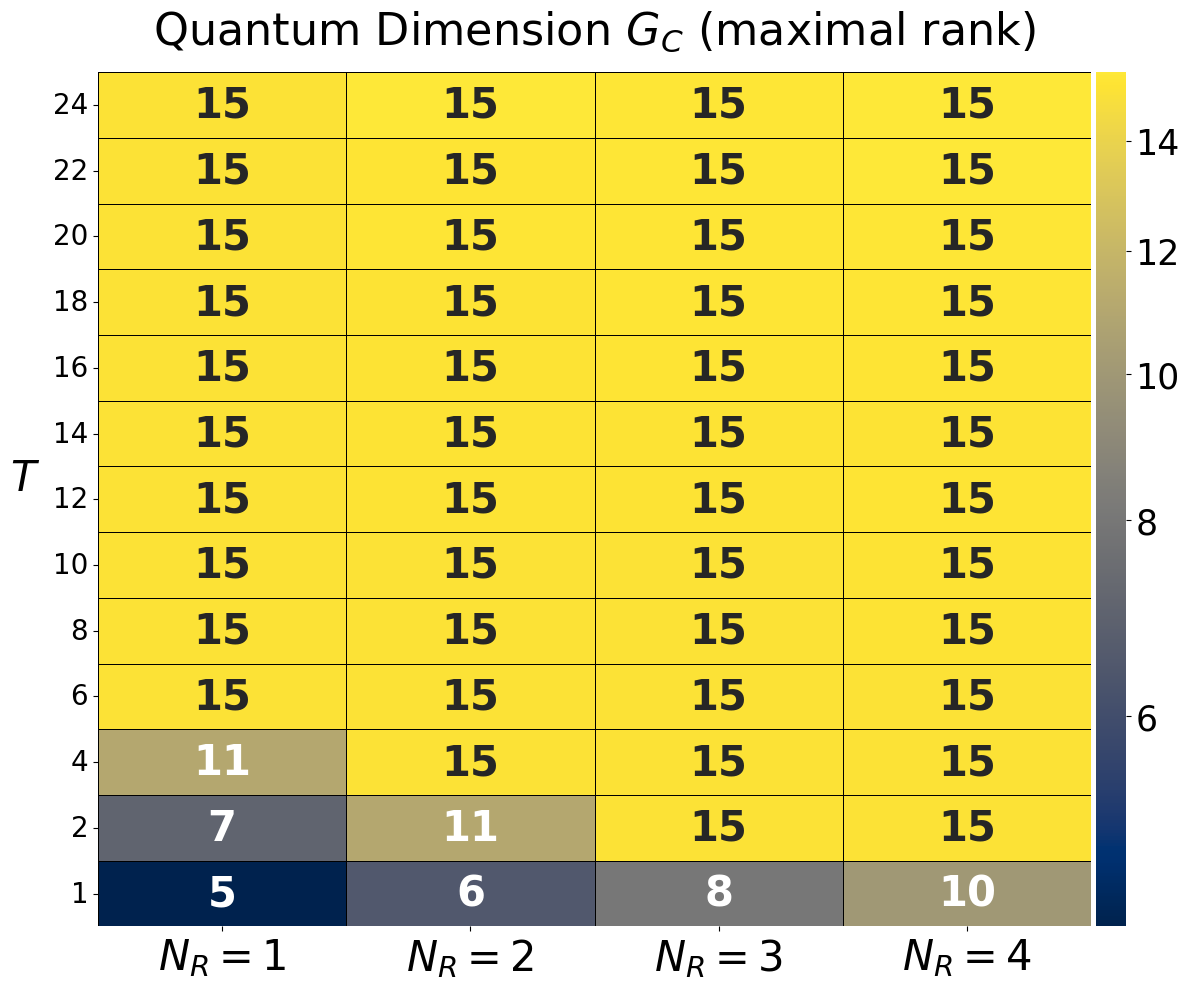

<Figure size 640x480 with 0 Axes>

In [14]:

metric_key = 'quantum_dim'
# metric_key = 'avg_test_tr_qfim_eigvals_norm_by_rank'
# metric_key = 'avg_test_var_qfim_eigvals_nonzero_normalized_by_rank'
metric_title = 'Quantum Dimension $G_C$ (maximal rank)'
# metric_title = r'Sum($\lambda_Q$)/ $G_C$'
# metric_title = r'Tr($Q$)'
# metric_title = r'Var($\lambda_Q$) Normalized by Quantum Dimension'
metric_cbar = ''

# Filter the data for the current N_ctrl
df_filtered = df_all[df_all['N_ctrl'] == N_ctrl][['N_reserv', 'Trotter_Step', f'{metric_key}']]

if N_ctrl == 1:
    trots = [1, 2, 3, 4, 5,6]
    resies = [1, 2 ,3,4,5,6]
else:
    trots = [1,2,4,6,8,10,12,14,16,18,20,22,24]
# trots = np.arange(1,100,1)
df_filtered = df_filtered[df_filtered['Trotter_Step'].isin(trots)]
df_filtered = df_filtered[df_filtered['N_reserv'].isin(resies)]

# Aggregate the data by Trotter_Step and N_reserv
df_heatmap = df_filtered.groupby(['Trotter_Step', 'N_reserv']).agg({metric_key: 'mean'}).reset_index()
min_val = df_heatmap[metric_key].min()

max_val = df_heatmap[metric_key].max()
# print(df_heatmap.keys())
print(f"global_min: {min_val}, global_max: {max_val}")
# Pivot the data to create a heatmap
heatmap_pivot = df_heatmap.pivot(index='Trotter_Step', columns='N_reserv', values=metric_key)
if metric_key in ['quantum_dim', 'D_C']:
    # k = 0
    annotation_matrix = heatmap_pivot.map("{:.0f}".format)  # Ensures integer formatting

else:
    # k = 2
    annotation_matrix = heatmap_pivot.map("{:.1f}".format)  # Ensures integer formatting



# Plot the heatmap
fig, ax = plt.subplots(figsize=(12, 10))

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)

sns.heatmap(heatmap_pivot,annot=annotation_matrix,fmt="s", ax=ax,cbar_ax=cax,  cmap='cividis',linewidth=0.5,linecolor="black", annot_kws={"weight": "bold", "size": 30},norm=PowerNorm(gamma=0.6, vmin=min_val, vmax=max_val))

ax.invert_yaxis()
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=25)  # Adjust the color bar tick label size
ticks = cbar.get_ticks()
print(ticks)
# cbar.set_ticklabels(['1','4','6','8','11','13','14','15'])
cbar.set_label(metric_cbar, rotation=0, labelpad=30, fontsize=25)  # Rotate and set label size and weight

ax.set_title(metric_title, fontsize=32, pad = 20)
ax.set_ylabel('$T$', labelpad=20, fontsize=30, rotation=0)
ax.set_xlabel('', fontsize=20)
ax.tick_params(axis='y', labelrotation=0, labelsize=20)
ax.tick_params(axis='x', labelsize=30)
ax.set_xticklabels([f'$N_R = {rc+1}$' for rc in range(len(ax.get_xticklabels()))], fontweight='bold', fontsize=30, rotation=0)
# fig.patch.set_edgecolor('black')
# fig.patch.set_linewidth(2)
plt.tight_layout()
plt.show()


plt.savefig('1q_digital_global_redundancy.png', bbox_inches='tight')

In [ ]:

metric_key = 'quantum_dim'
# metric_key = 'avg_test_tr_qfim_eigvals_norm_by_rank'
# metric_key = 'avg_test_var_qfim_eigvals_nonzero_normalized_by_rank'
metric_title = 'Quantum Dimension $G_C$ (maximal rank)'
# metric_title = r'Sum($\lambda_Q$)/ $G_C$'
# metric_title = r'Tr($Q$)'
# metric_title = r'Var($\lambda_Q$) Normalized by Quantum Dimension'
metric_cbar = ''

# Filter the data for the current N_ctrl
df_filtered = df_all[df_all['N_ctrl'] == N_ctrl][['N_reserv', 'Trotter_Step', f'{metric_key}']]

if N_ctrl == 1:
    trots = [1, 2, 3, 4, 5,6]
    resies = [1, 2 ,3,4,5,6]
else:
    trots = [1,2,4,6,8,10,12,14,16,18,20,22,24]
# trots = np.arange(1,100,1)
df_filtered = df_filtered[df_filtered['Trotter_Step'].isin(trots)]
df_filtered = df_filtered[df_filtered['N_reserv'].isin(resies)]

# Aggregate the data by Trotter_Step and N_reserv
df_heatmap = df_filtered.groupby(['Trotter_Step', 'N_reserv']).agg({metric_key: 'mean'}).reset_index()
min_val = df_heatmap[metric_key].min()

max_val = df_heatmap[metric_key].max()
# print(df_heatmap.keys())
print(f"global_min: {min_val}, global_max: {max_val}")
# Pivot the data to create a heatmap
heatmap_pivot = df_heatmap.pivot(index='Trotter_Step', columns='N_reserv', values=metric_key)
if metric_key in ['quantum_dim', 'D_C']:
    # k = 0
    annotation_matrix = heatmap_pivot.map("{:.0f}".format)  # Ensures integer formatting

else:
    # k = 2
    annotation_matrix = heatmap_pivot.map("{:.1f}".format)  # Ensures integer formatting



# Plot the heatmap
fig, ax = plt.subplots(figsize=(12, 10))

# Create a divider for the existing axes instance
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)

sns.heatmap(heatmap_pivot,annot=annotation_matrix,fmt="s", ax=ax,cbar_ax=cax,  cmap='inferno',linewidth=0.5,linecolor="black", annot_kws={"weight": "bold", "size": 30},norm=PowerNorm(gamma=0.6, vmin=min_val, vmax=max_val))

ax.invert_yaxis()
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=25)  # Adjust the color bar tick label size
ticks = cbar.get_ticks()
print(ticks)
# cbar.set_ticklabels(['1','4','6','8','11','13','14','15'])
cbar.set_label(metric_cbar, rotation=0, labelpad=30, fontsize=25)  # Rotate and set label size and weight

ax.set_title(metric_title, fontsize=32, pad = 20)
ax.set_ylabel('$T$', labelpad=20, fontsize=30, rotation=0)
ax.set_xlabel('', fontsize=20)
ax.tick_params(axis='y', labelrotation=0, labelsize=20)
ax.tick_params(axis='x', labelsize=30)
ax.set_xticklabels([f'$N_R = {rc+1}$' for rc in range(len(ax.get_xticklabels()))], fontweight='bold', fontsize=30, rotation=0)
# fig.patch.set_edgecolor('black')
# fig.patch.set_linewidth(2)
plt.tight_layout()
plt.show()


plt.savefig('1q_digital_global_redundancy.png', bbox_inches='tight')

In [ ]:
def get_qfim_eigvals(file_path, fixed_param_dict_key, trainable_param_dict_key):
    """
    Load data from a pickle file and return QFIM eigenvalues for the given fixed and trainable parameter dictionary keys.

    Parameters:
    - file_path: str or Path, the path to the pickle file.
    - fixed_param_dict_key: str, the key for the fixed parameters dictionary.
    - trainable_param_dict_key: str, the key for the trainable parameters dictionary.

    Returns:
    - qfim_eigvals: list of QFIM eigenvalues.
    """
    # Ensure file_path is a Path object
    file_path = Path(file_path) if not isinstance(file_path, Path) else file_path
    print(f"file_path: {file_path}")
    if not file_path.exists():
        print(f"File {file_path} does not exist.")
        return None

    with open(file_path, 'rb') as f:
        df = pickle.load(f)
    
    # Initialize variables
    qfim_eigvals = None
    
    for fixed_params_dict in df.keys():
        if fixed_params_dict == fixed_param_dict_key:
            for trainable_params_dict in df[fixed_params_dict].keys():
                if trainable_params_dict == trainable_param_dict_key:
                    results = df[fixed_params_dict][trainable_params_dict]
                    if 'qfim_eigvals' in results:
                        qfim_eigvals = results['qfim_eigvals']
                        fixed_params = results['K_coeffs']
                        try:
                            jacobian = results['jacobian']
                            det = results['det']
                        except KeyError:
                            jacobian = None
                            det = None
                        # entropy = results['entropy']
                        qfim = results['qfim']
                        params = results['trainable_params']
                        # entropies = results['entropies']
                       
                        return qfim_eigvals,fixed_params,params,qfim,None,None
    
    print("QFIM eigenvalues not found for the given parameter keys.")
    return None,None,None, None,None

fp1 = '/Users/so714f/Documents/offline/qrc/gate_model_theorem23_eigval_decomp/Nc_1/GHZ_state/1xK/Nr_1/trotter_step_1/data.pickle'
fp2 = ''
_,fixed_params,_,_,_,_ = get_qfim_eigvals(fp1, 'fixed_params0', 'test0')
print(fixed_params)
_,fixed_params,_,_,_,_ = get_qfim_eigvals(fp1, 'fixed_params2', 'test0')
print(fixed_params)

In [ ]:
for metric_key in metric_keys:
    # Retrieve title and color bar from the dictionary
    metric_title = metrics_info[metric_key]['title']
    metric_cbar = metrics_info[metric_key]['cbar']
    
    # Filter the data for the current N_ctrl
    df_filtered = df_all[df_all['N_ctrl'] == N_ctrl][['N_reserv', 'Trotter_Step', f'{metric_key}']]
    
    if N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    else:
        trots = [1, 4, 6, 8, 10, 12, 14, 16, 20, 24]
    
    df_filtered = df_filtered[df_filtered['Trotter_Step'].isin(trots)]
    df_filtered = df_filtered[df_filtered['N_reserv'].isin(resies)]
    
    # Aggregate the data by Trotter_Step and N_reserv
    df_heatmap = df_filtered.groupby(['Trotter_Step', 'N_reserv']).agg({metric_key: 'mean'}).reset_index()
    
    # Pivot the data to create a heatmap
    heatmap_pivot = df_heatmap.pivot(index='Trotter_Step', columns='N_reserv', values=metric_key)
    
    # Apply normalization only for specific metrics
    if metric_key == 'normalized_var_qfim_eigvals':  # Adjust this based on keys requiring normalization
        heatmap_pivot = (heatmap_pivot - heatmap_pivot.min().min()) / (heatmap_pivot.max().max() - heatmap_pivot.min().min())
    
    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(8, 5))

    # Create a divider for the existing axes instance
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)

    sns.heatmap(heatmap_pivot, ax=ax, cbar_ax=cax, cmap='magma', annot=True, fmt=".4f", annot_kws={"weight": "bold", "size": 18})
    ax.invert_yaxis()
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=16)  # Adjust the color bar tick label size
    cbar.set_label(metric_cbar, rotation=0, labelpad=30, fontsize=20)  # Rotate and set label size and weight

    ax.set_title(metric_title, fontsize=25)
    ax.set_ylabel('$T$', labelpad=20, fontsize=20, rotation=0)
    ax.set_xlabel('', fontsize=20)
    ax.tick_params(axis='y', labelrotation=0, labelsize=18)
    ax.tick_params(axis='x', labelsize=18)
    ax.set_xticklabels([f'$N_R = {rc+1}$' for rc in range(len(ax.get_xticklabels()))], fontweight='bold', fontsize=20, rotation=0)
    plt.tight_layout()
    plt.show()


In [ ]:
# Assuming df_all is already defined and contains the relevant data
N_ctrl = 1
metric_key = 'mean_trace_eigvals'  # Change this if you want to use a different metric
metric_title = f'Tr(QFIM) $N_C = {N_ctrl}$'

# Filter the data for the selected N_ctrl
df_filtered = df_all[df_all['N_ctrl'] == N_ctrl]

# Plot using seaborn.lineplot
fig, ax1 = plt.subplots(figsize=(10, 6))

custom_palette = ['dodgerblue', 'gold', 'violet']

# Plot Tr(QFIM) on the left y-axis for each reservoir count
for i, res in enumerate([1, 2, 3]):
    df_res = df_filtered[df_filtered['N_reserv'] == res]
    sns.lineplot(
        x='Trotter_Step', 
        y=metric_key, 
        data=df_res, 
        label=f'$N_R = {res}$', 
        errorbar='sd', 
        linewidth=2, 
        ax=ax1, 
        color=custom_palette[i]
    )

# Configure left y-axis
ax1.set_title(metric_title, fontsize=20)
ax1.set_xlabel('Number of Trainable Parameters', fontsize=14)
ax1.set_ylabel(r'Tr($\mathcal{Q}$)', fontsize=14, color='dodgerblue')
ax1.tick_params(axis='y', labelcolor='dodgerblue')

# Add a secondary y-axis for log(1 - Avg Fidelity)
ax2 = ax1.twinx()

# Plot log(1 - Avg_Fidelity) on the secondary y-axis for each reservoir count
for i, res in enumerate([1, 2, 3]):
    df_res = df_filtered[df_filtered['N_reserv'] == res]
    
    # Calculate log(1 - Avg_Fidelity) and add it as a temporary column
    df_res['log_1_minus_fidelity'] = np.log10(1 - df_res['Avg_Fidelity'])
    
    sns.lineplot(
        x='Trotter_Step', 
        y='log_1_minus_fidelity', 
        data=df_res, 
        errorbar='sd', 
        linestyle="--", 
        ax=ax2, 
        color=custom_palette[i],
        legend=False
    )

# Configure right y-axis
ax2.set_ylabel(r'$\log(1 - \bar{F})$', fontsize=14, color='violet')
ax2.tick_params(axis='y', labelcolor='violet')

# Adjust legends and layout
ax1.legend(title='$N_R$', fontsize=12, title_fontsize=14)
plt.grid(True)
sns.despine(ax=ax1, right=False)
plt.tight_layout()
plt.show()




In [ ]:
# Filter the data for the selected N_ctrl
df_filtered = df_all[df_all['N_ctrl'] == N_ctrl]

# Explode the 'all_trace_eigvals' column
df_exploded = df_filtered.explode('all_trace_eigvals', ignore_index=True)
df_exploded['all_trace_eigvals'] = df_exploded['all_trace_eigvals'].astype(float)

# Filter for specific N_reserv counts
selected_reserv_counts = [1, 2, 3]
df_exploded = df_exploded[df_exploded['N_reserv'].isin(selected_reserv_counts)]
df_filtered = df_filtered[df_filtered['N_reserv'].isin(selected_reserv_counts)]

# Merge the exploded data with the fidelity data on relevant columns
df_combined = pd.merge(
    df_exploded[['Trotter_Step', 'N_reserv', 'all_trace_eigvals']],
    df_filtered[['Trotter_Step', 'N_reserv', 'Avg_Fidelity']],
    on=['Trotter_Step', 'N_reserv']
)

# # Plot Tr(QFIM) on the left y-axis
# sns.lineplot(
#     x="Trotter_Step", 
#     y="all_trace_eigvals", 
#     data=df_combined,
#     hue="N_reserv",
#     ax=ax1,
#     palette=custom_palette,
#     errorbar="sd"
# )
# Plot
fig, ax1 = plt.subplots(figsize=(14, 8))
custom_palette = ['dodgerblue', 'gold', 'violet']

# Calculate IQR for Tr(QFIM)
for i, res in enumerate([1, 2, 3]):
    df_res = df_combined[df_combined['N_reserv'] == res]
    
    grouped = df_res.groupby('Trotter_Step')['all_trace_eigvals']
    q1 = grouped.quantile(0.25)  # 25th percentile
    q3 = grouped.quantile(0.75)  # 75th percentile
    median = grouped.median()
    
    ax1.plot(median.index, median.values, label=f'$N_R = {res}$', color=custom_palette[i], linewidth=2)
    ax1.fill_between(median.index, q1.values, q3.values, color=custom_palette[i], alpha=0.2, label=f'IQR $N_R={res}$')

# Configure left y-axis
ax1.set_title(metric_title, fontsize=20)
ax1.set_xlabel('Trotter Step', fontsize=14)
ax1.set_ylabel(r'Tr($\mathcal{Q}$)', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=16)
# Configure left y-axis
ax1.set_title(metric_title, fontsize=20)
ax1.set_xlabel('Trotter Step', fontsize=14)
ax1.set_ylabel(r'Tr($\mathcal{Q}$)', fontsize=25)
ax1.tick_params(axis='both', which='major',labelsize=16)
# ax.tick_params(axis='both', which='major', labelsize=16)  # Make tick labels larger

# # Add secondary y-axis for fidelity
# ax2 = ax1.twinx()
# sns.lineplot(
#     x="Trotter_Step", 
#     y="Avg_Fidelity", 
#     data=df_combined,
#     hue="N_reserv",
#     ax=ax2,
#     palette=['red', 'red', 'red'],
#     errorbar="sd",
#     linestyle="--", 
#     legend=False
# )
# Add a secondary y-axis for log-infidelity
# Add a column for log(1 - Avg_Fidelity) in the combined DataFrame
df_combined['log_infidelity'] = np.log10(1 - df_combined['Avg_Fidelity'].clip(upper=0.9999))

ax2 = ax1.twinx()
# sns.lineplot(
#     x="Trotter_Step", 
#     y="log_infidelity", 
#     hue="N_reserv", 
#     data=df_combined, 
#     ax=ax2, 
#     palette=['firebrick', 'darkorange', 'purple'], 
#     linestyle="--", 
#     ci="sd", 
#     legend=False
# )

for i, res in enumerate([1, 2, 3]):
    df_res = df_combined[df_combined['N_reserv'] == res]
    
    
    sns.regplot(
        x='Trotter_Step', 
        y='log_infidelity', 
        data=df_res, 

      
        ax=ax2, 
        color=custom_palette[i],
        # robust=True,
        lowess=True,
        # order=3
    )
# Configure right y-axis
# Configure right y-axis
ax2.set_ylabel(r'$\log_{10}(1 - \mathcal{F})$', fontsize=16, color='firebrick')
ax2.tick_params(axis='y', labelcolor='firebrick', labelsize=14)
y_ticks = ax2.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
min_tick = min(whole_y_ticks)
max_tick = max(whole_y_ticks)
whole_y_ticks = np.arange(min_tick, max_tick , 1)
ax2.set_yticks(whole_y_ticks)
ax2.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])
# Adjust legends
ax1.legend(title='$N_R$', fontsize=12, title_fontsize=14, loc='upper left')

# Finalize aesthetics
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine(ax=ax1, right=False)
plt.tight_layout()
plt.show()



In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess
# Assuming df_all is already defined and contains the relevant data
N_ctrl = 2
metric_key = 'mean_trace_eigvals'  # Change this if you want to use a different metric
metric_title = f'Tr(QFIM) $N_C = {N_ctrl}$'



# Filter the data for the selected N_ctrl
df_filtered = df_all[df_all['N_ctrl'] == N_ctrl]

# Explode the 'all_trace_eigvals' column
df_exploded = df_filtered.explode('all_trace_eigvals', ignore_index=True)
df_exploded['all_trace_eigvals'] = df_exploded['all_trace_eigvals'].astype(float)

# Filter for specific N_reserv counts
selected_reserv_counts = [1, 2, 3]
df_exploded = df_exploded[df_exploded['N_reserv'].isin(selected_reserv_counts)]
df_filtered = df_filtered[df_filtered['N_reserv'].isin(selected_reserv_counts)]

# Merge the exploded data with the fidelity data on relevant columns
df_combined = pd.merge(
    df_exploded[['Trotter_Step', 'N_reserv', 'all_trace_eigvals']],
    df_filtered[['Trotter_Step', 'N_reserv', 'Avg_Fidelity', 'all_test_results']],
    on=['Trotter_Step', 'N_reserv']
)
df_combined['avg_log_infidelity'] = np.log10(1 - df_combined['Avg_Fidelity'].clip(upper=0.9999999))

# df_combined['log_infidelities'] = df_combined['all_test_results'].apply(
#     lambda test_res: [np.log10(1 - np.mean(res)) for res in test_res]
# )
# # Explode log_infidelities to align with individual Trotter_Step and N_reserv
# df_exploded_logs = df_combined.explode('log_infidelities', ignore_index=True)
# Explode 'all_test_results' to handle each individual test result
# Explode all_test_results to handle each individual test result
df_combined = df_combined.explode('all_test_results', ignore_index=True)

# Calculate log10(1 - fidelity) for each test result
df_combined['log_infidelities'] = df_combined['all_test_results'].apply(
    lambda res: np.log10(1 - res)
)

# Ensure all_trace_eigvals is properly exploded
df_combined = df_combined.explode('all_trace_eigvals', ignore_index=True)
df_combined['all_trace_eigvals'] = df_combined['all_trace_eigvals'].astype(float)

errorbar="ci"
# # Plot
# fig, ax1 = plt.subplots(figsize=(14, 8))
# custom_palette = ['dodgerblue', 'gold', 'violet']

# # Plot Tr(QFIM) on the left y-axis
# sns.lineplot(
#     x="Trotter_Step", 
#     y="all_trace_eigvals", 
#     data=df_combined,
#     hue="N_reserv",
#     ax=ax1,
#     palette=custom_palette,
#     errorbar=errorbar,
#     linewidth=2
# )
# Plot
fig, ax1 = plt.subplots(figsize=(14, 8))
custom_palette = ['dodgerblue', 'gold', 'violet']

# Calculate IQR for Tr(QFIM)
for i, res in enumerate([1, 2, 3]):
    df_res = df_combined[df_combined['N_reserv'] == res]
    
    grouped = df_res.groupby('Trotter_Step')['all_trace_eigvals']
    q1 = grouped.quantile(0.25)  # 25th percentile
    q3 = grouped.quantile(0.75)  # 75th percentile
    median = grouped.median()
    
    ax1.plot(median.index, median.values, label=f'$N_R = {res}$', color=custom_palette[i], linewidth=2)
    ax1.fill_between(median.index, q1.values, q3.values, color=custom_palette[i], alpha=0.2, label=f'IQR $N_R={res}$')

# Configure left y-axis
ax1.set_title(metric_title, fontsize=20)
ax1.set_xlabel('Trotter Step', fontsize=14)
ax1.set_ylabel(r'Tr($\mathcal{Q}$)', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=16)

# Configure left y-axis
ax1.set_title(metric_title, fontsize=20)
ax1.set_xlabel('Trotter Step', fontsize=14)
ax1.set_ylabel(r'Tr($\mathcal{Q}$)', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=16)

# Add secondary y-axis for log_infidelity
ax2 = ax1.twinx()

for i, res in enumerate([1, 2, 3]):
    df_res = df_combined[df_combined['N_reserv'] == res]
    
    # Apply LOWESS for smooth fitting
    lowess_fitted = lowess(
        df_res['log_infidelities'].values,  # Ensure 1D array
        df_res['Trotter_Step'].values,     # Ensure 1D array
        frac=0.25
    )
    sns.scatterplot(
        x='Trotter_Step', 
        y='avg_log_infidelity', 
        data=df_res, 
        ax=ax2, 
        color=custom_palette[i],
        alpha=0.6,
        label=f'$N_R = {res}$',
        marker='o',
    )
    ax2.plot(lowess_fitted[:, 0], lowess_fitted[:, 1], color=custom_palette[i], linestyle="--", linewidth=2)

# Configure right y-axis
ax2.set_ylabel(r'$\log_{10}(1 - \mathcal{F})$', fontsize=16, color='firebrick')
ax2.tick_params(axis='y', labelcolor='firebrick', labelsize=14)
y_ticks = ax2.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
min_tick = min(whole_y_ticks)
max_tick = max(whole_y_ticks)
whole_y_ticks = np.arange(min_tick, max_tick , 1)
ax2.set_yticks(whole_y_ticks)
ax2.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])
ax2.grid(False)

# Adjust legends and layout
ax1.legend(title='$N_R$', fontsize=12, title_fontsize=14, loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine(ax=ax1, right=False)
plt.tight_layout()
plt.show()



In [ ]:
def debug_res(test_res):
    for res in test_res:
        print(f"res type: {type(res)}, res length: {len(res) if isinstance(res, (list, np.ndarray)) else 'N/A'}")
        print(f"Sample res values: {res[:5] if isinstance(res, (list, np.ndarray)) else res}")
        print(f"Mean of res: {np.mean(res) if isinstance(res, (list, np.ndarray)) else 'N/A'}")
        print('-' * 40)
        # Return the processed value to avoid altering the logic
        return [np.log10(1 - np.clip(np.mean(res), None, 0.9999999)) for res in test_res]

df_combined['log_infidelities'] = df_combined['all_test_results'].apply(debug_res)

In [ ]:
N_ctrl = 2
# Filter the data for the selected N_ctrl
df_filtered = df_all[df_all['N_ctrl'] == N_ctrl]

#  Optional: Verify the result
print(df_filtered[['all_trace_eigvals', 'N_reserv', 'N_param']].head())

In [ ]:
N_ctrl = 2
# errorbar=("pi", 50)
errorbar="ci"
# errorbar="pi"
# Filter the data for the selected N_ctrl
df_filtered = df_all[df_all['N_ctrl'] == N_ctrl]

# Explode the 'all_trace_eigvals' column to have one value per row
df_exploded = df_filtered.explode('all_trace_eigvals', ignore_index=True)

# Ensure the 'all_trace_eigvals' values are numeric
df_exploded['all_trace_eigvals'] = df_exploded['all_trace_eigvals'].astype(float)
# Filter the DataFrame for specific N_reserv values (e.g., only 1 and 3)
selected_reserv_counts = [1,2,3]  # Specify which N_reserv counts to show
df_exploded = df_exploded[df_exploded['N_reserv'].isin(selected_reserv_counts)]

# Plot using seaborn.lineplot
custom_palette = ['dodgerblue', 'gold', 'violet']  # Customize as needed

fig, ax = plt.subplots(figsize=(14, 8))
ax.tick_params(axis='both', which='major', labelsize=16)  # Make tick labels larger

sns.lineplot(
    x="N_param", 
    y="all_trace_eigvals", 
    data=df_exploded,
    hue="N_reserv",
    ax=ax,
    palette=custom_palette,  # Use custom colors
    errorbar=errorbar
)



# Set labels and title
plt.title(metric_title, fontsize=30)
plt.xlabel('Number of Trainable Parameters', fontsize=25)
plt.ylabel(r'Tr($\mathcal{Q}$)', fontsize=25)
plt.legend(title='$N_R$', fontsize=12, title_fontsize=25)
plt.grid(True)
# sns.despine()
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(14, 8))
ax.tick_params(axis='both', which='major', labelsize=16)  # Make tick labels larger

sns.lineplot(
    x="Trotter_Step", 
    y="all_trace_eigvals", 
    data=df_exploded,
    hue="N_reserv",
    ax=ax,
    palette=custom_palette,  # Use custom colors
    errorbar=errorbar
    # errorbar=("pi", 50)
)

# Set labels and title
plt.title(metric_title, fontsize=30)
plt.xlabel(r'$T$', fontsize=25)
plt.ylabel(r'Tr($\mathcal{Q}$)', fontsize=25)
plt.legend(title='$N_R$', fontsize=12, title_fontsize=25)
plt.grid(True)
# sns.despine()
plt.tight_layout()
plt.show()

<b> Condition Number of QFIM: Reflects the numerical stability and identifiability of the parameter space. A lower condition number indicates better parameter identifiability. </b>

In [ ]:
%matplotlib inline
N_ctrl = 2
# errorbar=("pi", 50)
errorbar="ci"
# errorbar="pi"
# Filter the data for the selected N_ctrl
df_filtered = df_all[df_all['N_ctrl'] == N_ctrl]

# Explode the 'all_trace_eigvals' column to have one value per row
df_exploded = df_filtered.explode('all_trace_eigvals', ignore_index=True)

# Ensure the 'all_trace_eigvals' values are numeric
df_exploded['all_trace_eigvals'] = df_exploded['all_trace_eigvals'].astype(float)
# Filter the DataFrame for specific N_reserv values (e.g., only 1 and 3)
selected_reserv_counts = [1,2,3]  # Specify which N_reserv counts to show
df_exploded = df_exploded[df_exploded['N_reserv'].isin(selected_reserv_counts)]

# Plot using seaborn.lineplot
custom_palette = ['dodgerblue', 'gold', 'violet']  # Customize as needed

fig, ax = plt.subplots(figsize=(14, 8))
ax.tick_params(axis='both', which='major', labelsize=16)  # Make tick labels larger

sns.lineplot(
    x="N_param", 
    y="all_trace_eigvals", 
    data=df_exploded,
    hue="N_reserv",
    ax=ax,
    palette=custom_palette,  # Use custom colors
    errorbar=errorbar
)

# Set labels and title
plt.title(metric_title, fontsize=30)
plt.xlabel('Number of Trainable Parameters', fontsize=25)
plt.ylabel(r'Tr($\mathcal{Q}$)', fontsize=25)
plt.legend(title='$N_R$', fontsize=12, title_fontsize=25)
plt.grid(True)
# sns.despine()
plt.tight_layout()
plt.show()


# Summarize the data by grouping by Trotter_Step and N_reserv
summary = (
    df_exploded
    .groupby(['N_param', 'N_reserv'])['all_trace_eigvals']
    .agg(['mean', 'std'])
    .reset_index()
)

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot using seaborn.lineplot
custom_palette = ['dodgerblue', 'gold', 'violet']  # Customize as needed


# Loop over each N_reserv to plot summarized points and regression line
for i, res in enumerate(summary['N_reserv'].unique()):
    # Filter the summarized data for current N_reserv
    df_res_summary = summary[summary['N_reserv'] == res]
    
    # Plot error bars for summarized points
    ax.errorbar(
        df_res_summary['N_param'], 
        df_res_summary['mean'], 
        yerr=df_res_summary['std'], 
        fmt='o', 
        color=custom_palette[i % len(custom_palette)], 
        label=f'$N_R = {res}$', 
        capsize=1, 
        markersize=4
    )
    
    # Overlay regression line using sns.regplot
    sns.regplot(
        x="N_param", 
        y="mean", 
        data=df_res_summary, 
        scatter=False,  # Hide scatter points to avoid duplication
        line_kws={"color": custom_palette[i % len(custom_palette)], "linewidth": 2},
        # lowess=False,
        ci=99,
        ax=ax
    )

# Set labels and title
plt.title(metric_title, fontsize=30)
plt.xlabel(r'$N_param$', fontsize=25)
plt.ylabel(r'Tr($\mathcal{Q}$)', fontsize=25)
plt.legend(title='$N_R$', fontsize=12, title_fontsize=20)
plt.grid(True)

plt.tight_layout()
plt.show()



In [ ]:
import matplotlib
matplotlib.use('TkAgg')  # Use an interactive backend

import statsmodels.api as sm
print(sm.__version__)

In [ ]:
# Define parameters
base_path = Path('/Users/sophieblock/QRCCapstone/')
model_type = 'gate_model_theorem23_eigval_decomp'
N_ctrls = [1, 2, 3]
threshold = 1e-14
by_test = False

# Process and cache the new dataset
df_all = process_and_cache_new_files(base_path,model_type, N_ctrls, threshold, by_test)


N_ctrls = [1, 2, 3]

for N_ctrl in N_ctrls:
    cached_data, processed_files = get_cached_data_new_once(base_path, N_ctrl)
    # Process and update cache for new or partially processed files
    cached_data, processed_files = update_cache_with_partial_processing(
        base_path, model_type,cached_data, processed_files, N_ctrl
    )
    
    # Save the updated cache
    save_updated_cache(base_path, cached_data, processed_files, N_ctrl)
    
print("Processed DataFrame:")
print(df_all.head())
    

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

N_ctrl = 2
metric_keys = ['mean_trace_eigvals', 'iqr_trace_eigvals', 'ranks','iqr_var_eigval']
metric_titles = [
    f'Trace(QFIM) ($N_C = {N_ctrl}$)',
    f'Trace(QFIM) ($N_C = {N_ctrl}$)',
    f'entropy ($N_C = {N_ctrl}$)',
    f'Variance Non-Zero QFIM Eigenvalues ($N_C = {N_ctrl}$)',
]
metric_cbars = [
    f'Tr($\mathcal{{Q}}$)',
     f'Tr($\mathcal{{Q}}$)',
    f'entropy ($N_C = {N_ctrl}$)',
    f'Var($\lambda_\mathcal{{Q}}$)',
]
resies = [1,2, 3]

for i,(metric_key, metric_title) in enumerate(zip(metric_keys, metric_titles)):
    print(metric_key, metric_title)
    
    # Filter the data for the current N_ctrl
    df_filtered = df_all[df_all['N_ctrl'] == N_ctrl][['N_reserv', 'Trotter_Step', f'{metric_key}']]
    
    if N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    else:
        trots = [1,4,6,8,10,12,14,16,20,24]
    
    df_filtered = df_filtered[df_filtered['Trotter_Step'].isin(trots)]
    df_filtered = df_filtered[df_filtered['N_reserv'].isin(resies)]
    
    # Aggregate the data by Trotter_Step and N_reserv
    df_heatmap = df_filtered.groupby(['Trotter_Step', 'N_reserv']).agg({metric_key: 'mean'}).reset_index()
    
    # Pivot the data to create a heatmap
    heatmap_pivot = df_heatmap.pivot(index='Trotter_Step', columns='N_reserv', values=metric_key)
    
    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(11, 7))

    # Create a divider for the existing axes instance
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)

    sns.heatmap(heatmap_pivot, ax=ax,cbar_ax=cax,  cmap='magma', annot=True, fmt=".1f", annot_kws={"weight": "bold", "size": 18})
    ax.invert_yaxis()
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=16)  # Adjust the color bar tick label size
    cbar.set_label(metric_cbars[i], rotation=0, labelpad=30, fontsize=20)  # Rotate and set label size and weight

    ax.set_title(metric_title, fontsize=25)
    ax.set_ylabel('$d$', labelpad=20, fontsize=20, rotation=0)
    ax.set_xlabel('', fontsize=20)
    ax.tick_params(axis='y', labelrotation=0, labelsize=18)
    ax.tick_params(axis='x', labelsize=18)
    ax.set_xticklabels([f'$N_R = {rc+1}$' for rc in range(len(ax.get_xticklabels()))], fontweight='bold', fontsize=20, rotation=0)
    plt.tight_layout()
    plt.show()


41.34429572799643
1.9736588407865006
1.9736588407865006
291.5631095816008

In [ ]:
1.9736588407865006/72

In [ ]:
0.21228330380521804/21

Number of eigenvalues: 32
Corrected eigenvalues: [1.01033202e-03 5.27271951e-03 1.18610224e-02 1.33942382e-02
 2.21629224e-02 3.25519983e-02 4.27646231e-02 5.69260695e-02
 8.59973987e-02 1.11654751e-01 1.20876776e-01 1.36847677e-01
 1.62614983e-01 1.79417867e-01 2.05811390e-01 2.91960615e-01
 3.19896824e-01 3.58591653e-01 4.02636648e-01 5.01629775e-01
 5.31977524e-01 6.67649171e-01 7.38671807e-01 8.72055894e-01
 9.95807984e-01 1.25848094e+00 1.38067699e+00 1.69792265e+00
 2.18168823e+00 2.26176985e+00]
Variance of non zero log eigenvalues: 0.6528751871349718
Sum of eigenvalues: 15.650581334654923
Variance of eigenvalues: 0.3909854724285231
Trace of QFI inverse: (1531.6429367717171+0j)

In [ ]:
import os
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def is_valid_pickle_file(file_path):
    """Check if a pickle file is valid."""
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                try:
                    pickle.load(f)
                    return True
                except EOFError:
                    print(f"File {file_path} is corrupted.")
                    return False
    except Exception as e:
        print(f"An error occurred: {e}")
        return False
#print("all_gradients shape:", all_gradients.shape)
def calculate_gradient_stats(gradients):
    mean_grad = jnp.mean(gradients, axis=0)
    mean_grad_squared = jnp.mean(gradients**2, axis=0)
    var_grad = mean_grad_squared - mean_grad**2
    return mean_grad, var_grad

def calculate_inv_qfim(eigen_vals, eigen_vecs, n_params):
    cutoff_eigvals=10**-12
    eigvals_inv=np.zeros(n_params)
    #invert eigenvalues if they are above threshold, else set to zero
    for i in range(n_params):
        if(eigen_vals[i]<cutoff_eigvals):
            eigvals_inv[i]=0 #inverted eigenvalues with cutoff of smallest eigenvalues set to zero
        else:
            eigvals_inv[i]=1/eigen_vals[i]
    qfi_inv_matrix=np.dot(eigen_vecs,np.dot(np.diag(eigvals_inv),np.transpose(np.conjugate(eigen_vecs))))
    return qfi_inv_matrix

def calculate_gradient_variance(gradients):
    grad_matrix = jnp.array(gradients)
    mean_grad = jnp.mean(grad_matrix, axis=0)
    var_grad = jnp.mean((grad_matrix - mean_grad) ** 2, axis=0)
    return var_grad

def process_data_combined(df, threshold, by_test, N_R, trot, print_bool, weight_median=0.5, weight_iqr=0.5):
    """Load and process data from a pickle file."""
    
    max_eigvals = []
    trace_eigvals = []
    min_eigvals = []
    var_eigval = []
    ranks = []
    var_log_eigval = []
    ratios = []
    counts = []
    entropies = []
    
    for fixed_params_dict in df.keys():
        for test in df[fixed_params_dict].keys():
            qfim_eigvals = df[fixed_params_dict][test]['qfim_eigvals']
            n_params = len(qfim_eigvals)
            nonzero_eigvals = qfim_eigvals[qfim_eigvals > threshold]
            counts.append(len(nonzero_eigvals))
            ranks.append(len(nonzero_eigvals))
            ratios.append(len(nonzero_eigvals) / n_params)
            var_eigval.append(np.var(nonzero_eigvals) if nonzero_eigvals.size > 0 else np.nan)
            var_log_eigval.append(np.var(np.log2(nonzero_eigvals)) if nonzero_eigvals.size > 0 else np.nan)
            trace_eigvals.append(np.sum(qfim_eigvals))
            max_eigvals.append(np.max(nonzero_eigvals) if nonzero_eigvals.size > 0 else np.nan)
            min_eigvals.append(np.min(nonzero_eigvals) if nonzero_eigvals.size > 0 else np.nan)
            entropies.append(df[fixed_params_dict][test]['entropy'])
    
    mean_trace = np.mean(trace_eigvals)
    mean_var_eigval = np.mean(var_eigval)
    mean_var_log_eigval = np.mean(var_log_eigval)
    
    # Calculate the median and IQR
    median_trace = np.median(trace_eigvals)
    median_var_eigval = np.median(var_eigval)
    median_var_log_eigval = np.median(var_log_eigval)
    
    iqr_trace = np.percentile(trace_eigvals, 75) - np.percentile(trace_eigvals, 25)
    iqr_var_eigval = np.percentile(var_eigval, 75) - np.percentile(var_eigval, 25)
    iqr_var_log_eigval = np.percentile(var_log_eigval, 75) - np.percentile(var_log_eigval, 25)
    
    weighted_avg_trace = weight_median * median_trace + weight_iqr * iqr_trace
    weighted_avg_var_eigval = weight_median * median_var_eigval + weight_iqr * iqr_var_eigval
    weighted_avg_var_log_eigval = weight_median * median_var_log_eigval + weight_iqr * iqr_var_log_eigval

    
    return {
        'mean_trace_eigvals': np.mean(trace_eigvals),
        'entropy':np.mean(entropies),
        'median_trace_eigvals': median_trace,
        'iqr_trace_eigvals': iqr_trace,
        'weighted_avg_trace_eigvals': weighted_avg_trace,
        'mean_var_eigval': np.mean(var_eigval),
        'median_var_eigval': median_var_eigval,
        'iqr_var_eigval': iqr_var_eigval,
        'weighted_avg_var_eigval': weighted_avg_var_eigval,
         'mean_var_log_eigval': np.mean(var_log_eigval),
        'median_var_log_eigval': median_var_log_eigval,
        'iqr_var_log_eigval': iqr_var_log_eigval,
        'weighted_avg_var_log_eigval': weighted_avg_var_log_eigval
    }


threshold = 1e-14
by_test = False
N_ctrls = [1,2]

base_state = 'GHZ_state/1xK'
base_path = Path('/Users/sophieblock/QRCCapstone/')

model_type = 'gate_model_new_entropy'
all_data = []

for N_ctrl in N_ctrls:
    
    model_path = base_path / 'QFIM_traced_trainable_global' / model_type / f'Nc_{N_ctrl}' / base_state
    for Nr in sorted(os.listdir(model_path)):
        Nr_path = model_path / Nr
        if not Nr_path.is_dir():
            continue
       # data[Nr] = {}
        for trotter_step in sorted(os.listdir(Nr_path)):
            trotter_step_path = Nr_path / trotter_step
            if not trotter_step_path.is_dir():
                continue
            data_file = trotter_step_path / 'data.pickle'
            
            if is_valid_pickle_file(data_file):
                with open(data_file, 'rb') as f:
                    df = pickle.load(f)
                    trotter_step_num = int(trotter_step.split('_')[-1])
                    processed_data = process_data_combined(df, threshold, by_test, Nc = N_ctrl,int(Nr.split('_')[-1]), trotter_step_num, False)
                    processed_data.update({
                        'N_ctrl': N_ctrl,
                        'N_reserv': int(Nr.split('_')[-1]),
                        'Trotter_Step': trotter_step_num
                    })
                    all_data.append(processed_data)

# Convert the list of dictionaries to a DataFrame
df_all = pd.DataFrame(all_data)

# Display the combined DataFrame
print(df_all)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

N_ctrl = 1
metric_keys = ['mean_trace_eigvals', 'iqr_trace_eigvals', 'entropy','mean_var_eigval','iqr_var_eigval']
metric_titles = [
    f'Trace(QFIM) ($N_C = {N_ctrl}$)',
    f'Trace(QFIM) ($N_C = {N_ctrl}$)',
    f'entropy ($N_C = {N_ctrl}$)',
    f'Variance Non-Zero QFIM Eigenvalues ($N_C = {N_ctrl}$)',
     f'Variance LOG Non-Zero QFIM Eigenvalues ($N_C = {N_ctrl}$)',
]
metric_cbars = [
    f'Tr($\mathcal{{Q}}$)',
     f'Tr($\mathcal{{Q}}$)',
    f'entropy($N_C = {N_ctrl}$)',
     f'Var($\lambda_\mathcal{{Q}}$)',
    f'Var(log($\lambda_\mathcal{{Q}}$)',
]
resies = [1, 2, 3]

for i,(metric_key, metric_title) in enumerate(zip(metric_keys, metric_titles)):
    print(metric_key, metric_title)
    
    # Filter the data for the current N_ctrl
    df_filtered = df_all[df_all['N_ctrl'] == N_ctrl][['N_reserv', 'Trotter_Step', f'{metric_key}']]
    
    if N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    else:
        trots = [1, 3, 6, 10, 12, 14, 16, 18, 20, 22]
    
    df_filtered = df_filtered[df_filtered['Trotter_Step'].isin(trots)]
    df_filtered = df_filtered[df_filtered['N_reserv'].isin(resies)]
    
    # Aggregate the data by Trotter_Step and N_reserv
    df_heatmap = df_filtered.groupby(['Trotter_Step', 'N_reserv']).agg({metric_key: 'mean'}).reset_index()
    
    # Pivot the data to create a heatmap
    heatmap_pivot = df_heatmap.pivot(index='Trotter_Step', columns='N_reserv', values=metric_key)
    
    # Plot the heatmap
    fig, ax = plt.subplots(figsize=(11, 7))

    # Create a divider for the existing axes instance
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)

    sns.heatmap(heatmap_pivot, ax=ax,cbar_ax=cax,  cmap='magma', annot=True, fmt=".1f", annot_kws={"weight": "bold", "size": 18})
    ax.invert_yaxis()
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=16)  # Adjust the color bar tick label size
    cbar.set_label(metric_cbars[i], rotation=0, labelpad=30, fontsize=20)  # Rotate and set label size and weight

    ax.set_title(metric_title, fontsize=25)
    ax.set_ylabel('$d$', labelpad=20, fontsize=20, rotation=0)
    ax.set_xlabel('', fontsize=20)
    ax.tick_params(axis='y', labelrotation=0, labelsize=18)
    ax.tick_params(axis='x', labelsize=18)
    ax.set_xticklabels([f'$N_R = {rc+1}$' for rc in range(len(ax.get_xticklabels()))], fontweight='bold', fontsize=20, rotation=0)
    plt.tight_layout()
    plt.show()


In [ ]:
N_ctrl = 1
data = all_data[N_ctrl]

metric_keys = ['trace_eigvals', 'var_eigval', 'log_trace_eigvals']
metric_titles = [
    f'Tr($\mathcal{{Q}}$) ($N_C = {N_ctrl}$)',
    f'Var($\lambda_\mathcal{{Q}}$): Variance Non-Zero QFIM Eigenvalues ($N_C = {N_ctrl}$)',
 

    f'Var(gradients) ($N_C = {N_ctrl}$)'
]
resies = [1, 2, 3]

for metric_key, metric_title in zip(metric_keys, metric_titles):
    print(metric_key,metric_title)
    heatmap_data = []

    trots = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] if N_ctrl == 1 else [1,3,6, 10, 12,14,16,18,20,22]

    for Nr in data:
        Nr_int = int(Nr.split('_')[-1])
        if Nr_int not in resies:
            continue
        for trotter_step in data[Nr]:
            dt_int = int(trotter_step.split('_')[-1])
            if dt_int not in trots:
                continue
            for key in data[Nr][trotter_step]:
                metrics = data[Nr][trotter_step][key]
                

                if metrics:
                    
                    heatmap_data.append({
                        'N_reserv': Nr_int,
                        'Trotter_Step': dt_int,
                        'Metric Value': float(metrics[f'mean_{metric_key}'])
                    })

    df_heatmap = pd.DataFrame(heatmap_data)
    if 'Trotter_Step' in df_heatmap.columns and 'N_reserv' in df_heatmap.columns:
        df_heatmap_aggregated = df_heatmap.groupby(['Trotter_Step', 'N_reserv']).agg({'Metric Value': 'mean'}).reset_index()
        heatmap_pivot = df_heatmap_aggregated.pivot(index='Trotter_Step', columns='N_reserv', values='Metric Value')

        fig, ax = plt.subplots(figsize=(14, 8))
        sns.heatmap(heatmap_pivot, ax=ax, cmap='magma', annot=True, fmt=".1f", annot_kws={"size": 17})
        ax.invert_yaxis()
        ax.set_title(metric_title, fontsize=25)
        ax.set_ylabel('$N_{trots}$', labelpad=30, fontsize=20, rotation=0)
        ax.set_xlabel('$N_R$', fontsize=20)
        ax.tick_params(axis='y', labelrotation=0, labelsize=18)
        ax.tick_params(axis='x', labelsize=18)

        plt.tight_layout()
        plt.show()


In [ ]:
import pennylane as qml
import os
import pickle
from pennylane.math import vn_entropy
import re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import *
from jax import numpy as np
from jax import numpy as jnp
import sympy
import matplotlib.pyplot as plt
import base64
import pickle
from qutip import *
from qutip.qip.operations import cnot,rz,rx,ry,snot
from qutip.qip.circuit import QubitCircuit
 # Using pennylane's wrapped numpy
from sympy import symbols, MatrixSymbol, lambdify, Matrix, pprint
import jax
import numpy as old_np
from jax import random
import scipy
import pickle
import base64
import time
import os
import ast
import pandas as pd
from pathlib import Path
from qiskit.circuit.library import *
from qiskit import *
from qiskit.quantum_info import *
import autograd
from pennylane.wires import Wires
import matplotlib.cm as cm
from functools import partial
from pennylane import numpy as penny_np
from jax import config
import optax
from pennylane.transforms import transform
from typing import Sequence, Callable, Union, List
from itertools import chain
from functools import partial, singledispatch
from pennylane.circuit_graph import LayerData
from pennylane.queuing import WrappedObj
from pennylane.transforms import transform
from pennylane.operation import Operation, AnyWires
from pennylane.ops import PauliRot
from pennylane.operation import (
    has_gen,
    gen_is_multi_term_hamiltonian,
    has_grad_method,
    has_nopar,
    has_unitary_gen,
    is_measurement,
    is_trainable,
    not_tape,
)
from jax import jit
import pennylane as qml

#from pennylane.pulse import ParametrizedEvolution, ParametrizedHamiltonian,HardwareHamiltonian
from jax.experimental.ode import odeint
from pennylane.devices.qubit.apply_operation import _evolve_state_vector_under_parametrized_evolution,apply_parametrized_evolution
has_jax = True
diable_jit = False
config.update('jax_disable_jit', diable_jit)
#config.parse_flags_with_absl()
config.update("jax_enable_x64", True)
os.environ['JAX_TRACEBACK_FILTERING'] = 'off'

def is_non_empty_file(fpath):  
    """ Check if file is non-empty """
    return os.path.isfile(fpath) and os.path.getsize(fpath) > 0


def create_ghz_state(num_qubits):
    """Creates a GHZ state for a given number of qubits."""
    state = jnp.zeros((2**num_qubits,), dtype=jnp.complex128)
    state = state.at[0].set(1.0 / jnp.sqrt(2))
    state = state.at[-1].set(1.0 / jnp.sqrt(2))
    return state


# Function to calculate variance
def calculate_gradient_variance(gradients):
    grad_matrix = jnp.array(gradients)
    mean_grad = jnp.mean(grad_matrix, axis=0)
    var_grad = jnp.mean((grad_matrix - mean_grad) ** 2, axis=0)
    return var_grad
def create_initial_state(num_qubits, base_state):
    """
    Create an initial state for a given number of qubits.
    """
    state = np.zeros(2**num_qubits)

    if base_state == 'basis_state':
        state = state.at[0].set(1)

    elif base_state == 'GHZ_state':
        state = state.at[0].set(1 / np.sqrt(2))
        state = state.at[-1].set(1 / np.sqrt(2))

    return state
def quantum_fun(gate, input_state, qubits):
    '''
    Apply the gate to the input state and return the output state.
    '''
    qml.QubitStateVector(input_state, wires=[*qubits])
    gate(wires=qubits)
    return qml.density_matrix(wires=[*qubits])

def generate_dataset(gate, n_qubits, training_size):
    '''
    Generate the dataset of input and output states according to the gate provided.
    '''
    X = np.stack([np.asarray(random_statevector(2**n_qubits, i)) for i in range(training_size)])
    qubits = Wires(list(range(n_qubits)))
    dev_data = qml.device('default.qubit.jax', wires = [*qubits])
    circuit = qml.QNode(quantum_fun, device=dev_data, interface = 'jax')
    y = np.stack([np.asarray(circuit(gate, X[i], qubits)) for i in range(training_size)])
    
    return X, y



class QuantumReservoirGate:

    def __init__(self, n_rsv_qubits, n_ctrl_qubits, K_coeffs,trotter_steps=1, static=False, bath_params=None):
        self.static = static
        self.ctrl_qubits = Wires(list(range(n_ctrl_qubits))) # wires of the reservoir qubits (i.e. number of qubits in the reservoir)
        self.rsv_qubits = Wires(list(range(n_ctrl_qubits, n_rsv_qubits+n_ctrl_qubits))) # wires of the control qubits (i.e. number of qubits in the control)
        self.all_wires = [*self.ctrl_qubits,*self.rsv_qubits]

        self.dev = qml.device("default.qubit.jax", wires =self.all_wires) 
        self.trotter_steps = trotter_steps
        #self.z_coeffs = z_coeffs  # parameters of the reservoir (Z)
        #self.y_coeffs = y_coeffs  # parameter of the reservoir (XY_coupling)
        self.K_coeffs = K_coeffs  # parameter of the reservoir (XY_coupling)
       # print(K_coeffs)
        self.bath_params = bath_params
    def set_gate_reservoir(self):
        
        
        for i, rsv_qubit_i in enumerate(self.rsv_qubits):
            for j, rsv_qubit_j in enumerate(self.rsv_qubits):
                
                if i != j and i < j:
                    k = self.K_coeffs[i, j]
                    
                    
                    #print(f"{i},{j}/ {rsv_qubit_i},{rsv_qubit_j} -> k: {k} ")
                    #print(f"RESERVOIR wires: {[rsv_qubit_i, rsv_qubit_j]}")
                    qml.IsingXY(k, wires=[rsv_qubit_i, rsv_qubit_j])
    
    def set_gate_params(self, x_coeff,z_coeff,y_coeff, J_coeffs):
        for r in self.rsv_qubits:
            qml.RX(x_coeff, wires=r)
            qml.RZ(z_coeff, wires=r)
            qml.RY(y_coeff, wires=r)
        for i,qubit_a in enumerate(self.rsv_qubits):
            for j,qubit_b in enumerate(self.ctrl_qubits):
                #print(f"CONTROL wires: {[self.ctrl_qubits[j],self.rsv_qubits[i]]}")
                qml.IsingXY(J_coeffs[i * len(self.ctrl_qubits) + j], wires=[qubit_a, qubit_b])



    def circuit(self, params, input_state=None):
        @qml.qnode(self.dev, diff_method="backprop")
        def _circuit(params, trotter_steps=None, input_state=None):
            x_coeff = params[0]
            z_coeff = params[1]
            y_coeff = params[2]
            J_coeffs = params[3:]
            qml.QubitStateVector(input_state, wires=[*self.ctrl_qubits])
            for i in range(trotter_steps):
                
                self.set_gate_reservoir()
                
                if self.static or trotter_steps==1:
                    self.set_gate_params(x_coeff,z_coeff,y_coeff, J_coeffs)
                else:
                    step = len(self.rsv_qubits)*len(self.ctrl_qubits)
                    self.set_gate_params(x_coeff,z_coeff,y_coeff,  J_coeffs[i*step:(i+1)*step])
                
            return qml.density_matrix(wires=[*self.ctrl_qubits])
        return _circuit(params, trotter_steps=self.trotter_steps, input_state=input_state)

    




def generate_batch_params(tests, trotter_steps, N_ctrl, N_reserv):
    param_batch = []
    for test_num in tests:
        params_key_seed = test_num * 1000 * N_reserv + test_num * 123 * trotter_steps  # Example combination
        params_key = jax.random.PRNGKey(params_key_seed)
        
        params_key, params_subkey = jax.random.split(params_key)
        
        params = jax.random.uniform(params_subkey,shape=(3 + (N_ctrl * N_reserv) * trotter_steps,), minval=0, maxval=2*np.pi)
       

        param_batch.append(params)
    return jax.numpy.stack(param_batch)




def main():
    N_ctrl = 1

    baths = [False]
    num_bath = 0
    number_of_fixed_param_tests = 10
    number_trainable_params_tests = 100
    static = False
    base_state = 'GHZ_state'
    
    entangle = False
    delta_x=1.49011612e-08

    reservoirs = [2,3]
    #reservoirs = [1]
    #trots = [1,2,3,4,5,6,7,8,10,12,14,16,18,20,22,24,26,28]
    
    trots = [1,2,3,4,5,6,7,8,9,10]
    #trots = [15]
    
    kFactor = 1
    folder = f'./QFIM_traced_trainable_global/gate_model_new/Nc_{N_ctrl}/{base_state}/{kFactor}xK/'
    for trotter_steps in trots:
        for n_rsv_qubits in reservoirs:
        

       # ./QFIM_traced_trainable_global/gate_model/Nc_2/basis_state/Nr_1/trotter_step_32/data.pickle

            #if n_rsv_qubits >3 and trotter_steps % 2== 0:
                #continue
            for bath in baths:
                print("________________________________________________________________________________")
                print(f"N_ctrl = {N_ctrl}; N_R: {n_rsv_qubits}, trotter_steps: {trotter_steps}")
                folder_gate = os.path.join(folder, f'Nr_{n_rsv_qubits}', f'trotter_step_{trotter_steps}')
                print("\nfolder_gate: ",folder_gate)
                Path(folder_gate).mkdir(parents=True, exist_ok=True)
                N = n_rsv_qubits+N_ctrl
                num_J = n_rsv_qubits*N_ctrl
                data_filename = os.path.join(folder_gate, 'data.pickle')
                print(data_filename)
                all_tests_data = {}
                #print("data_filename: ",data_filename)
                if is_non_empty_file(data_filename):
                    with open(data_filename, 'rb') as f:
                        all_tests_data = pickle.load(f)

                    for fixed_param_key in all_tests_data.keys():
                        for test_key in all_tests_data[fixed_param_key].keys():
                            test_data = all_tests_data[fixed_param_key][test_key]
                            if 'entropy' not in test_data and 'qfim_eigvals' in test_data:
                                K_coeffs = test_data['K_coeffs']
                                params = test_data['trainable_params']
                                test_state = create_initial_state(N_ctrl, base_state)
                                qrc = QuantumReservoirGate(n_rsv_qubits=n_rsv_qubits, n_ctrl_qubits=N_ctrl, K_coeffs=K_coeffs,trotter_steps=trotter_steps, static=static)
                                ctrl_qubits = qrc.ctrl_qubits # wires of the reservoir qubits (i.e. number of qubits in the reservoir)
                                rsv_qubits = qrc.rsv_qubits# wires of the control qubits (i.e. number of qubits in the control)
                                all_wires = qrc.all_wires
                                dev =qrc.dev
                                def circuit(params):
                                    @qml.qnode(dev,interface='jax',diff_method="backprop")
                                    def _circuit(params, trotter_steps):
                                        x_coeff = params[0]
                                        z_coeff = params[1]
                                        y_coeff = params[2]
                                        J_coeffs = params[3:]

                                        #print(J_coeffs)
                                        #qml.StatePrep(test_state, wires=[*ctrl_qubits])
                                        qml.QubitStateVector(test_state, wires=[*qrc.ctrl_qubits])
                                        if entangle:
                                            for q in all_wires:
                                                qml.Hadamard(q)
                                        for i in range(trotter_steps):
                                            qrc.set_gate_reservoir()
                                            if static or trotter_steps==1:
                                                qrc.set_gate_params(x_coeff,z_coeff,y_coeff, J_coeffs)
                                            else:
                                                step = len(rsv_qubits)*len(ctrl_qubits)
                                                qrc.set_gate_params(x_coeff,z_coeff,y_coeff,  J_coeffs[i*step:(i+1)*step])
                                        return qml.density_matrix(wires=[*ctrl_qubits])

                                    return _circuit(params, trotter_steps=trotter_steps)
                                jit_circuit = jax.jit(circuit)



                               
                                
                                original_circuit = jit_circuit(params)
                                original_circuit = original_circuit / np.trace(original_circuit)
                                entropy = vn_entropy(original_circuit, indices=ctrl_qubits)
                                all_tests_data[fixed_param_key][test_key]['entropy'] = entropy
                # Save the updated data back to the pickle file
                with open(data_filename, 'wb') as f:
                    pickle.dump(all_tests_data, f)
if __name__ == '__main__':
    main()

In [ ]:
N_ctrl = 1
data = all_data[N_ctrl]

resies = [1, 2, 3]
# Define metric keys and titles for plotting
std_keys = ['std_trace_eigvals', 'std_var_eigval']
metric_keys = ['trace_eigvals', 'var_eigval']
y_label_titles = [r'Tr($\mathcal{{Q}}$)', r'var(eig($\mathcal{Q}$))']
N_ctrl = 2
metric_titles = [f'Trace of QFIM for  $N_{{C}} = {N_ctrl}$', r'Var($\lambda_\mathcal{{Q}}$)']
data = all_data[N_ctrl]

# Function to get parameter count by model
def get_param_count_by_model(Nr, t):
    num_params = t * N_ctrl * Nr + 3
    return num_params

# Function to scale results by Trotter steps
def trotter_scale_results(data, res, model):
    xs, y_means, y_stds = [], [], []
    if f'Nr_{res}' in data:  # Ensure Nr data is present
        for trotter_step, tests in data[f'Nr_{res}'].items():
            for key, metrics in tests.items():
                num_params = get_param_count_by_model(int(res), int(trotter_step.split('_')[-1]))
                xs.append(num_params)
                y_means.append(metrics['mean_'+metric_key])
                y_stds.append(metrics[std_keys[i]])
    return xs, y_means, y_stds

# Plot the metrics
res = '2'

for i, metric_key in enumerate(metric_keys):
    fig, ax = plt.subplots(figsize=(6, 4))
    global_min, global_max = float('inf'), -float('inf')

    if f'Nr_{res}' in data:
        for trotter_step, tests in data[f'Nr_{res}'].items():
            for key, metrics in tests.items():
                mean_val = metrics['mean_' + metric_key]
                std_val = metrics[std_keys[i]]
                val_minus_std = mean_val - std_val
                val_plus_std = mean_val + std_val
                global_min = min(global_min, val_minus_std)
                global_max = max(global_max, val_plus_std)

    x_gate, y_means_gate, y_stds_gate = trotter_scale_results(data, res, model_type)
    max_x = max(x_gate, default=0)
    x_ticks = np.arange(0, max_x + 5, 5)

    ax.errorbar(x_gate, y_means_gate, yerr=y_stds_gate, color='blue', alpha=0.5, elinewidth=1, capsize=2, zorder=2, fmt='s', label='Digital')

    ax.set_title(f'{metric_titles[i]}')
    ax.set_ylabel(f'{y_label_titles[i]}', fontsize=12)
    ax.set_xlabel('Number of Trainable Parameters')
    ax.set_xticks(x_ticks)
    ax.legend(loc='upper left')
    ax.grid(zorder=0)
    ax.set_ylim(global_min - 10, global_max + 10)

    plt.tight_layout()
    plt.show()

## Seaborn


In [ ]:
#print("all_gradients shape:", all_gradients.shape)
def calculate_gradient_stats(gradients):
    mean_grad = jnp.mean(gradients, axis=0)
    mean_grad_squared = jnp.mean(gradients**2, axis=0)
    var_grad = mean_grad_squared - mean_grad**2
    return mean_grad, var_grad
# Define necessary functions
def calculate_inv_qfim(eigen_vals, eigen_vecs, n_params):
    cutoff_eigvals = 10**-12
    eigvals_inv = np.zeros(n_params)
    for i in range(n_params):
        if eigen_vals[i] < cutoff_eigvals:
            eigvals_inv[i] = 0
        else:
            eigvals_inv[i] = 1 / eigen_vals[i]
    qfi_inv_matrix = np.dot(eigen_vecs, np.dot(np.diag(eigvals_inv), np.transpose(np.conjugate(eigen_vecs))))
    return qfi_inv_matrix

def calculate_gradient_variance(gradients):
    grad_matrix = jnp.array(gradients)
    mean_grad = jnp.mean(grad_matrix, axis=0)
    var_grad = jnp.mean((grad_matrix - mean_grad) ** 2, axis=0)
    return var_grad

def is_valid_pickle_file(file_path):
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                try:
                    pickle.load(f)
                    return True
                except EOFError:
                    print(f"File {file_path} is corrupted.")
                    return False
    except Exception as e:
        print(f"An error occurred: {e}")
        return False

small_value = 10e-12

def process_data_combined(df, threshold, by_test, N_R, trot, N_c):
    data_list = []
    for fixed_params_dict in df.keys():
        for test in df[fixed_params_dict].keys():
            qfim_eigvals = np.array(df[fixed_params_dict][test]['qfim_eigvals'])
            qfim_eigvecs = np.array(df[fixed_params_dict][test]['qfim_eigvecs'])
            n_params = len(qfim_eigvals)
            
            nonzero_eigvals = qfim_eigvals[qfim_eigvals > threshold]
            #qfim_inv = calculate_inv_qfim(qfim_eigvals, qfim_eigvecs, n_params)
           # trace_qfim_inv = np.trace(qfim_inv)
            
            var_eigval = np.var(qfim_eigvals)
            var_log_eigval = np.var(np.log10(nonzero_eigvals)) if nonzero_eigvals.size > 0 else np.nan
            trace_eigvals = np.sum(qfim_eigvals)
            #print(nonzero_eigvals)
            trace_eigvals_log = np.log10(np.sum(nonzero_eigvals))
            entropy = np.array(df[fixed_params_dict][test]['entropy'])
            try:
                entropy = np.array(df[fixed_params_dict][test]['entropy'])
            except KeyError:
                print(f"Entropy not found: {fixed_params_dict}, trotter step: {trot}, N_r: {N_R}")
                entropy = np.nan
            
            # Replace 0 gradients in jac for jac_log
            #jac_log = np.where(jacobian == 0, small_value, jacobian)
            
            data_list.append({
                'fixed_params': fixed_params_dict,
                'test': test,
                'entropy':entropy,
               # 'trace_qfim_inv': trace_qfim_inv,
                'var_eigval': var_eigval,
                'var_log_eigval': var_log_eigval,
                'trace_eigvals': trace_eigvals,
                'trace_eigvals_log': trace_eigvals_log,
              #  'jacobian': jacobian,
               # 'log_jac_values': np.log10(jac_log),
               # 'var_grad': np.var(jacobian),
                'n_params': n_params,
                'N_R': N_R,
                'trotter_step': trot,
                'N_c': N_c
            })
    return pd.DataFrame(data_list)

# Usage of the function
threshold = 1e-14
by_test = False
N_ctrls = [3]

base_state = 'basis_state/1xK'
base_path = Path('/Users/sophieblock/QRCCapstone/')

model_type = 'gate_model_new_entropy'
all_data = []

for N_ctrl in N_ctrls:
    model_path = base_path / 'QFIM_traced_trainable_global' / model_type / f'Nc_{N_ctrl}' / base_state
    for Nr in sorted(os.listdir(model_path)):
        Nr_path = model_path / Nr
        if not Nr_path.is_dir():
            continue
        for trotter_step in sorted(os.listdir(Nr_path)):
            trotter_step_path = Nr_path / trotter_step
            if not trotter_step_path.is_dir():
                continue
            data_file = trotter_step_path / 'data.pickle'
            #print(data_file)
            if is_valid_pickle_file(data_file):
                with open(data_file, 'rb') as f:
                    df = pickle.load(f)
                    trotter_step_num = int(trotter_step.split('_')[-1])
                    all_data.append(process_data_combined(df, threshold, by_test, int(Nr.split('_')[-1]), trotter_step_num, N_ctrl))

# Concatenate all data into a single DataFrame for Seaborn visualization
df_all = pd.concat(all_data, ignore_index=True)
# Convert complex numbers to real by taking the real part

#/Users/sophieblock/QRCCapstone/QFIM_traced_trainable_global/analog_model_new/Nc_2/basis_state/Nr_2/trotter_step_1/1.0K/data.pickle

In [ ]:
data_file

In [ ]:
# Ensure all columns are of appropriate types
df_all['N_R'] = df_all['N_R'].astype(str)
df_all['n_params'] = df_all['n_params'].astype(int)
df_all['trotter_step'] = df_all['trotter_step'].astype(int)
df_all['trace_eigvals'] = df_all['trace_eigvals'].astype(float)
df_all['trace_eigvals_log'] = df_all['trace_eigvals_log'].astype(float)
df_all['var_eigval'] = df_all['var_eigval'].astype(float)
df_all['entropy'] = df_all['entropy'].astype(float)


In [ ]:
plt.figure(figsize=(10, 6))
custom_palette = ['dodgerblue', 'gold', 'violet'] 
y_label_titles = [r'Tr($\mathcal{{Q}}$)', r'var(eig($\mathcal{Q}$))']
N_ctrl = 3
df_filtered = df_all[df_all['N_c'] == N_ctrl]
#df_filtered = df_filtered[df_filtered['N_R'] == 2]
# Create the JointGrid
#print(df_filtered)
# Creating the plot


# Creating the plot
fig, ax = plt.subplots(figsize=(14, 8))
sns.set_theme()
# Plot all data points with confidence interval
sns.lineplot(
    x="trotter_step", 
    y="trace_eigvals_log", 
    data=df_filtered,
    hue="N_R",
    palette=custom_palette,  # Set the custom palette here
    ax=ax,
    errorbar="sd",
)

# Customize the plot
ax.set_title(f'Tr(QFIM) $N_{{C}} = {N_ctrl}$',fontsize=25)

ax.set_xlabel('Number of Trainable Parameters',fontsize=20)
ax.set_ylabel(f'{y_label_titles[0]}',fontsize=20)
ax.legend(fontsize=15,title = r"$N_R$",loc="upper left")
#ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=16)  # Make tick labels larger

# Show the plot
plt.show()



# Creating the plot
fig, ax = plt.subplots(figsize=(14, 8))
sns.set_theme()
# Plot all data points with confidence interval
# Creating the second plot for entropy

sns.lineplot(
    x="n_params", 
    y="entropy", 
    data=df_filtered,
    hue="N_R",
    palette=custom_palette,  # Set the custom palette here
    ax=ax,
    alpha=0.5
)
# Customize the plot
ax.set_title(f'Von Neumann Entropy $N_{{C}} = {N_ctrl}$',fontsize=25)
ax.set_xlabel('Number of Trainable Parameters',fontsize=20)
ax.set_ylabel('Entropy',fontsize=20)
ax.legend(fontsize=15,title = r"$N_R$")
ax.tick_params(axis='both', which='major', labelsize=16)  # Make tick labels larger


# Show the plot
plt.show()

# Creating the plot
fig, ax = plt.subplots(figsize=(14, 8))
sns.set_theme()
# Plot all data points with confidence interval
# Creating the second plot for entropy

sns.lineplot(
    x="n_params", 
    y="var_eigval", 
    data=df_filtered,
    hue="N_R",
    palette=custom_palette,  # Set the custom palette here
    ax=ax,
    alpha=0.5,
    errorbar='sd'
)
# Customize the plot
ax.set_title(f'Von Neumann Entropy $N_{{C}} = {N_ctrl}$',fontsize=25)
ax.set_xlabel('Number of Trainable Parameters',fontsize=20)
ax.set_ylabel('Entropy',fontsize=20)
ax.legend(fontsize=15,title = r"$N_R$")
ax.tick_params(axis='both', which='major', labelsize=16)  # Make tick labels larger


# Show the plot
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
N_ctrl = 1
df_filtered = df_all[df_all['N_c'] == N_ctrl]

# Create the JointGrid

# Creating the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot all data points with confidence interval
sns.scatterplot(
    x="n_params", 
    y="trace_eigvals", 
    data=df_filtered,
    ax=ax,
    s=50, 
    alpha=0.5,  # Set confidence interval to 95%
   
)
"""
# Overlay weighted average with shaded region for error/variance
sns.regplot(
    x="n_params", 
    y="trace_eigvals", 
    data=df_filtered, 
    ci=20,  # Set confidence interval to 95%
    ax=ax,
    scatter=False,  # Avoid duplicate scatter points
    color="red",
    robust=True,
    line_kws={'label': 'Weighted Average'}
)
"""
# Customize the plot
ax.set_title(f'Trace of QFIM for  $N_{{C}} = {N_ctrl}$')
ax.set_xlabel('Number of Trainable Parameters')
ax.set_ylabel('Trace of QFIM')
ax.legend(title='Legend')
#ax.set_yscale('log')

# Show the plot
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.regplot(
    x="n_params", 
    y="trace_eigvals_log", 
    data=df_filtered.head(50),  # Plot only the first 50 rows for simplicity
    ci=100,  # Ensure the confidence interval is set to 95%
    scatter_kws={"s": 20, 'alpha': 0.7}
)
plt.title(f'Trace of QFIM for  $N_{{C}} = {N_ctrl}$')
plt.xlabel('Number of Trainable Parameters')
plt.ylabel(f'{y_label_titles[0]}')
plt.legend(title='N_R')
plt.show()
sns.regplot(
        x="n_params", 
        y="trace_eigvals", 
        data=df_filtered, 
        
        scatter=False,  # Avoid duplicate scatter points
        ci=95
    )

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define metric keys and titles for plotting
metric_keys = ['trace_eigvals', 'var_eigval']
y_label_titles = [r'Tr($\mathcal{{Q}}$)', r'var(eig($\mathcal{Q}$))']
N_ctrl = 1
metric_titles = [f'Trace of QFIM for  $N_{{C}} = {N_ctrl}$', r'Var($\lambda_\mathcal{{Q}}$)']
# Plot the metrics for each N_ctrl separately
for N_ctrl in [1, 2]:
    print(N_ctrl)
    df_filtered = df_all[df_all['N_c'] == N_ctrl]
    plt.figure(figsize=(10, 6))
    
    g = sns.jointplot(
        x="n_params", 
        y="trace_eigvals", 
        data=df_filtered, 
        kind="reg",
        height=8
    )
    
    # Adjust the plot to include the title and labels
    g.figure.suptitle(f'Trace of QFIM for  $N_{{C}} = {N_ctrl}$', y=1.03)
    g.set_axis_labels('Number of Trainable Parameters', f'{y_label_titles[0]}')

    # Adjust the spacing to make room for the title
    plt.subplots_adjust(top=0.9)
    
    # Adjusting the legend
    handles, labels = g.ax_joint.get_legend_handles_labels()
    g.ax_joint.legend(handles=handles, labels=labels, title='N_R')

    plt.show()

In [ ]:
# Define metric keys and titles for plotting
metric_keys = ['trace_eigvals', 'var_eigval']
y_label_titles = [r'Tr($\mathcal{{Q}}$)', r'var(eig($\mathcal{Q}$))']

# Plot the metrics for each N_ctrl separately
for N_ctrl in [1, 2]:
    print(N_ctrl)
    df_filtered = df_all[df_all['N_c'] == N_ctrl]
    

    
    # Drop rows with missing values in the relevant columns
    df_filtered = df_filtered.dropna(subset=["n_params", "trace_eigvals"])
    
    # Create the JointGrid
    g = sns.JointGrid(
        x="n_params", 
        y="trace_eigvals", 
        data=df_filtered, 
        height=8
    )
    
    # Add the main scatter plot
    g.plot(sns.scatterplot, sns.histplot)
    
    # Add the regression line to the main plot
    sns.regplot(
        x="n_params", 
        y="trace_eigvals", 
        data=df_filtered, 
        ax=g.ax_joint, 
        scatter=False,  # Avoid duplicate scatter points
        ci=95
    )
    
    # Add the y-axis histogram
    g.ax_marg_y.hist(df_filtered["trace_eigvals"], bins=30, orientation="horizontal", color='b', alpha=0.7)
    
    # Set the main title with proper positioning
    g.figure.suptitle(f'Trace of QFIM for  $N_{{C}} = {N_ctrl}$', y=1.03)
    
    # Set the axis labels
    g.set_axis_labels('Number of Trainable Parameters', f'{y_label_titles[0]}')
    
    # Adjust the spacing to make room for the title
    #g.fig.subplots_adjust(top=0.95)  # Adjust this value if the title overlaps with the plot
    
    plt.show()

In [ ]:
 df_all['n_params'].max()

In [ ]:
xticks_range

In [ ]:
import os
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def is_valid_pickle_file(file_path):
    """Check if a pickle file is valid."""
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                try:
                    pickle.load(f)
                    return True
                except EOFError:
                    print(f"File {file_path} is corrupted.")
                    return False
    except Exception as e:
        print(f"An error occurred: {e}")
        return False
#print("all_gradients shape:", all_gradients.shape)
def calculate_gradient_stats(gradients):
    mean_grad = jnp.mean(gradients, axis=0)
    mean_grad_squared = jnp.mean(gradients**2, axis=0)
    var_grad = mean_grad_squared - mean_grad**2
    return mean_grad, var_grad

def calculate_inv_qfim(eigen_vals, eigen_vecs, n_params):
    cutoff_eigvals=10**-12
    eigvals_inv=np.zeros(n_params)
    #invert eigenvalues if they are above threshold, else set to zero
    for i in range(n_params):
        if(eigen_vals[i]<cutoff_eigvals):
            eigvals_inv[i]=0 #inverted eigenvalues with cutoff of smallest eigenvalues set to zero
        else:
            eigvals_inv[i]=1/eigen_vals[i]
    qfi_inv_matrix=np.dot(eigen_vecs,np.dot(np.diag(eigvals_inv),np.transpose(np.conjugate(eigen_vecs))))
    return qfi_inv_matrix

def calculate_gradient_variance(gradients):
    grad_matrix = jnp.array(gradients)
    mean_grad = jnp.mean(grad_matrix, axis=0)
    var_grad = jnp.mean((grad_matrix - mean_grad) ** 2, axis=0)
    return var_grad

def process_gradients(df, threshold, by_test, N_R, trot,N_c):
    """Load and process data from a pickle file."""
    

    
    
    jac_values = []
    qfim_invs = []
    entanglements = [] = []
    qngs_jac, qngs_costgrad,qfim_inv_traces = [],[],[]

    for fixed_params_dict in df.keys():
        for test in df[fixed_params_dict].keys():
            qfim_eigvals = df[fixed_params_dict][test]['qfim_eigvals']
            qfim_eigvecs = df[fixed_params_dict][test]['qfim_eigvecs']
            n_params = len(qfim_eigvals)
            nonzero_eigvals = qfim_eigvals[qfim_eigvals > threshold]
            jacobian = df[fixed_params_dict][test]['jacobian']
            qfim_inv = calculate_inv_qfim(qfim_eigvals,qfim_eigvecs,n_params)
            qfim_invs.append(qfim_inv)
            qfim_inv_trace = np.trace(qfim_inv)
            qfim_inv_traces.append(qfim_inv_trace)
            entanglement = df[fixed_params_dict][test]['entropy']
            entanglements.append(entanglement)
            
            
            

            
            jac_values.append(jacobian)
            qng_jac=np.dot(qfim_inv,jacobian)
            qngs_jac.append(qng_jac)
            
            


            

    #if N_c == 2:
        #print(grad_list_values.shape)
    var_grad = calculate_gradient_variance(jac_values)
    return {'qfim_invs':qfim_invs,
            'n_params':n_params,
            'jac_values':jac_values,
            'qngs_costgrad':qngs_costgrad,
            'qngs_jac':qngs_jac,
            'N_R':N_R,
            'N_C':N_c,
            'entanglements':entanglements,
            'total_qubits':N_R + N_c,
            'depth':trot,
            'var_grad':var_grad,
            'qfim_inv_traces':qfim_inv_traces
    }

threshold = 1e-14
by_test = False
N_ctrls = [1]

base_state = 'basis_state/2xK'
base_path = Path('/Users/sophieblock/QRCCapstone/')

model_type = 'gate_model_ZZ2_observable'
all_data2 = {}

for N_ctrl in N_ctrls:
    all_data2[N_ctrl] = {}
    data = all_data2[N_ctrl]
    model_path = base_path / 'QFIM_traced_trainable_global' / model_type / f'Nc_{N_ctrl}' / base_state
    for Nr in sorted(os.listdir(model_path)):
        print(Nr)
        
        Nr_path = model_path / Nr
        if not Nr_path.is_dir():
            continue
        if int(Nr.split('_')[-1]) > 2:
            continue
        data[Nr] = {}
        for trotter_step in sorted(os.listdir(Nr_path)):
            trotter_step_path = Nr_path / trotter_step
            if not trotter_step_path.is_dir():
                continue
            data_file = trotter_step_path / 'data.pickle'
            if is_valid_pickle_file(data_file):
                with open(data_file, 'rb') as f:
                    df = pickle.load(f)
                    trotter_step_num = int(trotter_step.split('_')[-1])
                    if trotter_step not in data[Nr]:
                        data[Nr][trotter_step] = {}
                    
                    key = 'all'
                    data[Nr][trotter_step][key] = process_gradients(df, threshold, by_test, int(Nr.split('_')[-1]), trotter_step_num,N_ctrl)
                    #print(data[Nr][trotter_step][key])

In [ ]:
all_data2[N_ctrl].keys()

In [ ]:

# Combine and visualize the data for N_r = 2 and trotter steps
N_r = 2
qng_costgrad_data = []
qng_jac_data = []
var_grad_data = []
data = all_data2[N_ctrl]

for trotter_step in sorted(data[f'Nr_{N_r}']):
    for key in data[f'Nr_{N_r}'][trotter_step]:
        result = data[f'Nr_{N_r}'][trotter_step][key]
        
        qng_jac_data.append({
            'trotter_step': int(trotter_step.split('_')[-1]),
            'qng_jac': np.var(result['qngs_jac'])
        })
        var_grad_data.append({
            'trotter_step': int(trotter_step.split('_')[-1]),
            'var_grad': float(result['var_grad'].sum()/len(result['var_grad']))
        })
        #print(result['var_grad'].sum())

# Convert to DataFrame
df_qng_costgrad = pd.DataFrame(qng_costgrad_data)
df_qng_jac = pd.DataFrame(qng_jac_data)
df_var_grad = pd.DataFrame(var_grad_data)

# Plot the data
plt.figure(figsize=(10, 6))

#sns.lineplot(data=df_qng_jac, x='trotter_step', y='qng_jac', marker='o', label='QNG Jacobian Variance')
sns.lineplot(data=df_var_grad, x='trotter_step', y='var_grad', marker='o', label='Gradient Variance')
plt.title('QNG Cost Gradient, QNG Jacobian, and Gradient Variance vs. Trotter_Steps for N_r = 2')
plt.xlabel('Trotter_Steps')
plt.xticks([1, 3, 6, 10, 12, 14, 16, 18, 20, 22])
plt.ylabel('Variance')
plt.legend()
plt.grid(True)
plt.show()

# Plot the data
plt.figure(figsize=(10, 6))

sns.lineplot(data=df_qng_jac, x='trotter_step', y='qng_jac', marker='o', label='QNG Jacobian Variance')
#sns.lineplot(data=df_var_grad, x='trotter_step', y='var_grad', marker='o', label='Gradient Variance')
plt.title('QNG Cost Gradient, QNG Jacobian, and Gradient Variance vs. Trotter_Steps for N_r = 2')
plt.xlabel('Trotter_Steps')
plt.xticks([1, 3, 6, 10, 12, 14, 16, 18, 20, 22])
plt.ylabel('Variance')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import os
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
def is_valid_pickle_file(file_path):
    """Check if a pickle file is valid."""
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                try:
                    pickle.load(f)
                    return True
                except EOFError:
                    print(f"File {file_path} is corrupted.")
                    return False
    except Exception as e:
        print(f"An error occurred: {e}")
        return False

def calculate_gradient_variance(gradients):
    grad_matrix = jnp.array(gradients)
    mean_grad = jnp.mean(grad_matrix, axis=0)
    var_grad = jnp.mean((grad_matrix - mean_grad) ** 2, axis=0)
    return var_grad

def calculate_gradient_stats(gradients):
    grad_matrix = jnp.array(gradients)  # Convert list to JAX array
    mean_grad = jnp.mean(grad_matrix, axis=0)
    mean_grad_squared = jnp.mean(grad_matrix**2, axis=0)
    var_grad = mean_grad_squared - mean_grad**2
    return var_grad

def process_gradients(df, threshold, by_test, N_R, trot, N_c):
    """Load and process data from a pickle file."""
    jac_values = []
    entanglements = []
    for fixed_params_dict in df.keys():
        for test in df[fixed_params_dict].keys():
            jacobian = df[fixed_params_dict][test]['jacobian']
            entanglement = df[fixed_params_dict][test]['entropy']
            entanglements.append(entanglement)
            n_params = df[fixed_params_dict][test]['trainable_params']
            jac_values.append(jacobian)
    print(f"dim(jac_values): {np.array(jac_values).shape}")
    batched_res = jnp.array(jac_values)
    variances = jnp.var(batched_res, axis=0)
    print(f"dim(variances): {variances.shape}")
    var_grad = [calculate_gradient_variance(grad) for grad in jac_values]
    var_grad2 = calculate_gradient_stats(jac_values)
    return {
        'n_params': len(n_params),
        'jac_values': jac_values,
        'N_R': N_R,
        'N_C': N_c,
        'entanglements': entanglements,
        'total_qubits': N_R + N_c,
        'depth': df[fixed_params_dict][test]['time_steps'],
        'var_grad': var_grad,
        'var_grad2': var_grad2,
    }

threshold = 1e-14
by_test = False
N_ctrls = [2,3]

base_state = 'basis_state/1xK'
base_path = Path('/Users/sophieblock/QRCCapstone/')

model_type = 'gate_model_ZZ_observable'
all_data2 = {}

for N_ctrl in N_ctrls:
    all_data2[N_ctrl] = {}
    data = all_data2[N_ctrl]
    model_path = base_path / 'QFIM_traced_trainable_global' / model_type / f'Nc_{N_ctrl}' / base_state
    for Nr in sorted(os.listdir(model_path)):
        Nr_path = model_path / Nr
        if not Nr_path.is_dir():
            continue
        data[Nr] = {}
        for trotter_step in sorted(os.listdir(Nr_path)):
            trotter_step_path = Nr_path / trotter_step
            if not trotter_step_path.is_dir():
                continue
            data_file = trotter_step_path / 'data.pickle'
            if is_valid_pickle_file(data_file):
                with open(data_file, 'rb') as f:
                    df = pickle.load(f)
                    trotter_step_num = int(trotter_step.split('_')[-1])
                    if trotter_step not in data[Nr]:
                        data[Nr][trotter_step] = {}
                    key = 'all'
                    data[Nr][trotter_step][key] = process_gradients(df, threshold, by_test, int(Nr.split('_')[-1]), trotter_step_num, N_ctrl)


In [ ]:
N_ctrl =2
Nr = 'Nr_2'
print(all_data2[N_ctrl].keys())
all_data2[N_ctrl][Nr].keys()

/QFIM_traced_trainable_global/gate_model_new/Nc_1/basis_state/1xK/Nr_1/trotter_step_10/data.pickle


In [ ]:
N_r_values = [1,2,3]

var_grad_data = []
var_grad_all_data = []
entropy_data = []

for N_r in N_r_values:
    data = all_data2[N_ctrl]
    for trotter_step in sorted(data[f'Nr_{N_r}']):
        for key in data[f'Nr_{N_r}'][trotter_step]:
            result = data[f'Nr_{N_r}'][trotter_step][key]
           # print(result['n_params'])
            entropy_data.append({
                'trotter_step': int(trotter_step.split('_')[-1]),
                'entrop': np.var(result['entanglements']),
                'N_r': N_r
            })
            for var_grad in result['var_grad']:
                #print(var_grad)
                var_grad_all_data.append({
                    'trotter_step': int(trotter_step.split('_')[-1]),
                    'var_grad': var_grad,
                    'N_r': N_r
                })
            #print(trotter_step, result)
            var_grad_data.append({
                'trotter_step': int(trotter_step.split('_')[-1]),
                'var_grad': float(result['var_grad2'].mean()),
                'var_grad_std': float(result['var_grad2'].std()),
                'N_r': N_r
            })
            #print(f"mean: {float(result['var_grad2'].mean())}, std: {float(result['var_grad2'].std())}")

df_var_grad_all = pd.DataFrame(var_grad_all_data)
df_var_grad = pd.DataFrame(var_grad_data)
df_entrop = pd.DataFrame(entropy_data)

# Plot the data for entropy
plt.figure(figsize=(10, 6))
for N_r in N_r_values:
    subset = df_entrop[df_entrop['N_r'] == N_r]
    plt.scatter(subset['trotter_step'], subset['entrop'], marker='o', label=f'N_r = {N_r}')
plt.title('Entropy Variance vs. Trotter_Steps')
plt.xlabel('Trotter_Steps')
plt.ylabel('Variance')
plt.legend(title='N_r')
plt.grid(True)
plt.show()

# Plot the data for gradient variance
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10.colors  # Get a set of colors from the colormap

for i, N_r in enumerate(N_r_values):
    subset = df_var_grad[df_var_grad['N_r'] == N_r]
    plt.scatter(subset['trotter_step'], subset['var_grad'], color=colors[i], marker='o', s=100, label=f'N_r = {N_r}', zorder=2)
for i, N_r in enumerate(N_r_values):
    subset_all = df_var_grad_all[df_var_grad_all['N_r'] == N_r]
    plt.scatter(subset_all['trotter_step'], subset_all['var_grad'], color=colors[i], marker='x', alpha=0.5, label=f'N_r = {N_r} (All Data)', zorder=1)

plt.title('Gradient Variance vs. Trotter_Steps')
plt.xlabel('Trotter_Steps')
plt.ylabel('Variance')
plt.legend(title='N_r')
plt.grid(True, zorder=0)
plt.show()

In [ ]:
calculate_gradient_variance([0.00153401, 0.00114147, 0.00252357, 0.00748565])

In [ ]:
# Define the values of N_r to be plotted

N_r_values = [1]
N_ctrl = 3
var_grad_data = []
entropy_data = []
var_grad_data = []
entropy_data = []
res_qubit_data = []

# Collect data for the specified number of control qubits
for N_r in N_r_values:
    data = all_data2[N_ctrl]  # We only have one N_ctrl value now, which is 3
    for trotter_step in sorted(data[f'Nr_{N_r}']):
        for key in data[f'Nr_{N_r}'][trotter_step]:
            result = data[f'Nr_{N_r}'][trotter_step][key]
            entropy_data.append({
                'n_params': result['n_params'],
                'entrop': np.var(result['entanglements']),
                'N_r': N_r
            })
            var_grad_data.append({
                'n_params': result['n_params'],
                'var_grad': float(result['var_grad'].sum() / len(result['var_grad'])),
                'N_r': N_r
            })
N_r_values = [1,2,3,4,5,6,7]
for N_r in N_r_values:
    data = all_data2[N_ctrl]  # We only have one N_ctrl value now, which is 3
    for trotter_step in sorted(data[f'Nr_{N_r}']):
        if int(trotter_step.split('_')[-1]) > 1:
            #print(f"skipping {trotter_step}")
            continue
        for key in data[f'Nr_{N_r}'][trotter_step]:
        #print(trotter_step)
            result = data[f'Nr_{N_r}'][trotter_step][key]
            
            print(trotter_step,result['depth'])
            res_qubit_data.append({
                'n_params': result['n_params'],
                'N_r': N_r,
                'depth':result['depth'],
                'var_grad': float(result['var_grad'].sum() / len(result['var_grad'])),
                'res_qubits': N_r  # Assuming a direct relationship for demonstration
            })
print(res_qubit_data)
df_var_grad = pd.DataFrame(var_grad_data)
df_entrop = pd.DataFrame(entropy_data)
df_res_qubits = pd.DataFrame(res_qubit_data)

# Plot the data for entropy
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_entrop, x='n_params', y='entrop', hue='N_r', marker='o')
plt.title('Entropy Variance vs. Number of Parameters')
plt.xlabel('Number of Parameters')
plt.ylabel('Variance')
plt.legend(title='N_r')
plt.grid(True)
plt.show()

# Plot the data for gradient variance
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_var_grad, x='n_params', y='var_grad', hue='N_r', marker='o')
sns.lineplot(data=df_res_qubits, x='n_params', y='var_grad', hue='N_r', marker='x', linestyle='--')
plt.title('Gradient Variance vs. Number of Parameters and Reservoir Qubits')
plt.xlabel('Number of Parameters')
plt.ylabel('Variance')
plt.legend(title='N_r')
plt.grid(True)
plt.show()

In [ ]:
# Define the values of N_r to be plotted
N_r_values = [1, 2, 3]

var_grad_data = []
entropy_data = []

for N_r in N_r_values:
    data = all_data2[N_ctrl]
    for trotter_step in sorted(data[f'Nr_{N_r}']):
        for key in data[f'Nr_{N_r}'][trotter_step]:
            result = data[f'Nr_{N_r}'][trotter_step][key]
            entropy_data.append({
                'n_params': result['n_params'],
                'entrop': np.var(result['entanglements']),
                'N_r': N_r
            })
            var_grad_data.append({
                'n_params': result['n_params'],
                'var_grad': float(result['var_grad'].sum() / len(result['var_grad'])),
                'N_r': N_r
            })

df_var_grad = pd.DataFrame(var_grad_data)
df_entrop = pd.DataFrame(entropy_data)

# Plot the data for entropy
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_entrop, x='n_params', y='entrop', hue='N_r', marker='o')
plt.title('Entropy Variance vs. Number of Parameters')
plt.xlabel('Number of Parameters')
plt.ylabel('Variance')
plt.legend(title='N_r')
plt.grid(True)
plt.show()

# Plot the data for gradient variance
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_var_grad, x='n_params', y='var_grad', hue='N_r', marker='o')
plt.title('Gradient Variance vs. Number of Parameters')
plt.xlabel('Number of Parameters')
plt.ylabel('Variance')
plt.legend(title='N_r')
plt.grid(True)
plt.show()

In [ ]:
import os
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import jax.numpy as jnp

def is_valid_pickle_file(file_path):
    """Check if a pickle file is valid."""
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                try:
                    pickle.load(f)
                    return True
                except EOFError:
                    print(f"File {file_path} is corrupted.")
                    return False
    except Exception as e:
        print(f"An error occurred: {e}")
        return False
def calculate_gradient_stats(gradients):
    grad_matrix = jnp.array(gradients)
    mean_grad = jnp.mean(grad_matrix, axis=0)
    mean_grad_squared = jnp.mean(grad_matrix**2, axis=0)
    var_grad = mean_grad_squared - mean_grad**2
    std_grad = jnp.std(grad_matrix, axis=0)
    return mean_grad, var_grad, std_grad

def process_gradients(df, threshold, by_test, N_R, trot, N_c):
    """Load and process data from a pickle file."""
    jac_values = []
    entanglements = []
    for fixed_params_dict in df.keys():
        for test in df[fixed_params_dict].keys():
            jacobian = df[fixed_params_dict][test]['jacobian']
            entanglement = df[fixed_params_dict][test]['entropy']
            entanglements.append(entanglement)
            jac_values.append(jacobian)
    mean_grad, var_grad, std_grad = calculate_gradient_stats(jac_values)
    return {
        'n_params': len(jac_values[0]),
        'jac_values': jac_values,
        'N_R': N_R,
        'N_C': N_c,
        'entanglements': entanglements,
        'total_qubits': N_R + N_c,
        'depth': trot,
        'var_grad': var_grad,
        'std_grad': std_grad,
    }

threshold = 1e-14
by_test = False
N_ctrls = [2]

base_state = 'GHZ_state/1xK'
base_path = Path('/Users/sophieblock/QRCCapstone/')

model_type = 'gate_model_ZZ_observable'
all_data2 = {}

for N_ctrl in N_ctrls:
    all_data2[N_ctrl] = {}
    data = all_data2[N_ctrl]
    model_path = base_path / 'QFIM_traced_trainable_global' / model_type / f'Nc_{N_ctrl}' / base_state
    for Nr in sorted(os.listdir(model_path)):
        print(Nr)
        Nr_path = model_path / Nr
        if not Nr_path.is_dir():
            continue
        data[Nr] = {}
        for trotter_step in sorted(os.listdir(Nr_path)):
            trotter_step_path = Nr_path / trotter_step
            if not trotter_step_path.is_dir():
                continue
            data_file = trotter_step_path / 'data.pickle'
            if is_valid_pickle_file(data_file):
                with open(data_file, 'rb') as f:
                    df = pickle.load(f)
                    trotter_step_num = int(trotter_step.split('_')[-1])
                    if trotter_step not in data[Nr]:
                        data[Nr][trotter_step] = {}
                    key = 'all'
                    data[Nr][trotter_step][key] = process_gradients(df, threshold, by_test, int(Nr.split('_')[-1]), trotter_step_num, N_ctrl)


In [ ]:
# Define the values of N_r to be plotted
N_r_values = [1, 2, 3]

var_grad_data = []
entropy_data = []
# Define the values of N_r to be plotted
N_r_values = [1, 2, 3]

var_grad_data = []
entropy_data = []

for N_r in N_r_values:
    data = all_data2[N_ctrl]
    for trotter_step in sorted(data[f'Nr_{N_r}']):
        for key in data[f'Nr_{N_r}'][trotter_step]:
            result = data[f'Nr_{N_r}'][trotter_step][key]
            entropy_data.append({
                'trotter_step': int(trotter_step.split('_')[-1]),
                'entrop': np.var(result['entanglements']),
                'std_entrop': np.std(result['entanglements']),
                'N_r': N_r
            })
            print(np.std(result['var_grad']))
            var_grad_data.append({
                'trotter_step': int(trotter_step.split('_')[-1]),
                'var_grad': float(result['var_grad'].sum() / len(result['var_grad'])),
                'std_grad': np.std(result['var_grad']),
                'N_r': N_r
            })

df_var_grad = pd.DataFrame(var_grad_data)
df_entrop = pd.DataFrame(entropy_data)

# Plot the data for entropy
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_entrop, x='trotter_step', y='entrop', hue='N_r', marker='o')
plt.title('Entropy Variance vs. Trotter_Steps')
plt.xlabel('Trotter_Steps')
plt.ylabel('Variance')
plt.xticks(df_entrop['trotter_step'].unique())
plt.legend(title='N_r')
plt.grid(True)
plt.show()

# Plot the data for gradient variance
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_var_grad, x='trotter_step', y='var_grad', hue='N_r', marker='o')
#plt.errorbar(df_var_grad['trotter_step'], df_var_grad['var_grad'], yerr=df_var_grad['std_grad'], fmt='none', capsize=5, elinewidth=2)

plt.title('Gradient Variance vs. Trotter_Steps')
plt.xlabel('Trotter_Steps')
plt.ylabel('Variance')
plt.xticks(df_var_grad['trotter_step'].unique())
plt.legend(title='N_r')
plt.grid(True)
plt.show()

In [ ]:
std_keys = ['std_trace_eigvals', 'std_var_eigval']
metric_keys = ['trace_eigvals', 'var_eigval']
#std_keys = ['std_trace_eigvals', 'std_var_log_eigval']
#metric_keys = ['trace_eigvals', 'var_log_eigval']
y_label_titles = [r'Tr($\mathcal{{Q}}$)',  r'var(eig($\mathcal{Q}$))']
N_ctrl = 2
print(f"control: {N_ctrl}")
metric_titles = [r'Trace of QFIM eigenvalues',  r'Variance of Non-Zero QFIM eigenvalues']
metric_titles = [f'Trace of QFIM for  $N_{{C}} = {N_ctrl}$',  r'Var($\lambda_\mathcal{{Q}}$)']
data = all_data[N_ctrl]
def get_param_count_by_model(Nr,t,model):

    if model == 'analog':
        num_params = t*N_ctrl*Nr + t + 3
    else:
        num_params = t*N_ctrl*Nr + 3
    
    # Placeholder function: replace with actual logic to determine N_params
    return num_params
def trotter_scale_results(data,res,model):
    xs, y_means, y_stds = [], [], []
    # Iterate for scaling reservoir qubits for analog
    if f'Nr_{res}' in data[model]:  # Ensure Nr=1 data is present
        for trotter_step, tests in data[model][f'Nr_{res}'].items():
            
            for key, metrics in tests.items():
                num_params = get_param_count_by_model(int(res), int(trotter_step.split('_')[-1]), model.split('_')[0])
                
                xs.append(num_params)
                #print(metrics)
                y_means.append(metrics['mean_'+metric_key])
                y_stds.append(metrics[std_keys[i]])

    return xs, y_means, y_stds

        
res = '1'

num_models = len(model_types)
for i, metric_key in enumerate(metric_keys):
    # Create a figure for each metric
    fig, ax = plt.subplots(figsize=(6, 4))  # One row, two columns for two model types
    global_min, global_max = float('inf'), -float('inf')
    for model_type in model_types:
        if f'Nr_{res}' in data[model_type]: 
            for trotter_step, tests in data[model_type][f'Nr_{res}'].items():
                for key, metrics in tests.items():
                    mean_val = metrics['mean_' + metric_key]
                    std_val = metrics[std_keys[i]]
                    val_minus_std = mean_val 
                    val_plus_std = mean_val + std_val
                    
                    global_min = min(global_min, val_minus_std)
                    global_max = max(global_max, val_plus_std)
            
        
    max_x = 0 
    x_analog, y_means_analog, y_stds_analog = trotter_scale_results(data, res, model_types[0])
    x_gate, y_means_gate, y_stds_gate = trotter_scale_results(data, res, model_types[1])
    
    current_max_x = max(max(x_analog, default=0), max(x_gate, default=0))
    max_x = max(max_x, current_max_x)
    x_ticks = np.arange(0, max_x + 5, 5)



    # After processing your data
    ax.errorbar(x_analog, y_means_analog, yerr=y_stds_analog, color='orange', alpha=0.75, elinewidth=1,capsize =2,zorder = 2, fmt='^', label=r'Analog')
    
    ax.errorbar(x_gate, y_means_gate, yerr=y_stds_gate, color='blue', alpha=0.5, elinewidth=1,capsize =2,zorder = 2, fmt='s', label=r'Digital')
    

    #Set plot details
    ax.set_title(f'{metric_titles[i]}')
    ax.set_ylabel(f'{y_label_titles[i]}', fontsize=12)
    ax.set_xlabel('Number of Trainable Parameters')
    ax.set_xticks(x_ticks)
    ax.legend(loc='upper left')
    ax.grid(zorder=0)
    #if i == 0:

        #ax.set_yscale('log')
    ax.set_ylim(global_min - 10, global_max + 10)
    
    plt.tight_layout()
    plt.show()

In [ ]:
from pickle import UnpicklingError
def read_jax_file(file_path,gate_name):
    threshold = 1e-9
    
    with open(file_path, 'rb') as f:
        try:
            df = pickle.load(f)
        except UnpicklingError:
            print(file_path)
        costs = [float(i) for i in df['costs'][0]]
        test_results =None
        #print(file_path)
        fidelity = df['avg_fidelity'][0]
            #test_results = df['final_results'][0]
           # infidelity = np.mean(test_results)
        
        num_params = 3 +int(df['trotter_step'][0]) + int(df['controls'][0]) * int(df['reservoirs'][0]) * int(df['trotter_step'][0]) 
        try:
            qfim_results = df['QFIM Results'][0] 
            qfim_eigs = qfim_results["qfim_eigvals"]
            nonzero_eigvals = qfim_eigs[qfim_eigs > threshold]
            rank = len(nonzero_eigvals)/num_params
            trace_eigvals = qfim_results['trace']
            variance_log_eigvals = np.var(np.log10(nonzero_eigvals))
            mean_eigs = np.mean(qfim_eigs)
            variance_eigvals = np.var(qfim_eigs)
        except KeyError:
            qfim_results = None
            trace_eigvals = None
            variance_eigvals = None
            mean_eigs = None
            variance_log_eigvals = None
            rank = None
        #if gate_name == 'U2_0':
            #gate = df['Gate'][0]
            #decoded_qobj = pickle.loads(base64.b64decode(gate.encode('utf-8')))
            #print(decoded_qobj)
        return costs, fidelity, num_params, trace_eigvals,variance_eigvals,variance_log_eigvals,mean_eigs,rank,test_results
fixed_params = ['fixed_params15']
color_map = {
    'fixed_params15': 'orange',
    'no_fixed_params': 'blue',
    'fixed_params_5': 'green',
      'fixed_params_5': 'purple',
        'fixed_params_8': 'red',
}
data_results = {}
# Define known unitaries
known_unitaries = ['Y', 'Z', 'T']
train_sizes = [10]
known_unitaries_data = {unitary: {} for unitary in known_unitaries}
for fixed_param_name in fixed_params:
    for train_size in train_sizes:
    
        N_r = 2
        trotter_step = 1
        N_ctrl = 1

#Users/sophieblock/QRCCapstone/param_initialization/analog_results_trainable_global/Nc_1/reservoirs_1/trotter_step_2/no_fixed_params/trainable_params_qfim_data.pickle


        #base_path = f'/Users/sophieblock/QRCCapstone/param_initialization/analog_results_trainable_global_opt/Nc_{N_ctrl}/reservoirs_{N_r}/trotter_step_{trotter_step}/trainsize_{train_size}/'
        base_path = f'/Users/sophieblock/QRCCapstone/param_initialization/analog_results_trainable_global/Nc_{N_ctrl}/reservoirs_{N_r}/trotter_step_{trotter_step}/entangled_qfim/{train_size}_training_states/{fixed_param_name}/'
        print(base_path)
        gate_prefixes = [f'U{N_ctrl}']
        gate_prefix = gate_prefixes[0]
        params_sorted_by_qfim_trace = {}
        params_sorted_by_qfim_var = {}
        params_sorted_by_qfim_mean = {}
        params_sorted_by_qfim_var2 = {}
        params_sorted_by_qfim_ranks = {}
        data = {}
        keys_and_param={}
        data_by_gate = {}
        qfim_traces = []
        qfim_vars = []
        fidelities = []


        for folder_name in sorted(os.listdir(base_path)):
            #print(folder_name)
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name
                
                
                for subfolder in os.listdir(os.path.join(base_path, gate)):
                    if not subfolder.startswith("trainable_params"):
                        continue
                    pickle_file = os.path.join(os.path.join(base_path, gate), subfolder)
                    #print(subfolder)
                    train_param_key = subfolder.split('.')[0]
                    #print(train_param_key)
                    #print(pickle_file)
                    #print(pickle_file)
                    costs, fidelity, num_params, trace_eigvals,variance_eigvals,variance_log_eigvals,mean_eigvals,rank,test_results = read_jax_file(pickle_file,gate)
                    
                    
                    
                        
                    # Store only unique param_key and its trace value
                    if train_param_key not in params_sorted_by_qfim_trace:
                        params_sorted_by_qfim_trace[train_param_key] = trace_eigvals
                        params_sorted_by_qfim_var[train_param_key] = variance_eigvals
                        params_sorted_by_qfim_mean[train_param_key] = mean_eigvals
                        params_sorted_by_qfim_var2[train_param_key] = variance_log_eigvals
                        params_sorted_by_qfim_ranks[train_param_key] = rank
                    if train_param_key not in data:
                        data[train_param_key] = [fidelity]
                        data_by_gate[train_param_key] = {gate: test_results}
                        
                    else:
                        data[train_param_key].append(fidelity)
                        data_by_gate[train_param_key][gate] = test_results
                    
                    
        # Convert dictionary to sorted list by qfim trace values
        sorted_qfim_trace = sorted(params_sorted_by_qfim_trace.items(), key=lambda x: x[1])
        sorted_qfim_mean = sorted(params_sorted_by_qfim_mean.items(), key=lambda x: x[1])
        sorted_qfim_vars = sorted(params_sorted_by_qfim_var.items(), key=lambda x: x[1])
        sorted_qfim_vars2 = sorted(params_sorted_by_qfim_var2.items(), key=lambda x: x[1])
        data_results[train_size] = {"sorted_qfim_trace":sorted_qfim_trace,
                                        "sorted_qfim_mean":sorted_qfim_mean,
                                        "sorted_qfim_vars":sorted_qfim_vars,
                                        "sorted_qfim_vars2":sorted_qfim_vars2,
                                        'qfim_ranks':params_sorted_by_qfim_ranks,
                                        "data":data,
        }
        print(train_size)



In [ ]:
import matplotlib.pyplot as plt

# Create subplots for each plot type
fig, axs = plt.subplots(len(train_sizes), 2, figsize=(18, 14)) 

print(fixed_params)
for i, train_size in enumerate(train_sizes):
    for j in range(2):  # Two plots per fixed_param_name
        if len(train_sizes) > 1:
            col_ax = axs[i, j]  # Access subplot in a 2D array manner
        else:
            col_ax = axs[j]  # Access subplot in a 1D array manner if there's only one row
        
        data = data_results[train_size]['data']
        
        if j == 0:
            sorted_qfim = data_results[train_size]['sorted_qfim_trace']
        else:
            sorted_qfim = data_results[train_size]['sorted_qfim_vars2']
        
        fidelities_by_qfim = []
        qfim_values = []
        labels = []
        
        for key, qfim_value in sorted_qfim:
            if key in data:
                fidelities_by_qfim.append(data[key])
                qfim_values.append(qfim_value)
                labels.append(key)

        # Boxplot
        
        bp = col_ax.boxplot(fidelities_by_qfim, vert=True, patch_artist=True, whis=1.5)
        
        # Setting colors for each box
        for box in bp['boxes']:
            box.set_facecolor(color_map[fixed_param_name])  # Change face color
        
        col_ax.set_xticklabels([f"{float(t):.2f}" for t in qfim_values], rotation=45)
        col_ax.set_ylim(0.3, 1.01)
        if j == 0:
            col_ax.set_xlabel('QFIM Trace')
            
            col_ax.set_title(f'{train_size} training states: QFIM Trace Value')
            
        else:
            
            col_ax.set_xlabel('QFIM Variance')
            col_ax.set_ylabel(r'$\bar{F}$',rotation=0,fontsize = 16,labelpad=20)
            col_ax.set_title(f'{train_size} training states: QFIM Variance')
        col_ax.set_yticklabels(col_ax.get_yticklabels(),fontsize=16)
        col_ax.set_ylabel(r'$\bar{F}$',rotation=0,fontsize = 16,labelpad=20)

plt.tight_layout()
plt.show()